# **Cross-wavelet coherence analysis**

### **Import libraries & load data**

In [1136]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sys import path
from __future__ import division
from matplotlib import pyplot
from scipy.interpolate import interp1d
import pycwt as wavelet
from pycwt.helpers import find
import flirt
from scipy.stats import mannwhitneyu, kruskal, friedmanchisquare
import os
from transformers import pipeline
import torch
import librosa
import soundfile as sf
import torchaudio
import pickle

In [422]:
data_dir = '../data/preprocessed/'
mindware_dir = '../data/mindware_processed/'

In [423]:
sessions = ['NN', 'NY', 'MG', 'VM']
conditions_full = ['positive', 'negative', 'neutral']
conditions_NY_ecg = ['positive', 'negative']
conditions_VM_MG = ['research']

person_2 = 'YW'

ecg_p1 = {}
ecg_p2 = {}
mw_p1 = {}
mw_p2 = {}

for session in sessions:
    person_1 = session
    ecg_p1[session] = {}
    ecg_p2[session] = {}
    mw_p1[session] = {}
    mw_p2[session] = {}
    if session == 'NN' or session == 'NY':
        if session == 'NN':
            conditions = conditions_full
        else:
            conditions = conditions_NY_ecg
        for condition in conditions:
            df_ecg_p1 = pd.read_csv(f'{data_dir}{session}_preprocessed_{person_1}_{condition}.csv')
            df_ecg_p2 = pd.read_csv(f'{data_dir}{session}_preprocessed_{person_2}_{condition}.csv')
            df_mw_p1 = pd.read_csv(f'{mindware_dir}{session}_mindware_IBI_{person_1}_{condition}.csv')
            df_mw_p2 = pd.read_csv(f'{mindware_dir}{session}_mindware_IBI_{person_2}_{condition}.csv')
            df_ecg_p1['timestamp'] = pd.to_datetime(df_ecg_p1['timestamp'])
            df_ecg_p2['timestamp'] = pd.to_datetime(df_ecg_p2['timestamp'])
            df_mw_p1['timestamp'] = pd.to_datetime(df_mw_p1['timestamp'])
            df_mw_p2['timestamp'] = pd.to_datetime(df_mw_p2['timestamp'])
            ecg_p1[session][condition] = df_ecg_p1
            ecg_p2[session][condition] = df_ecg_p2
            mw_p1[session][condition] = df_mw_p1
            mw_p2[session][condition] = df_mw_p2
    else:
        condition = conditions_VM_MG[0]
        df_ecg_p1 = pd.read_csv(f'{data_dir}{session}_preprocessed_{person_1}.csv')
        df_ecg_p2 = pd.read_csv(f'{data_dir}{session}_preprocessed_{person_2}.csv')
        df_mw_p1 = pd.read_csv(f'{mindware_dir}{session}_mindware_IBI_{person_1}.csv')
        df_mw_p2 = pd.read_csv(f'{mindware_dir}{session}_mindware_IBI_{person_2}.csv')
        df_ecg_p1['timestamp'] = pd.to_datetime(df_ecg_p1['timestamp'])
        df_ecg_p2['timestamp'] = pd.to_datetime(df_ecg_p2['timestamp'])
        df_mw_p1['timestamp'] = pd.to_datetime(df_mw_p1['timestamp'])
        df_mw_p2['timestamp'] = pd.to_datetime(df_mw_p2['timestamp'])
        ecg_p1[session][condition] = df_ecg_p1
        ecg_p2[session][condition] = df_ecg_p2
        mw_p1[session][condition] = df_mw_p1
        mw_p2[session][condition] = df_mw_p2

## **IBI analysis**

### **Basic visualization**

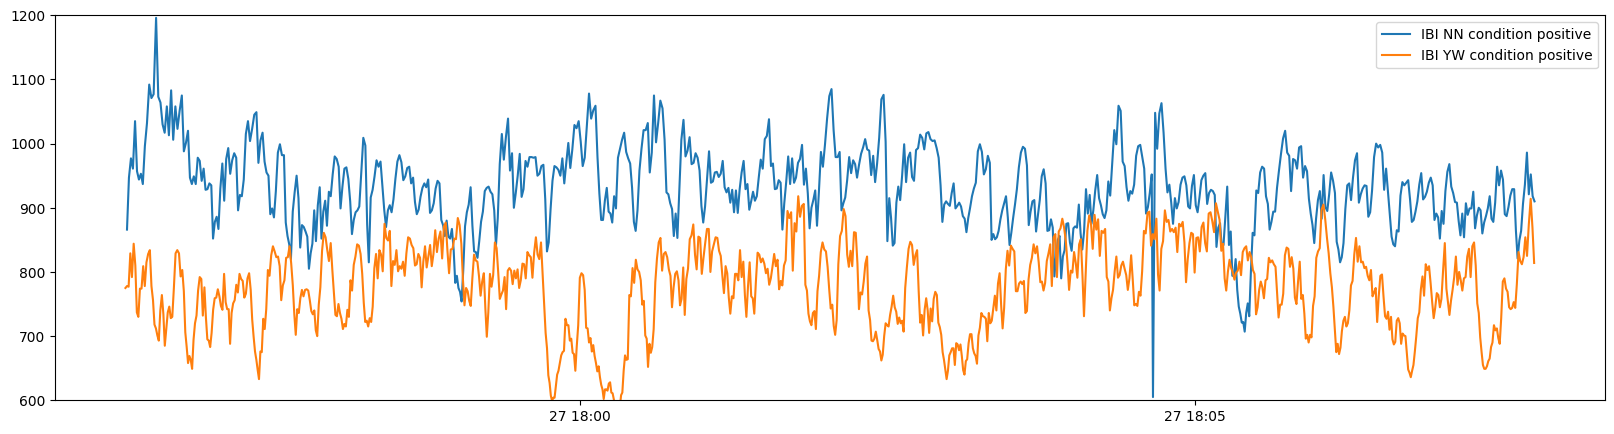

In [ ]:
session = 'NN'
condition = 'positive'
person_1 = session
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(mw_p1[session][condition]['timestamp'], mw_p1[session][condition]['IBI'], label=f'IBI {person_1} condition {condition}')
ax.plot(mw_p2[session][condition]['timestamp'], mw_p2[session][condition]['IBI'], label=f'IBI {person_2} condition {condition}')
ax.set_ylim(1/0.1500, 1200)
ax.legend()
plt.show()

### **Wavelet basics**

#### **Continuous vs discrete wavelet transform**

Continuous wavelet transform compares a signal with shifted and scaled (contracted or streched) copies of a basic wavelet. If $\psi(t)$ is a wavelet centered at $t=0$ with time support on $[-T/2, T/2]$, then $\frac{1}{s}\psi(\frac{t-u}{s})$ is centered at $t=u$ with time support $[-\frac{sT}{2}+u, \frac{sT}{2}+u]$. $s$ is a scaling factor; when $s>1$, the wavelet is streched (slow changes), and when $0<s<1$, the wavelet is contracted (fast changes). 

The major difference between continuous wavelet transform and discrete wavelet transform is that how the scale parameter ($s$) is discretized. continuous wavelet transform discretizes scale more finely than the discrete wavelet transform.

> Reference: https://www.mathworks.com/help/wavelet/gs/continuous-and-discrete-wavelet-transforms.html

In [1035]:
ibi_array_p1 = {}
ibi_array_p2 = {}
time_array_p1 = {}
time_array_p2 = {}

for session in sessions:
    ibi_array_p1[session] = {}
    ibi_array_p2[session] = {}
    time_array_p1[session] = {}
    time_array_p2[session] = {}
    if session == 'NN':
        conditions = conditions_full
    elif session == 'NY':
        conditions = conditions_NY_ecg
    else:
        conditions = conditions_VM_MG
    for condition in conditions:
        ibi_array_p1[session][condition] = mw_p1[session][condition]['IBI'].values
        ibi_array_p2[session][condition] = mw_p2[session][condition]['IBI'].values
        time_array_p1[session][condition] = mw_p1[session][condition]['time'].values
        time_array_p2[session][condition] = mw_p2[session][condition]['time'].values

### Re-sampling

Because the wavelet analyis requires arrays with a fixed sampling rate, re-sampling the IBI arrays.

In [1036]:
new_t_ibi = {}
resampled_ibi_p1 = {}
resampled_ibi_p2 = {}

for session in sessions:
    new_t_ibi[session] = {}
    resampled_ibi_p1[session] = {}
    resampled_ibi_p2[session] = {}
    if session == 'NN':
        conditions = conditions_full
    elif session == 'NY':
        conditions = conditions_NY_ecg
    else:
        conditions = conditions_VM_MG
    for condition in conditions:
        # Re-samplg at 1 Hz
        new_t_ibi[session][condition] = np.arange(max(time_array_p1[session][condition][0], time_array_p2[session][condition][0]), min(time_array_p1[session][condition][-1], time_array_p2[session][condition][-1]), 1000)
        interp_func_p1 = interp1d(time_array_p1[session][condition], ibi_array_p1[session][condition], kind='quadratic')
        resampled_ibi_p1[session][condition] = interp_func_p1(new_t_ibi[session][condition])
        interp_func_p2 = interp1d(time_array_p2[session][condition], ibi_array_p2[session][condition], kind='quadratic')
        resampled_ibi_p2[session][condition] = interp_func_p2(new_t_ibi[session][condition])

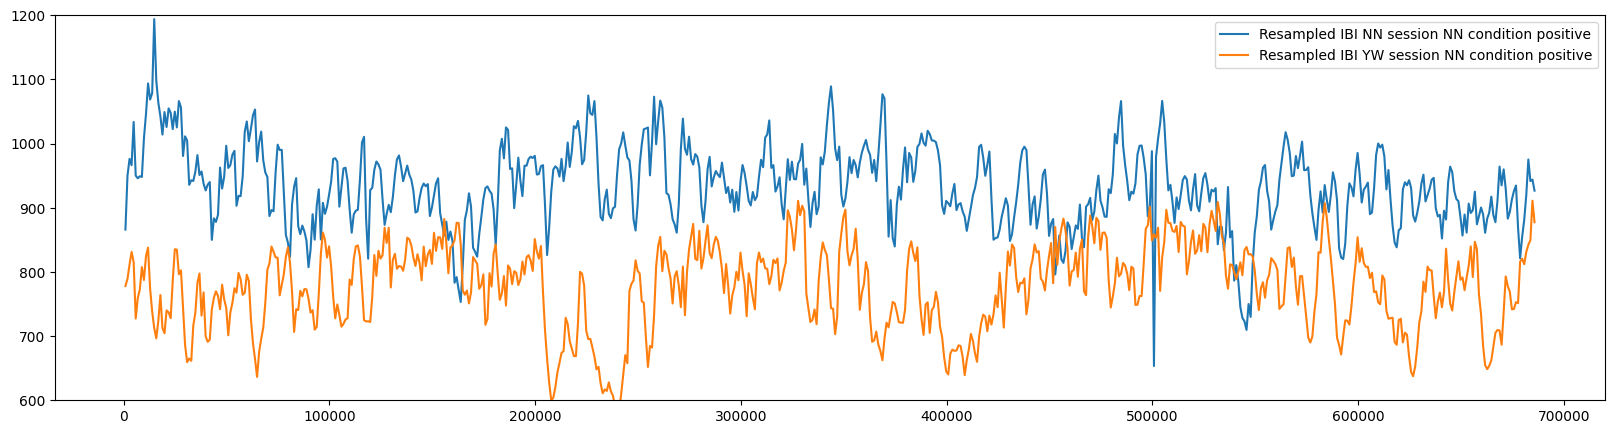

In [ ]:
session = 'NN'
condition = 'positive'
person_1 = session
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(new_t_ibi[session][condition], resampled_ibi_p1[session][condition], label=f'Resampled IBI {person_1} session {session} condition {condition}')
ax.plot(new_t_ibi[session][condition], resampled_ibi_p2[session][condition], label=f'Resampled IBI {person_2} session {session} condition {condition}')
ax.set_ylim(1/0.1500, 1200)
ax.legend()
plt.show()

### Standardization

Before applying the wavelet analysis, subtract a mean value and normalize by standard deviation.

In [1038]:
ibi_standardized_p1 = {}
ibi_standardized_p2 = {}

for session in sessions:
    ibi_standardized_p1[session] = {}
    ibi_standardized_p2[session] = {}
    if session == 'NN':
        conditions = conditions_full
    elif session == 'NY':
        conditions = conditions_NY_ecg
    else:
        conditions = conditions_VM_MG
    for condition in conditions:
        ibi_standardized_p1[session][condition] = (resampled_ibi_p1[session][condition] - np.mean(resampled_ibi_p1[session][condition])) / np.std(resampled_ibi_p1[session][condition])
        ibi_standardized_p2[session][condition] = (resampled_ibi_p2[session][condition] - np.mean(resampled_ibi_p2[session][condition])) / np.std(resampled_ibi_p2[session][condition])

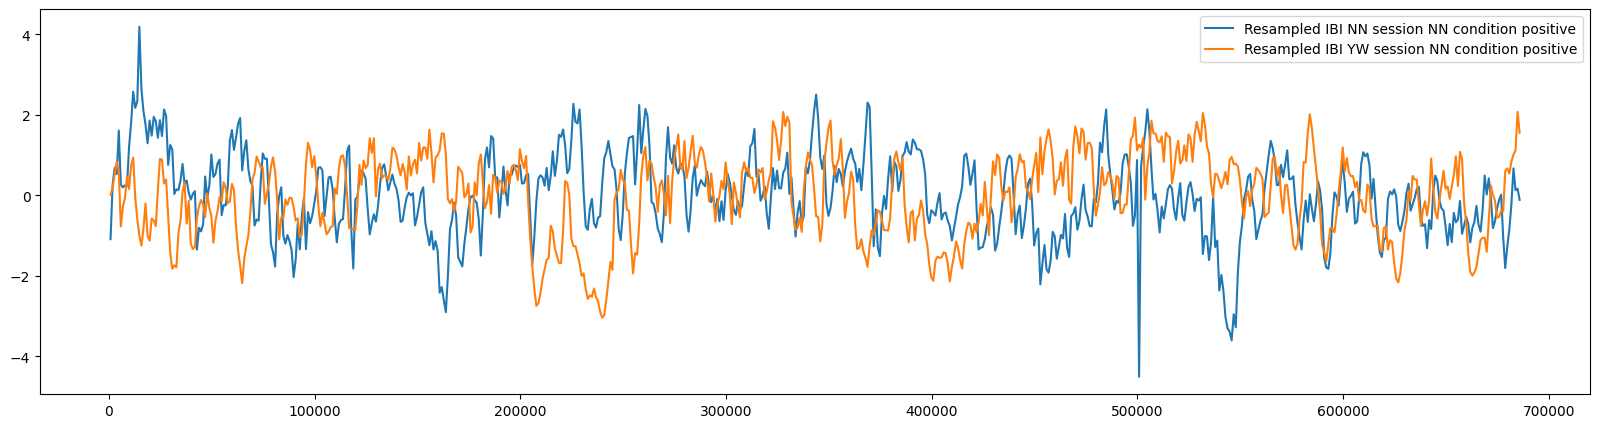

In [1039]:
session = 'NN'
condition = 'positive'
person_1 = session
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(new_t_ibi[session][condition], ibi_standardized_p1[session][condition], label=f'Resampled IBI {person_1} session {session} condition {condition}')
ax.plot(new_t_ibi[session][condition], ibi_standardized_p2[session][condition], label=f'Resampled IBI {person_2} session {session} condition {condition}')
ax.legend()
plt.show()

### Decide parameters for wavelet analysis

#### Choose a type of Wavelet
**Morlet wavelet**: Has high frequency resolution

**Paul wavelet**:

**Derivative of a Gaussian wavelet family**:

**Mexican hat wavelet**:


> Refefence:Torrence, C., & Compo, G. P. (1998). A practical guide to wavelet analysis. Bulletin of the American Meteorological Society, 79(1), 61–78.

In [1040]:
fs = 1
dt = 1/fs
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 0.25 seconds = 0.5 seconds
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 7 / dj  # Seven powers of two with dj sub-octaves

### Continuous wavelet transform

`cwt(signal, dt, dj=1 / 12, s0=-1, J=-1, wavelet='morlet', freqs=None)`

This function implements continuous wavelet transform.

**Parameters**

- `signal`: Signal to implement wavelet transform.
- `dt`: Sampling interval of the signal.
- `dj`: Spacing between discrete value. Smaller value results in higher resolution but slower calculation.
- `s0`: Smallest scale of the wavelet. By default, 2 * dt.
- `J`: Number of scales. Scales range from s0 up to s0 * 2*(J * dj), which gives a total of (J + 1) scales. 
- `wavelet`: Instance of wavelet class or string mother wavelet class.
- `freqs`: Custom frequencies to use instead of the scales provided.

**Returns**
- `W`: Wavelet transform results. Has (J+1) * N dimensions.
- `freqs`: Vector of Fourier frequencies (in 1 / time units) that corresponds to the wavelet scales.
- `coi`: Returns the cone of influence, which is a vector of N points containing the maximum Fourier period of useful information at that particular time.
- `fft`: Normalized fast Fourier transform of the input signal. 
- `fftfreq`: Fourier frequencies (in 1/time units) for the calculated FFT spectrum.

#### Double-check if wavelet coherence between two same signals will be 1

In [1041]:
session = 'MG'
condition = 'research'
N = len(new_t_ibi[session][condition])
wct_auto, awct_auto, coi_auto, freq_auto, sig_auto = wavelet.wct(ibi_standardized_p1[session][condition], ibi_standardized_p1[session][condition], dt, dj=dj, s0=s0, J=-1, sig=True, wavelet=mother, normalize=False)

NOTE: WCT significance loaded from cache.



/Users/yuna.w/Research/CBSL/linkage_analysis/.venv/lib/python3.12/site-packages/pycwt/wavelet.py:633: RuntimeWarning: invalid value encountered in arctanh
  aa = numpy.round(numpy.arctanh(numpy.array([al1, al2]) * 4))


In [1042]:
print("Max:", np.max(wct_auto))
print("Min:", np.min(wct_auto))
print("Mean:", np.mean(wct_auto))

Max: 1.000000000000009
Min: 0.9999999999999889
Mean: 1.0


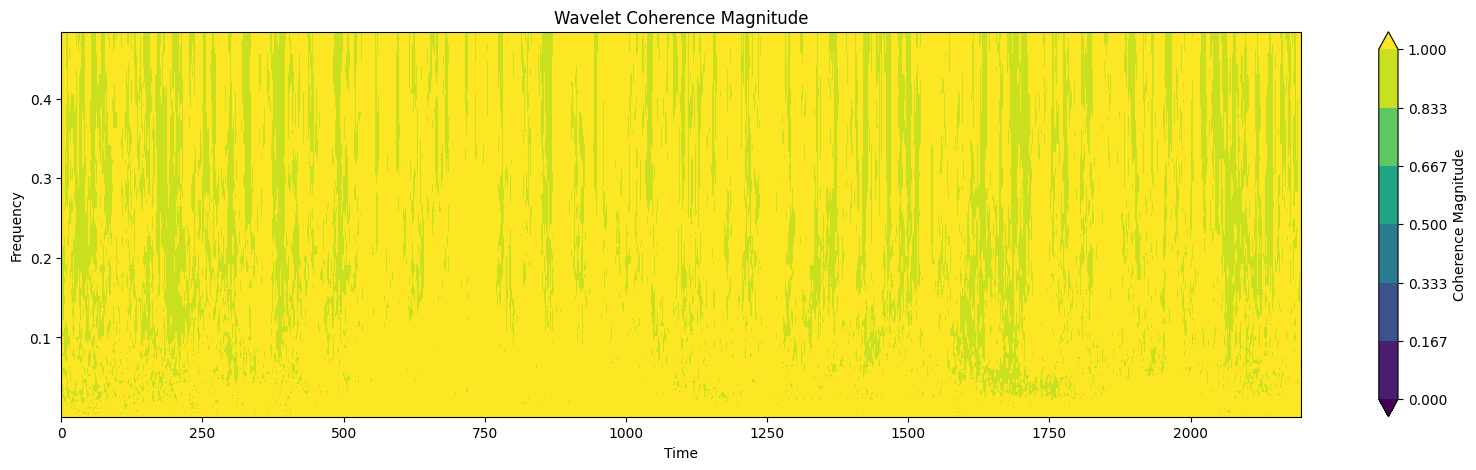

In [1043]:
plt.figure(figsize=(20, 5))
plt.contourf(np.arange(len(ibi_standardized_p1[session][condition])) * dt, freq_auto, wct_auto, levels=np.linspace(0, 1, 7), extend='both')
plt.title('Wavelet Coherence Magnitude')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar(label='Coherence Magnitude')
plt.show()

### Use surrogate data to determine threshold

In [2053]:
import itertools
data_list = [
    {"session": "NN", "condition": "positive", "person": "NN"},
    {"session": "NN", "condition": "positive", "person": "YW"},
    {"session": "NN", "condition": "negative", "person": "NN"},
    {"session": "NN", "condition": "negative", "person": "YW"},
    {"session": "NN", "condition": "neutral", "person": "NN"},
    {"session": "NN", "condition": "neutral", "person": "YW"},
    {"session": "NY", "condition": "positive", "person": "NY"},
    {"session": "NY", "condition": "positive", "person": "YW"},
    {"session": "NY", "condition": "negative", "person": "NY"},
    {"session": "NY", "condition": "negative", "person": "YW"},
    {"session": "MG", "condition": "research", "person": "MG"},
    {"session": "MG", "condition": "research", "person": "YW"},
    {"session": "VM", "condition": "research", "person": "VM"},
    {"session": "VM", "condition": "research", "person": "YW"},
]

data_df = pd.DataFrame(data_list)

# 2. Create all possible pairs
pairs = list(itertools.product(data_df.index, data_df.index))

# 3. Filter out pairs that are not valid
filtered_pairs = set()
for i, j in pairs:
    row_i = data_df.iloc[i]
    row_j = data_df.iloc[j]
    
    # Remove pairs with the same person
    if row_i['person'] == row_j['person']:
        continue
    
    # Remove pairs with the same session and condition
    if row_i['session'] == row_j['session'] and row_i['condition'] == row_j['condition']:
        continue
    
    pair = tuple(sorted([i, j]))
    filtered_pairs.add(pair)

surrogate_pairs = pd.DataFrame([
    {
        "index1": pair[0], 
        "index2": pair[1], 
        "session1": data_df.iloc[pair[0]]['session'], 
        "condition1": data_df.iloc[pair[0]]['condition'], 
        "person1": data_df.iloc[pair[0]]['person'], 
        "session2": data_df.iloc[pair[1]]['session'], 
        "condition2": data_df.iloc[pair[1]]['condition'], 
        "person2": data_df.iloc[pair[1]]['person']
    }
    for pair in filtered_pairs
])

surrogate_pairs

,index1,index2,session1,condition1,person1,session2,condition2,person2
0,6,12,NY,positive,NY,VM,research,VM
1,3,4,NN,negative,YW,NN,neutral,NN
2,4,9,NN,neutral,NN,NY,negative,YW
3,4,6,NN,neutral,NN,NY,positive,NY
4,4,12,NN,neutral,NN,VM,research,VM
5,3,10,NN,negative,YW,MG,research,MG
6,5,10,NN,neutral,YW,MG,research,MG
7,0,5,NN,positive,NN,NN,neutral,YW
8,8,12,NY,negative,NY,VM,research,VM
9,1,6,NN,positive,YW,NY,positive,NY


In [2054]:
ibi_standardized_all = {}

for session in ibi_standardized_p1.keys():
    person = session
    ibi_standardized_all[session] = {}
    for condition in ibi_standardized_p1[session].keys():
        ibi_standardized_all[session][condition] = {}
        ibi_standardized_all[session][condition][person] = ibi_standardized_p1[session][condition]
for session in ibi_standardized_p2.keys():
    person = 'YW'
    for condition in ibi_standardized_p2[session].keys():
        ibi_standardized_all[session][condition][person] = ibi_standardized_p2[session][condition]

In [2063]:
wct_surrogate = []

for pair_i in range(len(surrogate_pairs)):
    print(f'Processing pair {pair_i+1}/{len(surrogate_pairs)}')
    session1 = surrogate_pairs.loc[pair_i, 'session1']
    condition1 = surrogate_pairs.loc[pair_i, 'condition1']
    person1 = surrogate_pairs.loc[pair_i, 'person1']
    session2 = surrogate_pairs.loc[pair_i, 'session2']
    condition2 = surrogate_pairs.loc[pair_i, 'condition2']
    person2 = surrogate_pairs.loc[pair_i, 'person2']
    print(f'    {session1} {condition1} {person1} vs {session2} {condition2} {person2}')

    max_idx = min(len(ibi_standardized_all[session1][condition1][person1]), len(ibi_standardized_all[session2][condition2][person2]))
    wct, awct, coi, freq, sig = wavelet.wct(ibi_standardized_all[session1][condition1][person1][:max_idx], ibi_standardized_all[session2][condition2][person2][:max_idx], dt, dj=dj, s0=s0, J=-1, sig=True, wavelet=mother, normalize=True)
    period = 1 / freq
    for t in range(wct.shape[1]):
        mask = period > coi[t]
        wct[mask, t] = np.nan
    wct_surrogate.append(wct)

Processing pair 1/59
    NY positive NY vs VM research VM
NOTE: WCT significance loaded from cache.

Processing pair 2/59
    NN negative YW vs NN neutral NN
NOTE: WCT significance loaded from cache.

Processing pair 3/59
    NN neutral NN vs NY negative YW
NOTE: WCT significance loaded from cache.



/Users/yuna.w/Research/CBSL/linkage_analysis/.venv/lib/python3.12/site-packages/pycwt/wavelet.py:633: RuntimeWarning: invalid value encountered in arctanh
  aa = numpy.round(numpy.arctanh(numpy.array([al1, al2]) * 4))


Processing pair 4/59
    NN neutral NN vs NY positive NY
NOTE: WCT significance loaded from cache.

Processing pair 5/59
    NN neutral NN vs VM research VM
NOTE: WCT significance loaded from cache.

Processing pair 6/59
    NN negative YW vs MG research MG
NOTE: WCT significance loaded from cache.

Processing pair 7/59
    NN neutral YW vs MG research MG
NOTE: WCT significance loaded from cache.

Processing pair 8/59
    NN positive NN vs NN neutral YW
NOTE: WCT significance loaded from cache.

Processing pair 9/59
    NY negative NY vs VM research VM
NOTE: WCT significance loaded from cache.

Processing pair 10/59
    NN positive YW vs NY positive NY
NOTE: WCT significance loaded from cache.

Processing pair 11/59
    NN positive NN vs NY negative NY
NOTE: WCT significance loaded from cache.

Processing pair 12/59
    NN negative NN vs NN neutral YW
NOTE: WCT significance loaded from cache.

Processing pair 13/59
    NN negative NN vs MG research YW
NOTE: WCT significance loaded from

95th percentile: 0.6032566830098761


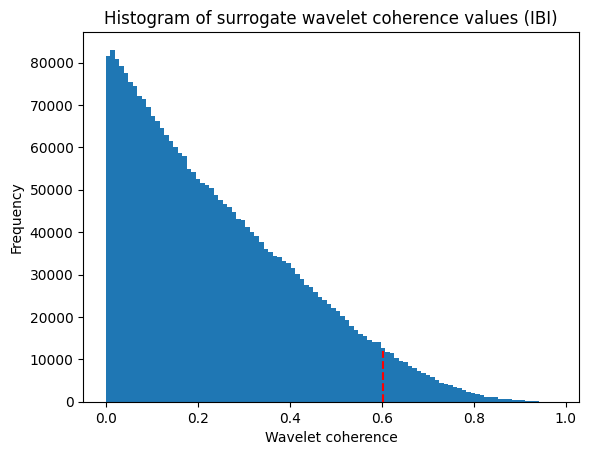

In [2070]:
wct_surrogate_flattened = [wct.flatten() for wct in wct_surrogate]
wct_surrogate_concatenated = np.concatenate(wct_surrogate_flattened)
wct_surrogate_concatenated = wct_surrogate_concatenated[~np.isnan(wct_surrogate_concatenated)]
percentile_95_ibi = np.percentile(wct_surrogate_concatenated, 95)
print("95th percentile:", percentile_95_ibi)
plt.hist(wct_surrogate_concatenated, bins=100)
plt.vlines(percentile_95_ibi, 0, 12000, colors='r', linestyles='dashed')
plt.title('Histogram of surrogate wavelet coherence values (IBI)')
plt.xlabel('Wavelet coherence')
plt.ylabel('Frequency')
#plt.ylim(0, 12000)
plt.show()

In [2073]:
with open('../data/surrogate_wavelet_coherence_ibi.npy', 'wb') as f:
    np.save(f, wct_surrogate_concatenated)
with open('../data/ibi_95_percentile.txt', 'w') as f:
    f.write(str(percentile_95_ibi))

### Calculating wavelet coherence between two signals

In [2074]:
from matplotlib.ticker import FuncFormatter
def plot_wavelet_result(threshold, t, wct, awct, coi, freq, modality, ylim_low=None, ylim_high=None, timestamps = None):
    # 周波数を周期に変換
    period = np.log2(1 / freq)  # 周波数を逆数にすることで周期を取得

    fig, ax = plt.subplots(figsize=(10, 5))

    # カラーマップのプロット
    contour = ax.contourf(
        t,
        period,  # 周期を y 軸に使用
        wct,
        levels=np.linspace(0, 1, 7)
    )

    # ベクトル成分計算
    u = np.cos(awct) * wct  # x成分
    v = np.sin(awct) * wct  # y成分

    # 時間-周期グリッドの作成
    X, Y = np.meshgrid(t, period)

    # 有意性マスクの作成
    significant_mask = wct > threshold

    # 矢印の間引き
    step = 5
    ax.quiver(
        X[significant_mask][::step],
        Y[significant_mask][::step],
        u[significant_mask][::step],
        v[significant_mask][::step],
        scale=50,
        color='black'
    )

    # COI をプロット
    coi_period = np.log2(coi)
    ax.plot(t, coi_period, 'k--', label='Cone of Influence')

    # カラーバーの追加
    cbar = fig.colorbar(contour, ax=ax)
    cbar.set_label('Coherence Magnitude')

    # 軸ラベル、タイトル、範囲設定
    ax.set_title(f'Wavelet Coherence Magnitude with Phase Arrows ({modality})')
    ax.set_xlabel('Time')
    ax.set_ylabel('Period (seconds)')
    if ylim_low is not None and ylim_high is not None:
        ylim_low = np.log2(ylim_low)
        ylim_high = np.log2(ylim_high)
        ax.set_ylim(ylim_low, ylim_high)  # 周期の範囲に合わせる
    if (timestamps is not None):
        ax.set_xticks(t[::100])
        timestamps_str = [timestamp.strftime('%H:%M:%S') for timestamp in timestamps]
        ax.set_xticklabels(timestamps_str[::100], rotation=90)

    def log2_to_nonlog2(x, pos):
        return f'{2**x:.2f}'

    ax.yaxis.set_major_formatter(FuncFormatter(log2_to_nonlog2))
    
    # 凡例を追加
    ax.legend()

In [2075]:
session = 'NY'
condition = 'positive'
wct_ibi, awct_ibi, coi_ibi, freq_ibi, sig_ibi = wavelet.wct(ibi_standardized_p1[session][condition], ibi_standardized_p2[session][condition], dt, dj=dj, s0=s0, J=-1, sig=True, wavelet=mother, normalize=True)

NOTE: WCT significance loaded from cache.



/Users/yuna.w/Research/CBSL/linkage_analysis/.venv/lib/python3.12/site-packages/pycwt/wavelet.py:633: RuntimeWarning: invalid value encountered in arctanh
  aa = numpy.round(numpy.arctanh(numpy.array([al1, al2]) * 4))


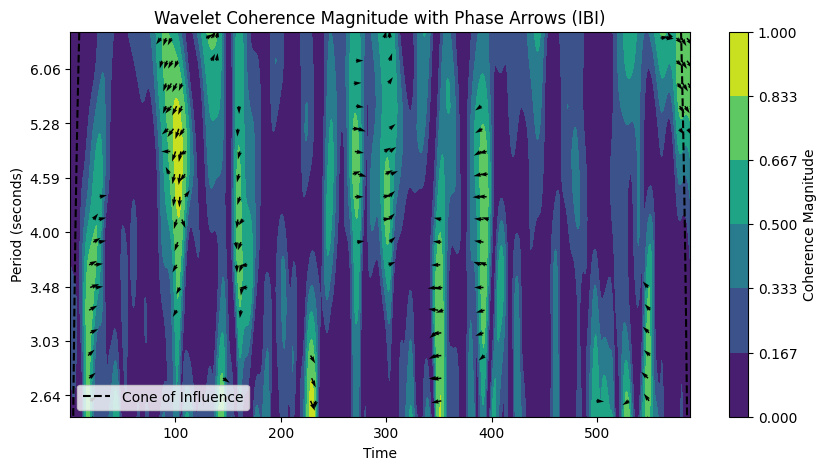

In [2076]:
plot_wavelet_result(threshold=percentile_95_ibi, t=new_t_ibi[session][condition]/1000, wct=wct_ibi, awct=awct_ibi, coi=coi_ibi, freq=freq_ibi, modality='IBI', ylim_low=1/0.4, ylim_high=1/0.15)
plt.savefig(f'../result/{session}_{condition}_ibi_HF.png')

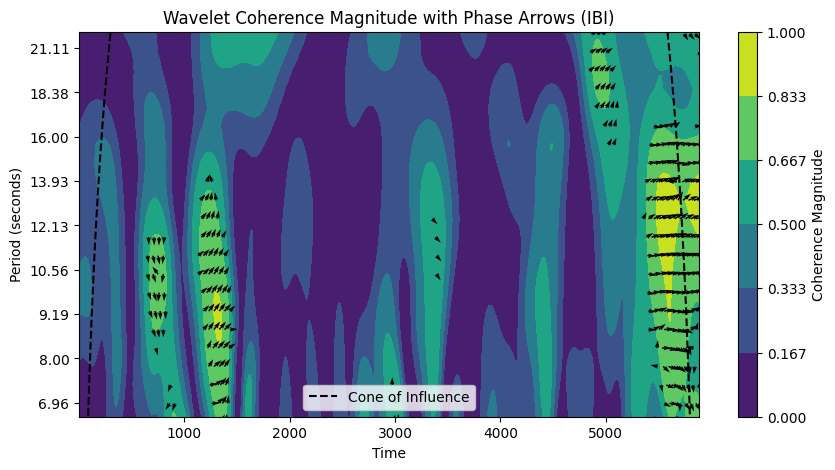

In [2077]:
plot_wavelet_result(threshold=percentile_95_ibi, t=new_t_ibi[session][condition]/100, wct=wct_ibi, awct=awct_ibi, coi=coi_ibi, freq=freq_ibi, modality='IBI', ylim_low=1/0.15, ylim_high=1/0.045)
plt.savefig(f'../result/{session}_{condition}_ibi_LF.png')

### Summarizing results

In [2078]:
wct_results_ibi = {}
for session in sessions:
    wct_results_ibi[session] = {}
    if session == 'NN':
        conditions = conditions_full
    elif session == 'NY':
        conditions = conditions_NY_ecg
    else:
        conditions = conditions_VM_MG
    for condition in conditions:
        wct_ibi, awct_ibi, coi_ibi, freq_ibi, sig_ibi = wavelet.wct(ibi_standardized_p1[session][condition], ibi_standardized_p2[session][condition], dt, dj=dj, s0=s0, J=-1, sig=True, wavelet=mother, normalize=True)
        wct_results_ibi[session][condition] = {}
        wct_results_ibi[session][condition]['wct'] = wct_ibi
        wct_results_ibi[session][condition]['awct'] = awct_ibi
        wct_results_ibi[session][condition]['coi'] = coi_ibi
        wct_results_ibi[session][condition]['freq'] = freq_ibi
        wct_results_ibi[session][condition]['sig'] = sig_ibi

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.



In [2079]:
from scipy.stats import norm
def calculate_aw(p, q):
    """
    Calculate the nonparametric effect size (Aw).
    
    Parameters:
    p (list or numpy array): Scores of population p.
    q (list or numpy array): Scores of population q.
    
    Returns:
    float: Aw, the nonparametric effect size.
    """
    p = np.array(p)
    q = np.array(q)
    count_greater = np.sum(p[:, None] > q)  # Count where elements in p are greater than elements in q
    count_equal = np.sum(p[:, None] == q)  # Count where elements in p are equal to elements in q
    npnq = len(p) * len(q)  # Total number of comparisons
    
    # Calculate Aw
    aw = (count_greater + 0.5 * count_equal) / npnq
    return aw

def convert_aw_to_da(aw, s1_squared, s2_squared, p1=0.5,  p2=0.5):
    """
    Convert A_w to d_A.
    
    Parameters:
    aw (float): The A_w value (nonparametric effect size).
    p1 (float): Proportion of observations in group 1.
    s1_squared (float): Variance of group 1.
    p2 (float): Proportion of observations in group 2.
    s2_squared (float): Variance of group 2.
    
    Returns:
    float: d_A, the robust effect size estimate.
    """
    # Calculate the inverse normal CDF of Aw
    z_aw = norm.ppf(aw)
    
    # Compute the scaling factor
    scaling_factor = np.sqrt((p1 * s1_squared + p2 * s2_squared) / (s1_squared + s2_squared))
    
    # Calculate d_A
    da = z_aw * scaling_factor
    return da

Text(0, 0.5, 'Wavelet Coherence Magnitude')

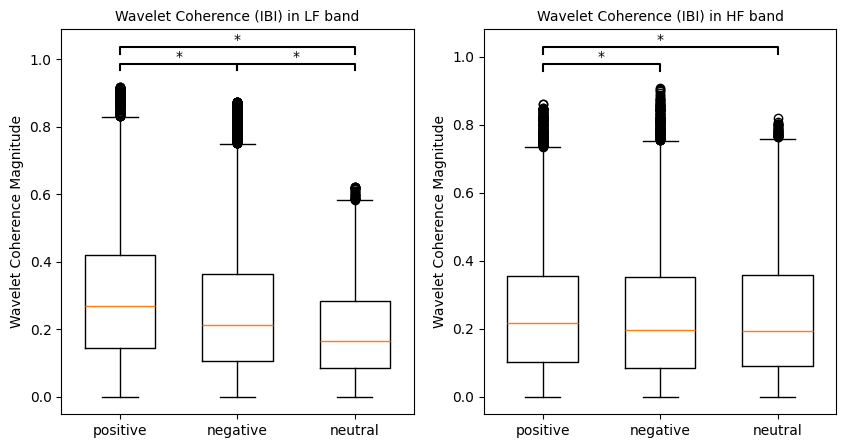

In [2161]:
session = 'NN'
lf_wct_list = []
hf_wct_list = []
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
for condition in conditions_full:
    period = 1 / wct_results_ibi[session][condition]['freq']
    lf_period = np.where((period >= 1/0.15) & (period <=1/0.045))
    hf_period = np.where((period >= 1/0.4) & (period < 1/0.15))
    lf_wct = wct_results_ibi[session][condition]['wct'][lf_period[0], :]
    hf_wct = wct_results_ibi[session][condition]['wct'][hf_period[0], :]
    coi = wct_results_ibi[session][condition]['coi']
    for t in range(lf_wct.shape[1]):
        lf_mask = lf_period > coi[t]
        lf_wct[lf_mask[0], t] = np.nan
        hf_mask = hf_period > coi[t]
        hf_wct[hf_mask[0], t] = np.nan
    lf_wct_list.append(lf_wct)
    hf_wct_list.append(hf_wct)
    lf_wct_flatten = lf_wct.flatten()
    hf_wct_flatten = hf_wct.flatten()
    axes[0].boxplot(lf_wct_flatten[~np.isnan(lf_wct_flatten)], positions=[conditions_full.index(condition)], widths=0.6)
    axes[1].boxplot(hf_wct_flatten[~np.isnan(hf_wct_flatten)], positions=[conditions_full.index(condition)], widths=0.6)

def annotate_boxplot(ax, x1, x2, y, h, col):
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    ax.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)

# Annotate LF plot
y_max = max([np.nanmax(lf) for lf in lf_wct_list])
annotate_boxplot(axes[0], 0, 1, y_max+0.05, 0.02, 'k')
annotate_boxplot(axes[0], 1, 2, y_max+0.05, 0.02, 'k')
annotate_boxplot(axes[0], 0, 2, y_max+0.1, 0.02, 'k')

# Annotate HF plot
y_max = max([np.nanmax(hf) for hf in hf_wct_list])
annotate_boxplot(axes[1], 0, 1, y_max+0.05, 0.02, 'k')
#annotate_boxplot(axes[1], 1, 2, y_max+0.05, 0.02, 'k')
annotate_boxplot(axes[1], 0, 2, y_max+0.1, 0.02, 'k')

for ax in axes:
    ax.set_xticklabels(conditions_full)
axes[0].set_title('Wavelet Coherence (IBI) in LF band', fontsize=10)
axes[1].set_title('Wavelet Coherence (IBI) in HF band', fontsize=10)
axes[0].set_ylabel('Wavelet Coherence Magnitude')
axes[1].set_ylabel('Wavelet Coherence Magnitude')

In [2162]:
array_1 = lf_wct_list[0].flatten()
array_2 = lf_wct_list[1].flatten()
array_3 = lf_wct_list[2].flatten()
print(f'% of significant coherence in LF band for {conditions_full[0]}: {np.sum(array_1 > percentile_95_ibi) / len(array_1[~np.isnan(array_1)]) * 100:.2f}%')
print(f'% of significant coherence in LF band for {conditions_full[1]}: {np.sum(array_2 > percentile_95_ibi) / len(array_2[~np.isnan(array_2)]) * 100:.2f}%')
print(f'% of significant coherence in LF band for {conditions_full[2]}: {np.sum(array_3 > percentile_95_ibi) / len(array_3[~np.isnan(array_3)]) * 100:.2f}%')

% of significant coherence in LF band for positive: 8.80%
% of significant coherence in LF band for negative: 9.04%
% of significant coherence in LF band for neutral: 0.12%


In [2084]:
array_1 = lf_wct_list[0].flatten()
array_2 = lf_wct_list[1].flatten()
array_3 = lf_wct_list[2].flatten()
kruskal(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], array_3[~np.isnan(array_3)])

KruskalResult(statistic=1832.7513172138424, pvalue=0.0)

In [ ]:
array_1 = lf_wct_list[0].flatten()
array_2 = lf_wct_list[1].flatten()
print(mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided'))
aw = calculate_aw(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)])
print(f'aw: {aw}')
print(f'da: {convert_aw_to_da(aw, np.var(array_1[~np.isnan(array_1)]), np.var(array_2[~np.isnan(array_2)]))}')

MannwhitneyuResult(statistic=140075054.0, pvalue=1.0703714933836165e-94)
aw: 0.5680608543456762
da: 0.12122594910051503


In [1978]:
array_1 = lf_wct_list[1].flatten()
array_2 = lf_wct_list[2].flatten()
print(mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided'))
aw = calculate_aw(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)])
print(f'aw: {aw}')
print(f'da: {convert_aw_to_da(aw, np.var(array_1[~np.isnan(array_1)]), np.var(array_2[~np.isnan(array_2)]))}')

MannwhitneyuResult(statistic=134411211.0, pvalue=1.111536349877479e-143)
aw: 0.5860362326967287
da: 0.15369697200829


In [1979]:
array_1 = lf_wct_list[0].flatten()
array_2 = lf_wct_list[2].flatten()
print(mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided'))
aw = calculate_aw(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)])
print(f'aw: {aw}')
print(f'da: {convert_aw_to_da(aw, np.var(array_1[~np.isnan(array_1)]), np.var(array_2[~np.isnan(array_2)]))}')

MannwhitneyuResult(statistic=98061867.0, pvalue=0.0)
aw: 0.6615475960333481
da: 0.2946446743639391


In [2085]:
array_1 = hf_wct_list[0].flatten()
array_2 = hf_wct_list[1].flatten()
array_3 = hf_wct_list[2].flatten()
kruskal(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], array_3[~np.isnan(array_3)])

KruskalResult(statistic=50.41178723104531, pvalue=1.1303670549988474e-11)

In [2086]:
array_1 = hf_wct_list[0].flatten()
array_2 = hf_wct_list[1].flatten()
array_3 = hf_wct_list[2].flatten()
print(f'% of significant coherence in HF band for {conditions_full[0]}: {np.sum(array_1 > percentile_95_ibi) / len(array_1[~np.isnan(array_1)]) * 100:.2f}%')
print(f'% of significant coherence in HF band for {conditions_full[1]}: {np.sum(array_2 > percentile_95_ibi) / len(array_2[~np.isnan(array_2)]) * 100:.2f}%')
print(f'% of significant coherence in HF band for {conditions_full[2]}: {np.sum(array_3 > percentile_95_ibi) / len(array_3[~np.isnan(array_3)]) * 100:.2f}%')

% of significant coherence in HF band for positive: 4.02%
% of significant coherence in HF band for negative: 4.75%
% of significant coherence in HF band for neutral: 2.78%


In [1982]:
array_1 = hf_wct_list[0].flatten()
array_2 = hf_wct_list[1].flatten()
print(mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided'))
aw = calculate_aw(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)])
print(f'aw: {aw}')
print(f'da: {convert_aw_to_da(aw, np.var(array_1[~np.isnan(array_1)]), np.var(array_2[~np.isnan(array_2)]))}')

MannwhitneyuResult(statistic=97146088.0, pvalue=1.1924981768264406e-11)
aw: 0.5239711995062358
da: 0.042513443826150694


In [1984]:
array_1 = hf_wct_list[1].flatten()
array_2 = hf_wct_list[2].flatten()
print(mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided'))

MannwhitneyuResult(statistic=86260456.0, pvalue=0.44262394773959945)


In [1985]:
array_1 = hf_wct_list[0].flatten()
array_2 = hf_wct_list[2].flatten()
print(mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided'))
aw = calculate_aw(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)])
print(f'aw: {aw}')
print(f'da: {convert_aw_to_da(aw, np.var(array_1[~np.isnan(array_1)]), np.var(array_2[~np.isnan(array_2)]))}')

MannwhitneyuResult(statistic=60148198.0, pvalue=6.033141017557366e-08)
aw: 0.5213478897909484
da: 0.03785622553742668


Text(0.5, 1.0, 'Wavelet Coherence (IBI) in HF band')

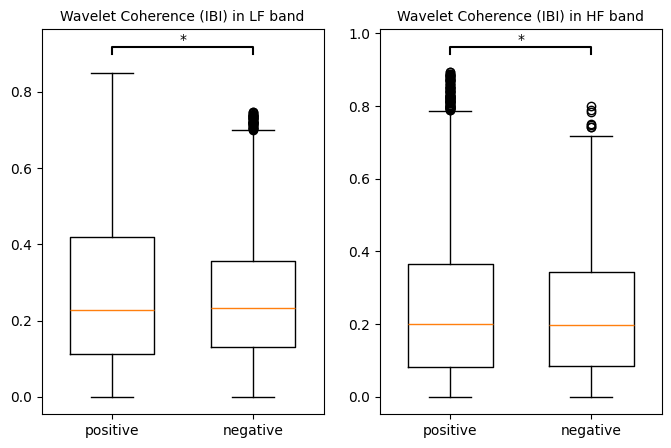

In [2087]:
session = 'NY'
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 5))
lf_wct_list = []
hf_wct_list = []
for condition in conditions_NY_ecg:
    period = 1 / wct_results_ibi[session][condition]['freq']
    lf_period = np.where((period >= 1/0.15) & (period <=1/0.045))
    hf_period = np.where((period >= 1/0.4) & (period < 1/0.15))
    lf_wct = wct_results_ibi[session][condition]['wct'][lf_period[0], :]
    hf_wct = wct_results_ibi[session][condition]['wct'][hf_period[0], :]
    coi = wct_results_ibi[session][condition]['coi']
    for t in range(lf_wct.shape[1]):
        lf_mask = lf_period > coi[t]
        lf_wct[lf_mask[0], t] = np.nan
        hf_mask = hf_period > coi[t]
        hf_wct[hf_mask[0], t] = np.nan
    lf_wct_list.append(lf_wct)
    hf_wct_list.append(hf_wct)
    lf_wct_flatten = lf_wct.flatten()
    hf_wct_flatten = hf_wct.flatten()
    axes[0].boxplot(lf_wct_flatten[~np.isnan(lf_wct_flatten)], positions=[conditions_full.index(condition)], widths=0.6)
    axes[1].boxplot(hf_wct_flatten[~np.isnan(hf_wct_flatten)], positions=[conditions_full.index(condition)], widths=0.6)

# Annotate LF plot
y_max = max([np.nanmax(lf) for lf in lf_wct_list])
annotate_boxplot(axes[0], 0, 1, y_max+0.05, 0.02, 'k')
# annotate_boxplot(axes[0], 1, 2, y_max+0.05, 0.02, 'k')
# annotate_boxplot(axes[0], 0, 2, y_max+0.1, 0.02, 'k')

# Annotate HF plot
y_max = max([np.nanmax(hf) for hf in hf_wct_list])
annotate_boxplot(axes[1], 0, 1, y_max+0.05, 0.02, 'k')
# annotate_boxplot(axes[1], 1, 2, y_max+0.05, 0.02, 'k')
# annotate_boxplot(axes[1], 0, 2, y_max+0.1, 0.02, 'k')

for ax in axes:
    ax.set_xticklabels(conditions_NY_ecg)
axes[0].set_title('Wavelet Coherence (IBI) in LF band', fontsize=10)
axes[1].set_title('Wavelet Coherence (IBI) in HF band', fontsize=10)

In [2088]:
array_1 = lf_wct_list[0].flatten()
array_2 = lf_wct_list[1].flatten()
print(f'% of significant coherence in LF band for {conditions_NY_ecg[0]}: {np.sum(array_1 > percentile_95_ibi) / len(array_1[~np.isnan(array_1)]) * 100:.2f}%')
print(f'% of significant coherence in LF band for {conditions_NY_ecg[1]}: {np.sum(array_2 > percentile_95_ibi) / len(array_2[~np.isnan(array_2)]) * 100:.2f}%')

% of significant coherence in LF band for positive: 7.21%
% of significant coherence in LF band for negative: 2.44%


In [2089]:
array_1 = lf_wct_list[0].flatten()
array_2 = lf_wct_list[1].flatten()
print(mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided'))
aw = calculate_aw(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)])
print(f'aw: {aw}')
print(f'da: {convert_aw_to_da(aw, np.var(array_1[~np.isnan(array_1)]), np.var(array_2[~np.isnan(array_2)]))}')

MannwhitneyuResult(statistic=60134531.0, pvalue=0.0008419586439818939)
aw: 0.513101629898576
da: 0.02322621020369937


In [2090]:
array_1 = hf_wct_list[0].flatten()
array_2 = hf_wct_list[1].flatten()
print(f'% of significant coherence in HF band for {conditions_NY_ecg[0]}: {np.sum(array_1 > percentile_95_ibi) / len(array_1[~np.isnan(array_1)]) * 100:.2f}%')
print(f'% of significant coherence in HF band for {conditions_NY_ecg[1]}: {np.sum(array_2 > percentile_95_ibi) / len(array_2[~np.isnan(array_2)]) * 100:.2f}%')

% of significant coherence in HF band for positive: 7.51%
% of significant coherence in HF band for negative: 2.39%


In [2091]:
array_1 = hf_wct_list[0].flatten()
array_2 = hf_wct_list[1].flatten()
print(mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided'))
aw = calculate_aw(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)])
print(f'aw: {aw}')
print(f'da: {convert_aw_to_da(aw, np.var(array_1[~np.isnan(array_1)]), np.var(array_2[~np.isnan(array_2)]))}')

MannwhitneyuResult(statistic=47769887.0, pvalue=0.0015761049042176574)
aw: 0.5131364311292906
da: 0.023287927152245966


Text(0.5, 1.0, 'Wavelet Coherence (IBI) in HF band')

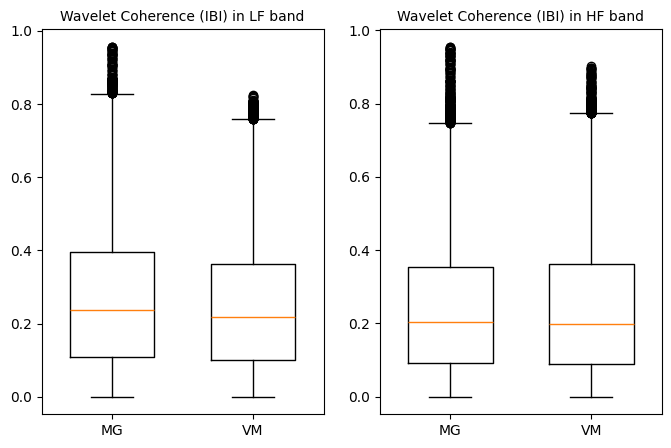

In [2092]:
condition = 'research'
sessions_research = ['MG', 'VM']
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 5))
lf_wct_list = []
hf_wct_list = []
for session in sessions_research:
    period = 1 / wct_results_ibi[session][condition]['freq']
    lf_period = np.where((period >= 1/0.15) & (period <=1/0.045))
    hf_period = np.where((period >= 1/0.4) & (period < 1/0.15))
    lf_wct = wct_results_ibi[session][condition]['wct'][lf_period[0], :]
    hf_wct = wct_results_ibi[session][condition]['wct'][hf_period[0], :]
    coi = wct_results_ibi[session][condition]['coi']
    for t in range(lf_wct.shape[1]):
        lf_mask = lf_period > coi[t]
        lf_wct[lf_mask[0], t] = np.nan
        hf_mask = hf_period > coi[t]
        hf_wct[hf_mask[0], t] = np.nan
    lf_wct_list.append(lf_wct)
    hf_wct_list.append(hf_wct)
    lf_wct_flatten = lf_wct.flatten()
    hf_wct_flatten = hf_wct.flatten()
    axes[0].boxplot(lf_wct_flatten[~np.isnan(lf_wct_flatten)], positions=[sessions_research.index(session)], widths=0.6)
    axes[1].boxplot(hf_wct_flatten[~np.isnan(hf_wct_flatten)], positions=[sessions_research.index(session)], widths=0.6)
for ax in axes:
    ax.set_xticklabels(sessions_research)
axes[0].set_title('Wavelet Coherence (IBI) in LF band', fontsize=10)
axes[1].set_title('Wavelet Coherence (IBI) in HF band', fontsize=10)

In [2094]:
array_1 = lf_wct_list[0].flatten()
array_2 = lf_wct_list[1].flatten()
print(f'% of significant coherence in LF band for {conditions_VM_MG[0]}: {np.sum(array_1 > percentile_95_ibi) / len(array_1[~np.isnan(array_1)]) * 100:.2f}%')
print(f'% of significant coherence in LF band for {conditions_VM_MG[0]}: {np.sum(array_2 > percentile_95_ibi) / len(array_2[~np.isnan(array_2)]) * 100:.2f}%')

% of significant coherence in LF band for research: 6.51%
% of significant coherence in LF band for research: 3.75%


In [1521]:
array_1 = lf_wct_list[0].flatten()
array_2 = lf_wct_list[1].flatten()
mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided')

MannwhitneyuResult(statistic=742771504.0, pvalue=1.0070701449028167e-42)

In [2095]:
array_1 = hf_wct_list[0].flatten()
array_2 = hf_wct_list[1].flatten()
print(f'% of significant coherence in HF band for {conditions_VM_MG[0]}: {np.sum(array_1 > percentile_95_ibi) / len(array_1[~np.isnan(array_1)]) * 100:.2f}%')
print(f'% of significant coherence in HF band for {conditions_VM_MG[0]}: {np.sum(array_2 > percentile_95_ibi) / len(array_2[~np.isnan(array_2)]) * 100:.2f}%')

% of significant coherence in HF band for research: 4.47%
% of significant coherence in HF band for research: 5.36%


In [1523]:
array_1 = hf_wct_list[0].flatten()
array_2 = hf_wct_list[1].flatten()
mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided')

MannwhitneyuResult(statistic=488610052.0, pvalue=0.6532450844115791)

Text(0, 0.5, 'Wavelet Coherence')

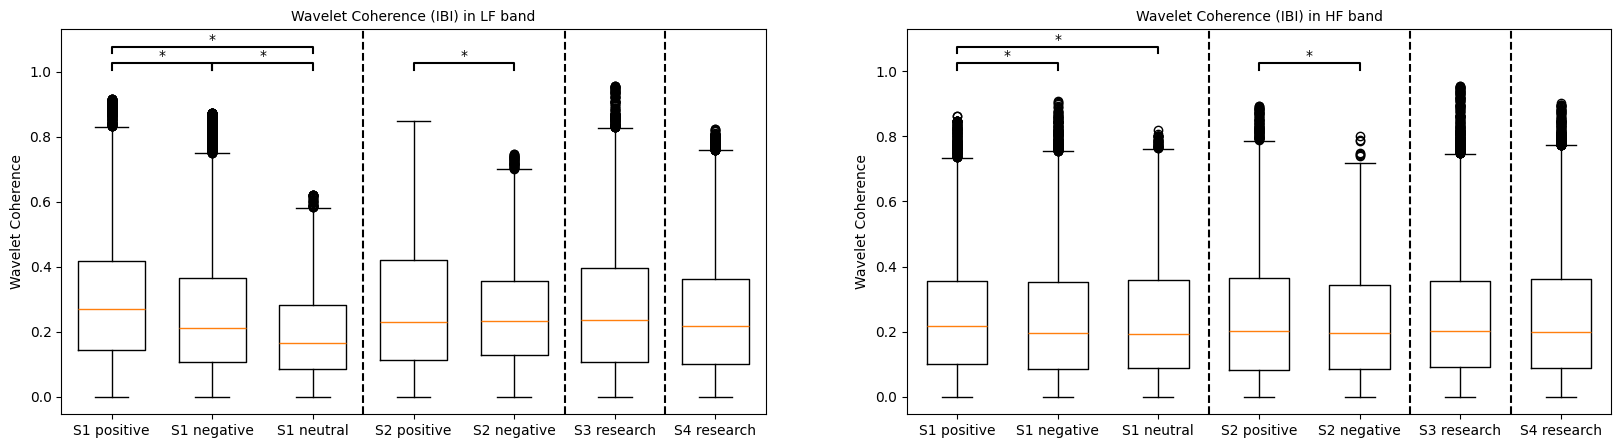

In [2406]:
lf_wct_list = []
hf_wct_list = []
pos = 0
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))
ticklabels = []
for session in sessions:
    if session == 'NN':
        conditions = conditions_full
        study = 'S1'
    elif session == 'NY':
        conditions = conditions_NY_ecg
        study = 'S2'
    else:
        conditions = conditions_VM_MG
        if session == 'MG':
            study = 'S3'
        else:
            study = 'S4'
    for condition in conditions:
        period = 1 / wct_results_ibi[session][condition]['freq']
        lf_period = np.where((period >= 1/0.15) & (period <=1/0.045))
        hf_period = np.where((period >= 1/0.4) & (period < 1/0.15))
        lf_wct = wct_results_ibi[session][condition]['wct'][lf_period[0], :]
        hf_wct = wct_results_ibi[session][condition]['wct'][hf_period[0], :]
        coi = wct_results_ibi[session][condition]['coi']
        for t in range(lf_wct.shape[1]):
            lf_mask = lf_period > coi[t]
            lf_wct[lf_mask[0], t] = np.nan
            hf_mask = hf_period > coi[t]
            hf_wct[hf_mask[0], t] = np.nan
        lf_wct_list.append(lf_wct)
        hf_wct_list.append(hf_wct)
        lf_wct_flatten = lf_wct.flatten()
        hf_wct_flatten = hf_wct.flatten()
        axes[0].boxplot(lf_wct_flatten[~np.isnan(lf_wct_flatten)], positions=[pos], widths=0.1/0.15)
        axes[1].boxplot(hf_wct_flatten[~np.isnan(hf_wct_flatten)], positions=[pos], widths=0.6)
        ticklabels.append(f'{study} {condition}')
        pos += 1

# Annotate LF plot
y_max = max([np.nanmax(lf) for lf in lf_wct_list])
annotate_boxplot(axes[0], 0, 1, y_max+0.05, 0.02, 'k')
annotate_boxplot(axes[0], 1, 2, y_max+0.05, 0.02, 'k')
annotate_boxplot(axes[0], 0, 2, y_max+0.1, 0.02, 'k')
annotate_boxplot(axes[0], 3, 4, y_max+0.05, 0.02, 'k')

# Annotate HF plot
y_max = max([np.nanmax(hf) for hf in hf_wct_list])
annotate_boxplot(axes[1], 0, 1, y_max+0.05, 0.02, 'k')
# annotate_boxplot(axes[1], 1, 2, y_max+0.05, 0.02, 'k')
annotate_boxplot(axes[1], 0, 2, y_max+0.1, 0.02, 'k')
annotate_boxplot(axes[1], 3, 4, y_max+0.05, 0.02, 'k')

for ax in axes:
    ax.set_xticklabels(ticklabels)
axes[0].set_title('Wavelet Coherence (IBI) in LF band', fontsize=10)
axes[1].set_title('Wavelet Coherence (IBI) in HF band', fontsize=10)

axes[0].axvline(x=2.5, color='black', linestyle='--')
axes[0].axvline(x=4.5, color='black', linestyle='--')
axes[0].axvline(x=5.5, color='black', linestyle='--')
axes[1].axvline(x=2.5, color='black', linestyle='--')
axes[1].axvline(x=4.5, color='black', linestyle='--')
axes[1].axvline(x=5.5, color='black', linestyle='--')

axes[0].set_ylabel('Wavelet Coherence')
axes[1].set_ylabel('Wavelet Coherence')

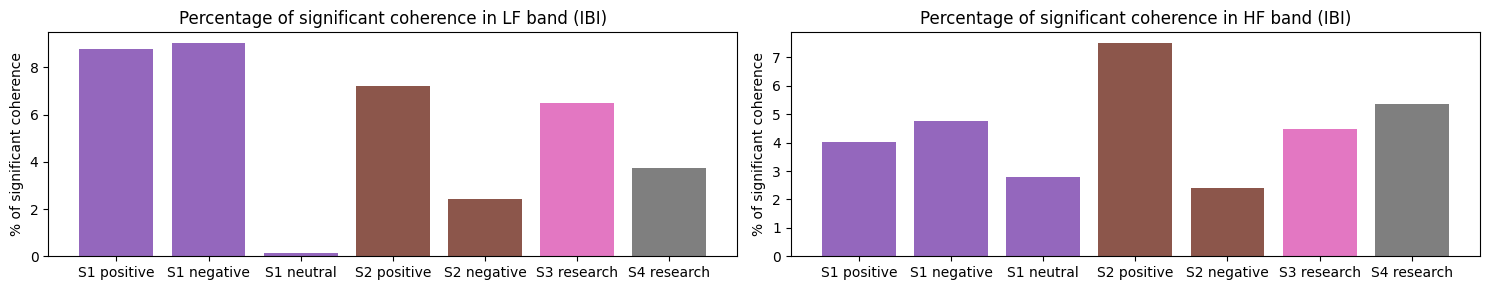

In [2407]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 3))
n = 0
for session in sessions:
    if session == 'NN':
        conditions = conditions_full
        study = 'S1'
        color = 'C4'
    elif session == 'NY':
        conditions = conditions_NY_ecg
        study = 'S2'
        color = 'C5'
    else:
        conditions = conditions_VM_MG
        if session == 'MG':
            study = 'S3'
            color = 'C6'
        else:
            study = 'S4'
            color = 'C7'
    for condition in conditions:
        array_lf = lf_wct_list[n].flatten()
        array_hf = hf_wct_list[n].flatten()
        sig_per_lf = np.sum(array_lf > percentile_95_ibi) / len(array_lf[~np.isnan(array_lf)]) * 100
        sig_per_hf = np.sum(array_hf > percentile_95_ibi) / len(array_hf[~np.isnan(array_hf)]) * 100
        axes[0].bar(f'{study} {condition}', sig_per_lf, color=color)
        axes[1].bar(f'{study} {condition}', sig_per_hf, color=color)
        n += 1
axes[0].set_ylabel('% of significant coherence')
axes[1].set_ylabel('% of significant coherence')
axes[0].set_title('Percentage of significant coherence in LF band (IBI)')
axes[1].set_title('Percentage of significant coherence in HF band (IBI)')
plt.tight_layout()

Text(0, 0.5, 'Weighted in-phase coherence')

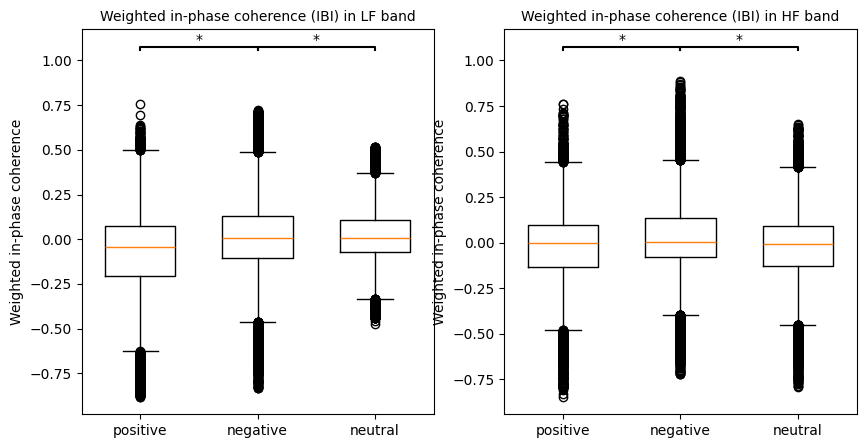

In [2380]:
session = 'NN'
lf_awct_list = []
hf_awct_list = []
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
for condition in conditions_full:
    period = 1 / wct_results_ibi[session][condition]['freq']
    lf_period = np.where((period >= 1/0.15) & (period <=1/0.045))
    hf_period = np.where((period >= 1/0.4) & (period < 1/0.15))
    awct_weighted = np.cos(wct_results_ibi[session][condition]['awct']) * wct_results_ibi[session][condition]['wct']
    lf_awct = awct_weighted[lf_period[0], :]
    hf_awct = awct_weighted[hf_period[0], :]
    coi = wct_results_ibi[session][condition]['coi']
    for t in range(lf_awct.shape[1]):
        lf_mask = lf_period > coi[t]
        lf_awct[lf_mask[0], t] = np.nan
        hf_mask = hf_period > coi[t]
        hf_awct[hf_mask[0], t] = np.nan
    lf_awct_list.append(lf_awct)
    hf_awct_list.append(hf_awct)
    lf_awct_flatten = lf_awct.flatten()
    hf_awct_flatten = hf_awct.flatten()
    axes[0].boxplot(lf_awct_flatten[~np.isnan(lf_awct_flatten)], positions=[conditions_full.index(condition)], widths=0.6)
    axes[1].boxplot(hf_awct_flatten[~np.isnan(hf_awct_flatten)], positions=[conditions_full.index(condition)], widths=0.6)

def annotate_boxplot(ax, x1, x2, y, h, col):
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    ax.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)

# Annotate LF plot
y_max = max([np.nanmax(lf) for lf in lf_wct_list])
annotate_boxplot(axes[0], 0, 1, y_max+0.1, 0.02, 'k')
annotate_boxplot(axes[0], 1, 2, y_max+0.1, 0.02, 'k')
# annotate_boxplot(axes[0], 0, 2, y_max+0.2, 0.02, 'k')

# Annotate HF plot
y_max = max([np.nanmax(hf) for hf in hf_wct_list])
annotate_boxplot(axes[1], 0, 1, y_max+0.1, 0.02, 'k')
annotate_boxplot(axes[1], 1, 2, y_max+0.1, 0.02, 'k')
# annotate_boxplot(axes[1], 0, 2, y_max+0.2, 0.02, 'k')

for ax in axes:
    ax.set_xticklabels(conditions_full)
axes[0].set_title('Weighted in-phase coherence (IBI) in LF band', fontsize=10)
axes[1].set_title('Weighted in-phase coherence (IBI) in HF band', fontsize=10)
axes[0].set_ylabel('Weighted in-phase coherence')
axes[1].set_ylabel('Weighted in-phase coherence')

In [2381]:
array_1 = lf_awct_list[0].flatten()
array_2 = lf_awct_list[1].flatten()
array_3 = lf_awct_list[2].flatten()
kruskal(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], array_3[~np.isnan(array_3)])

KruskalResult(statistic=1135.1446387214528, pvalue=3.209767834427702e-247)

In [2382]:
print(np.median(array_1[~np.isnan(array_1)]))
print(np.median(array_2[~np.isnan(array_2)]))
print(np.median(array_3[~np.isnan(array_3)]))

-0.04640675928395975
0.005747172774436651
0.006988895076484256


In [2383]:
array_1 = lf_awct_list[0].flatten()
array_2 = lf_awct_list[1].flatten()
mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided')

MannwhitneyuResult(statistic=99787282.0, pvalue=7.727897873706933e-184)

In [2384]:
array_1 = lf_awct_list[1].flatten()
array_2 = lf_awct_list[2].flatten()
mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided')

MannwhitneyuResult(statistic=112553758.0, pvalue=0.005999896094808328)

In [2385]:
array_1 = lf_awct_list[0].flatten()
array_2 = lf_awct_list[2].flatten()
mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided')

MannwhitneyuResult(statistic=57345202.0, pvalue=3.3033741356174e-205)

In [2386]:
array_1 = hf_awct_list[0].flatten()
array_2 = hf_awct_list[1].flatten()
array_3 = hf_awct_list[2].flatten()
kruskal(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], array_3[~np.isnan(array_3)])

KruskalResult(statistic=335.5286733423709, pvalue=1.383166059445069e-73)

In [2387]:
array_1 = hf_awct_list[0].flatten()
array_2 = hf_awct_list[1].flatten()
mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided')

MannwhitneyuResult(statistic=82517669.0, pvalue=1.8973736153257449e-54)

In [1887]:
array_1 = hf_awct_list[1].flatten()
array_2 = hf_awct_list[2].flatten()
mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided')

MannwhitneyuResult(statistic=96133456.0, pvalue=6.38910389917717e-51)

In [1888]:
array_1 = hf_awct_list[0].flatten()
array_2 = hf_awct_list[2].flatten()
mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided')

MannwhitneyuResult(statistic=57730865.0, pvalue=0.920126201991774)

Text(0, 0.5, 'Weighted in-phase coherence')

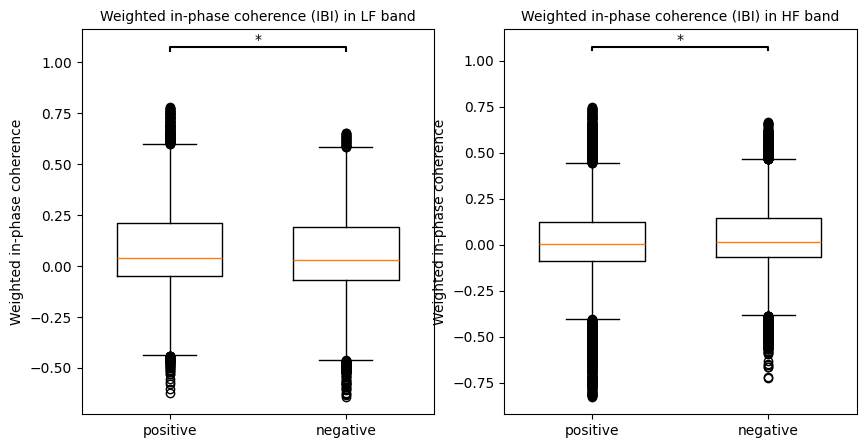

In [2388]:
session = 'NY'
lf_awct_list = []
hf_awct_list = []
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
for condition in conditions_NY_ecg:
    period = 1 / wct_results_ibi[session][condition]['freq']
    lf_period = np.where((period >= 1/0.15) & (period <=1/0.045))
    hf_period = np.where((period >= 1/0.4) & (period < 1/0.15))
    awct_weighted = np.cos(wct_results_ibi[session][condition]['awct']) * wct_results_ibi[session][condition]['wct']
    lf_awct = awct_weighted[lf_period[0], :]
    hf_awct = awct_weighted[hf_period[0], :]
    coi = wct_results_ibi[session][condition]['coi']
    for t in range(lf_awct.shape[1]):
        lf_mask = lf_period > coi[t]
        lf_awct[lf_mask[0], t] = np.nan
        hf_mask = hf_period > coi[t]
        hf_awct[hf_mask[0], t] = np.nan
    lf_awct_list.append(lf_awct)
    hf_awct_list.append(hf_awct)
    lf_awct_flatten = lf_awct.flatten()
    hf_awct_flatten = hf_awct.flatten()
    axes[0].boxplot(lf_awct_flatten[~np.isnan(lf_awct_flatten)], positions=[conditions_full.index(condition)], widths=0.6)
    axes[1].boxplot(hf_awct_flatten[~np.isnan(hf_awct_flatten)], positions=[conditions_full.index(condition)], widths=0.6)

def annotate_boxplot(ax, x1, x2, y, h, col):
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    ax.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)

# Annotate LF plot
y_max = max([np.nanmax(lf) for lf in lf_wct_list])
annotate_boxplot(axes[0], 0, 1, y_max+0.1, 0.02, 'k')
# annotate_boxplot(axes[0], 1, 2, y_max+0.1, 0.02, 'k')
# annotate_boxplot(axes[0], 0, 2, y_max+0.2, 0.02, 'k')

# Annotate HF plot
y_max = max([np.nanmax(hf) for hf in hf_wct_list])
annotate_boxplot(axes[1], 0, 1, y_max+0.1, 0.02, 'k')
# annotate_boxplot(axes[1], 1, 2, y_max+0.1, 0.02, 'k')
# annotate_boxplot(axes[1], 0, 2, y_max+0.2, 0.02, 'k')

for ax in axes:
    ax.set_xticklabels(conditions_NY_ecg)
axes[0].set_title('Weighted in-phase coherence (IBI) in LF band', fontsize=10)
axes[1].set_title('Weighted in-phase coherence (IBI) in HF band', fontsize=10)
axes[0].set_ylabel('Weighted in-phase coherence')
axes[1].set_ylabel('Weighted in-phase coherence')

In [2389]:
array_1 = lf_awct_list[0].flatten()
array_2 = lf_awct_list[1].flatten()
mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided')

MannwhitneyuResult(statistic=61927243.0, pvalue=4.603152790468454e-13)

In [2390]:
print(np.median(array_1[~np.isnan(array_1)]))
print(np.median(array_2[~np.isnan(array_2)]))

0.04201608720528476
0.030919694397223228


In [2391]:
array_1 = hf_awct_list[0].flatten()
array_2 = hf_awct_list[1].flatten()
mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided')

MannwhitneyuResult(statistic=44050885.0, pvalue=1.1154928889000296e-10)

In [2392]:
print(np.median(array_1[~np.isnan(array_1)]))
print(np.median(array_2[~np.isnan(array_2)]))

0.0036792777326981265
0.013534681666669641


In [2404]:
lf_awct_list = []
hf_awct_list = []
lf_wct_list = []
hf_wct_list = []
for session in sessions:
    if session == 'NN':
        conditions = conditions_full
        study = 'S1'
    elif session == 'NY':
        conditions = conditions_NY_ecg
        study = 'S2'
    else:
        conditions = conditions_VM_MG
        if session == 'MG':
            study = 'S3'
        else:
            study = 'S4'
    for condition in conditions:
        period = 1 / wct_results_ibi[session][condition]['freq']
        lf_period = np.where((period >= 1/0.15) & (period <=1/0.045))
        hf_period = np.where((period >= 1/0.4) & (period < 1/0.15))
        awct_weighted = np.cos(wct_results_ibi[session][condition]['awct']) * wct_results_ibi[session][condition]['wct']
        lf_awct = awct_weighted[lf_period[0], :]
        hf_awct = awct_weighted[hf_period[0], :]
        lf_wct = wct_results_ibi[session][condition]['wct'][lf_period[0], :]
        hf_wct = wct_results_ibi[session][condition]['wct'][hf_period[0], :]
        coi = wct_results_ibi[session][condition]['coi']
        for t in range(lf_awct.shape[1]):
            lf_mask = lf_period > coi[t]
            lf_wct[lf_mask[0], t] = np.nan
            lf_awct[lf_mask[0], t] = np.nan
            hf_mask = hf_period > coi[t]
            hf_wct[hf_mask[0], t] = np.nan
            hf_awct[hf_mask[0], t] = np.nan
        lf_wct_list.append(lf_wct)
        hf_wct_list.append(hf_wct)
        lf_awct_list.append(lf_awct)
        hf_awct_list.append(hf_awct)

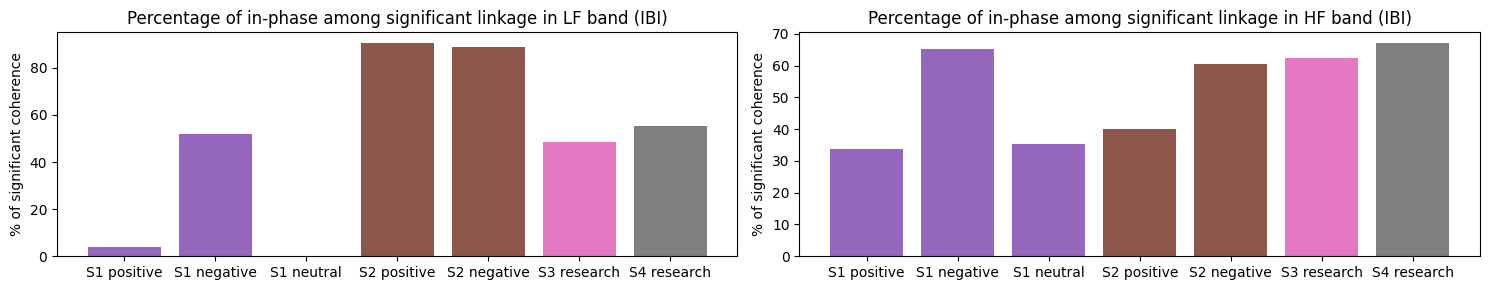

In [2405]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 3))
n = 0
for session in sessions:
    if session == 'NN':
        conditions = conditions_full
        study = 'S1'
        color = 'C4'
    elif session == 'NY':
        conditions = conditions_NY_ecg
        study = 'S2'
        color = 'C5'
    else:
        conditions = conditions_VM_MG
        if session == 'MG':
            study = 'S3'
            color = 'C6'
        else:
            study = 'S4'
            color = 'C7'
    for condition in conditions:
        mask_lf = lf_wct_list[n] > percentile_95_ibi
        mask_hf = hf_wct_list[n] > percentile_95_ibi
        masked_array_lf = lf_awct_list[n][mask_lf].flatten()
        masked_array_hf = hf_awct_list[n][mask_hf].flatten()
        per_in_phase_lf = np.sum(masked_array_lf > 0) / len(masked_array_lf[~np.isnan(masked_array_lf)]) * 100
        per_anti_phase_lf = np.sum(masked_array_lf < 0) / len(masked_array_lf[~np.isnan(masked_array_lf)]) * 100
        per_in_phase_hf = np.sum(masked_array_hf > 0) / len(masked_array_hf[~np.isnan(masked_array_hf)]) * 100
        per_anti_phase_hf = np.sum(masked_array_hf < 0) / len(masked_array_hf[~np.isnan(masked_array_hf)]) * 100
        axes[0].bar(f'{study} {condition}', per_in_phase_lf, color=color)
        #axes[0].bar(f'{study} {condition} anti-phase', per_anti_phase_lf, color=color)
        axes[1].bar(f'{study} {condition}', per_in_phase_hf, color=color)
        #axes[1].bar(f'{study} {condition} anti-phase', per_anti_phase_hf, color=color)
        n += 1
axes[0].set_ylabel('% of significant coherence')
axes[1].set_ylabel('% of significant coherence')
axes[0].set_title('Percentage of in-phase among significant linkage in LF band (IBI)')
axes[1].set_title('Percentage of in-phase among significant linkage in HF band (IBI)')
plt.tight_layout()

## **HRV analysis**

### Calculate second-by-second RMSSD

In [1526]:
ibi_dfs_p1 = {}
ibi_dfs_p2 = {}

for session in sessions:
    if session == 'NN':
        conditions = conditions_full
    elif session == 'NY':
        conditions = conditions_NY_ecg
    else:
        conditions = conditions_VM_MG
    ibi_dfs_p1[session] = {}
    ibi_dfs_p2[session] = {}
    for condition in conditions:
        ibi_dfs_p1[session][condition] = mw_p1[session][condition][['timestamp', 'IBI']].set_index('timestamp')
        ibi_dfs_p2[session][condition] = mw_p2[session][condition][['timestamp', 'IBI']].set_index('timestamp')

In [1527]:
window_len_sec = 30
window_step_size_sec = 1
hrv_p1 = {}
hrv_p2 = {}
rmssd_concat = {}

for session in sessions:
    if session == 'NN':
        conditions = conditions_full
    elif session == 'NY':
        conditions = conditions_NY_ecg
    else:
        conditions = conditions_VM_MG
    hrv_p1[session] = {}
    hrv_p2[session] = {}
    rmssd_concat[session] = {}
    for condition in conditions:
        hrv_p1[session][condition] = flirt.get_hrv_features(ibi_dfs_p1[session][condition]['IBI'], window_length=window_len_sec, window_step_size=window_step_size_sec, domains=['td'], clean_data=True)
        hrv_p2[session][condition] = flirt.get_hrv_features(ibi_dfs_p2[session][condition]['IBI'], window_length=window_len_sec, window_step_size=window_step_size_sec, domains=['td'], clean_data=True)
        rmssd_concat[session][condition] = pd.merge(hrv_p1[session][condition]['hrv_rmssd'], hrv_p2[session][condition]['hrv_rmssd'], on='datetime', how='inner', suffixes=('_p1', '_p2')) 

HRV features:   2%|▏         | 10/658 [00:00<00:29, 21.63it/s]0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger war

In [1528]:
for session in sessions:
    if session == 'NN':
        conditions = conditions_full
    elif session == 'NY':
        conditions = conditions_NY_ecg
    else:
        conditions = conditions_VM_MG
    for condition in conditions:
        time_offset_p1 = mw_p1[session][condition]['time'].iloc[0]
        start_time_p1 = mw_p1[session][condition]['timestamp'].iloc[0]
        df = rmssd_concat[session][condition].reset_index()
        df['time'] = (df['datetime'] - pd.to_datetime(start_time_p1)).dt.total_seconds() * 1000 + time_offset_p1
        df = df.drop(columns=['datetime'])
        rmssd_concat[session][condition] = df

### Standardize HRV

In [1353]:
standardized_rmssd = {}
for session in sessions:
    standardized_rmssd[session] = {}
    if session == 'NN':
        conditions = conditions_full
    elif session == 'NY':
        conditions = conditions_NY_ecg
    else:
        conditions = conditions_VM_MG
    for condition in conditions:
        df = rmssd_concat[session][condition].copy()
        df['hrv_rmssd_p1'] = (df['hrv_rmssd_p1'] - np.mean(df['hrv_rmssd_p1'])) / np.std(df['hrv_rmssd_p1'])
        df['hrv_rmssd_p2'] = (df['hrv_rmssd_p2'] - np.mean(df['hrv_rmssd_p2'])) / np.std(df['hrv_rmssd_p2'])
        standardized_rmssd[session][condition] = df

### Surrogate analysis

In [1535]:
standardized_rmssd_all = {}

for session in standardized_rmssd.keys():
    person = session
    standardized_rmssd_all[session] = {}
    for condition in standardized_rmssd[session].keys():
        standardized_rmssd_all[session][condition] = {}
        standardized_rmssd_all[session][condition][person] = standardized_rmssd[session][condition]['hrv_rmssd_p1']
for session in standardized_rmssd.keys():
    person = 'YW'
    for condition in standardized_rmssd[session].keys():
        standardized_rmssd_all[session][condition][person] = standardized_rmssd[session][condition]['hrv_rmssd_p2']

In [2096]:
wct_surrogate = []

for pair_i in range(len(surrogate_pairs)):
    print(f'Processing pair {pair_i+1}/{len(surrogate_pairs)}')
    session1 = surrogate_pairs.loc[pair_i, 'session1']
    condition1 = surrogate_pairs.loc[pair_i, 'condition1']
    person1 = surrogate_pairs.loc[pair_i, 'person1']
    session2 = surrogate_pairs.loc[pair_i, 'session2']
    condition2 = surrogate_pairs.loc[pair_i, 'condition2']
    person2 = surrogate_pairs.loc[pair_i, 'person2']
    print(f'    {session1} {condition1} {person1} vs {session2} {condition2} {person2}')
    
    max_idx = min(len(standardized_rmssd_all[session1][condition1][person1]), len(standardized_rmssd_all[session2][condition2][person2]))
    wct, awct, coi, freq, sig = wavelet.wct(standardized_rmssd_all[session1][condition1][person1][:max_idx], standardized_rmssd_all[session2][condition2][person2][:max_idx], dt, dj=dj, s0=s0, J=-1, sig=False, wavelet=mother, normalize=True)
    period = 1 / freq
    for t in range(wct.shape[1]):
        mask = period > coi[t]
        wct[mask, t] = np.nan
    wct_surrogate.append(wct)

Processing pair 1/59
    NY positive NY vs VM research VM
Processing pair 2/59
    NN negative YW vs NN neutral NN
Processing pair 3/59
    NN neutral NN vs NY negative YW
Processing pair 4/59
    NN neutral NN vs NY positive NY
Processing pair 5/59
    NN neutral NN vs VM research VM
Processing pair 6/59
    NN negative YW vs MG research MG
Processing pair 7/59
    NN neutral YW vs MG research MG
Processing pair 8/59
    NN positive NN vs NN neutral YW
Processing pair 9/59
    NY negative NY vs VM research VM
Processing pair 10/59
    NN positive YW vs NY positive NY
Processing pair 11/59
    NN positive NN vs NY negative NY
Processing pair 12/59
    NN negative NN vs NN neutral YW
Processing pair 13/59
    NN negative NN vs MG research YW
Processing pair 14/59
    MG research MG vs VM research VM
Processing pair 15/59
    NN positive NN vs MG research YW
Processing pair 16/59
    NN negative NN vs NY negative NY
Processing pair 17/59
    NN positive YW vs VM research VM
Processing pa

95th percentile: 0.6512944163135908


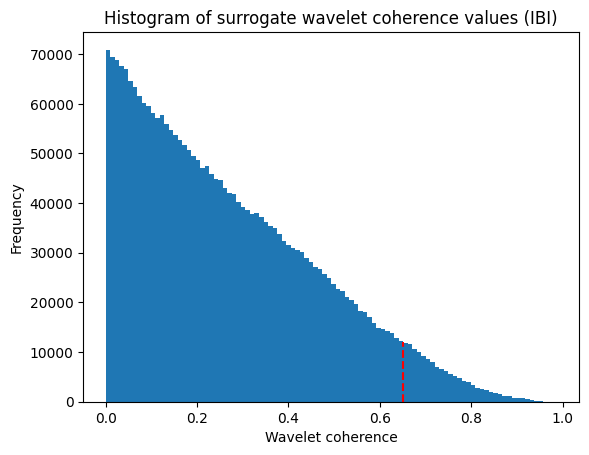

In [2097]:
wct_surrogate_flattened = [wct.flatten() for wct in wct_surrogate]
wct_surrogate_concatenated = np.concatenate(wct_surrogate_flattened)
wct_surrogate_concatenated = wct_surrogate_concatenated[~np.isnan(wct_surrogate_concatenated)]
percentile_95_hrv = np.percentile(wct_surrogate_concatenated, 95)
print("95th percentile:", percentile_95_hrv)
plt.hist(wct_surrogate_concatenated, bins=100)
plt.vlines(percentile_95_hrv, 0, 12000, colors='r', linestyles='dashed')
plt.title('Histogram of surrogate wavelet coherence values (IBI)')
plt.xlabel('Wavelet coherence')
plt.ylabel('Frequency')
# plt.ylim(0, 12000)
plt.show()

In [2098]:
with open('../data/surrogate_wavelet_coherence_hrv.npy', 'wb') as f:
    np.save(f, wct_surrogate_concatenated)
with open('../data/hrv_95_percentile.txt', 'w') as f:
    f.write(str(percentile_95_hrv))

### Cross wavelet transform

In [2099]:
session = 'NY'
condition = 'negative'
wct_rmssd, awct_rmssd, coi_rmssd, freq_rmssd, sig_rmssd = wavelet.wct(standardized_rmssd[session][condition]['hrv_rmssd_p1'], standardized_rmssd[session][condition]['hrv_rmssd_p2'], dt, dj=dj, s0=s0, J=-1, sig=False, wavelet=mother, normalize=True)

In [2100]:
t = standardized_rmssd[session][condition]['time'].values

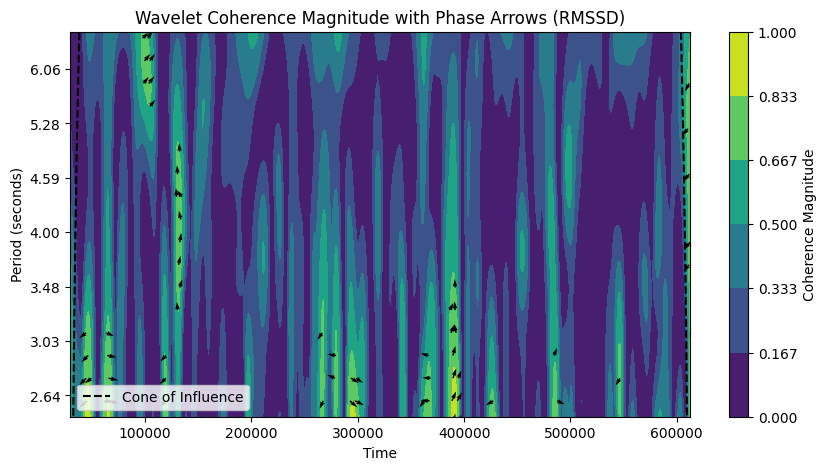

In [2101]:
plot_wavelet_result(threshold=percentile_95_hrv, t=t, wct=wct_rmssd, awct=awct_rmssd, coi=coi_rmssd, freq=freq_rmssd, modality='RMSSD', ylim_low=1/0.4, ylim_high=1/0.15)
plt.savefig(f'../result/{session}_{condition}_rmssd_HF.png')

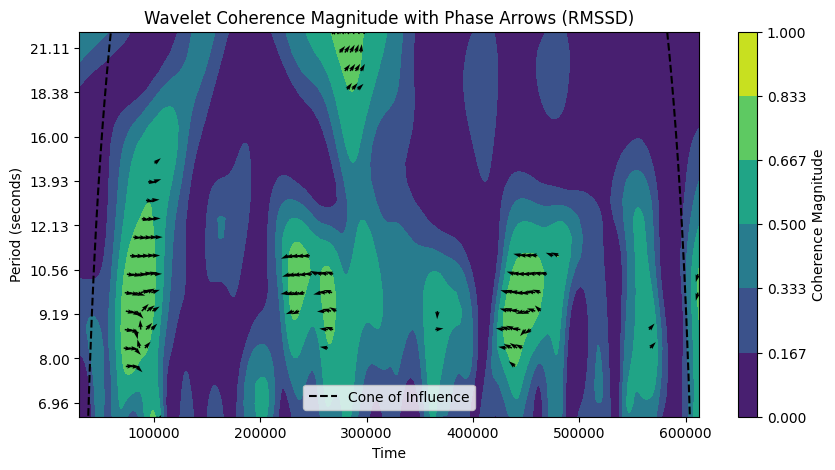

In [2102]:
plot_wavelet_result(threshold=percentile_95_hrv, t=t, wct=wct_rmssd, awct=awct_rmssd, coi=coi_rmssd, freq=freq_rmssd, modality='RMSSD', ylim_low=1/0.15, ylim_high=1/0.045)
plt.savefig(f'../result/{session}_{condition}_rmssd_LF.png')

### Summarizing results

In [2103]:
from scipy.stats import rankdata
def print_mean_rank(group1, group2):
    all_data = group1 + group2
    ranks = rankdata(all_data)

    # Split ranks back into groups
    ranks_group1 = ranks[:len(group1)]
    ranks_group2 = ranks[len(group1):]

    # Compute mean ranks
    mean_rank1 = np.mean(ranks_group1)
    mean_rank2 = np.mean(ranks_group2)

    print("Group 1 Mean Rank:", mean_rank1)
    print("Group 2 Mean Rank:", mean_rank2)

In [2104]:
wct_results_hrv = {}
for session in sessions:
    wct_results_hrv[session] = {}
    if session == 'NN':
        conditions = conditions_full
    elif session == 'NY':
        conditions = conditions_NY_ecg
    else:
        conditions = conditions_VM_MG
    for condition in conditions:
        wct_hrv, awct_hrv, coi_hrv, freq_hrv, sig_hrv = wavelet.wct(standardized_rmssd[session][condition]['hrv_rmssd_p1'], standardized_rmssd[session][condition]['hrv_rmssd_p2'], dt, dj=dj, s0=s0, J=-1, sig=False, wavelet=mother, normalize=True)
        wct_results_hrv[session][condition] = {}
        wct_results_hrv[session][condition]['wct'] = wct_hrv
        wct_results_hrv[session][condition]['awct'] = awct_hrv
        wct_results_hrv[session][condition]['coi'] = coi_hrv
        wct_results_hrv[session][condition]['freq'] = freq_hrv
        wct_results_hrv[session][condition]['sig'] = sig_hrv

Text(0.5, 1.0, 'Wavelet Coherence (RMSSD) in HF band')

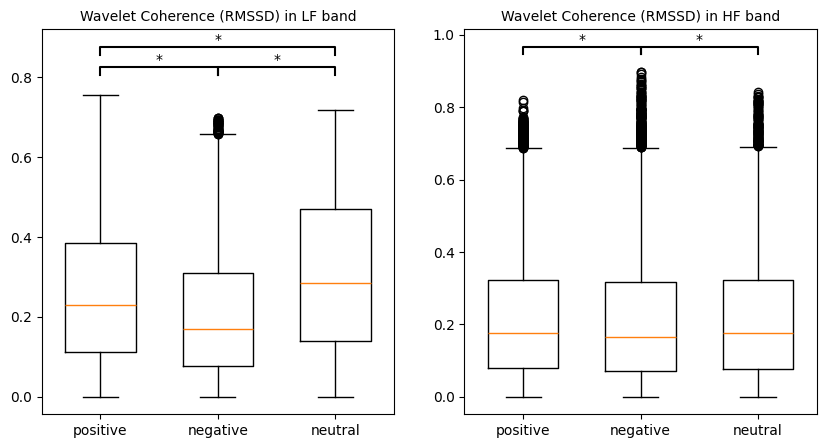

In [2129]:
session = 'NN'
lf_wct_list = []
hf_wct_list = []
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
for condition in conditions_full:
    period = 1 / wct_results_hrv[session][condition]['freq']
    lf_period = np.where((period >= 1/0.15) & (period <=1/0.045))
    hf_period = np.where((period >= 1/0.4) & (period < 1/0.15))
    lf_wct = wct_results_hrv[session][condition]['wct'][lf_period[0], :]
    hf_wct = wct_results_hrv[session][condition]['wct'][hf_period[0], :]
    coi = wct_results_hrv[session][condition]['coi']
    for t in range(lf_wct.shape[1]):
        lf_mask = lf_period > coi[t]
        lf_wct[lf_mask[0], t] = np.nan
        hf_mask = hf_period > coi[t]
        hf_wct[hf_mask[0], t] = np.nan
    lf_wct_list.append(lf_wct)
    hf_wct_list.append(hf_wct)
    lf_wct_flatten = lf_wct.flatten()
    hf_wct_flatten = hf_wct.flatten()
    axes[0].boxplot(lf_wct_flatten[~np.isnan(lf_wct_flatten)], positions=[conditions_full.index(condition)], widths=0.6)
    axes[1].boxplot(hf_wct_flatten[~np.isnan(hf_wct_flatten)], positions=[conditions_full.index(condition)], widths=0.6)

# Annotate LF plot
y_max = max([np.nanmax(lf) for lf in lf_wct_list])
annotate_boxplot(axes[0], 0, 1, y_max+0.05, 0.02, 'k')
annotate_boxplot(axes[0], 1, 2, y_max+0.05, 0.02, 'k')
annotate_boxplot(axes[0], 0, 2, y_max+0.1, 0.02, 'k')

# Annotate HF plot
y_max = max([np.nanmax(hf) for hf in hf_wct_list])
annotate_boxplot(axes[1], 0, 1, y_max+0.05, 0.02, 'k')
annotate_boxplot(axes[1], 1, 2, y_max+0.05, 0.02, 'k')
# annotate_boxplot(axes[1], 0, 2, y_max+0.1, 0.02, 'k')

for ax in axes:
    ax.set_xticklabels(conditions_full)
axes[0].set_title('Wavelet Coherence (RMSSD) in LF band', fontsize=10)
axes[1].set_title('Wavelet Coherence (RMSSD) in HF band', fontsize=10)

In [2130]:
array_1 = lf_wct_list[0].flatten()
array_2 = lf_wct_list[1].flatten()
array_3 = lf_wct_list[2].flatten()
print(f'% of significant coherence in LF band for {conditions_full[0]}: {np.sum(array_1 > percentile_95_hrv) / len(array_1[~np.isnan(array_1)]) * 100:.2f}%')
print(f'% of significant coherence in LF band for {conditions_full[1]}: {np.sum(array_2 > percentile_95_hrv) / len(array_2[~np.isnan(array_2)]) * 100:.2f}%')
print(f'% of significant coherence in LF band for {conditions_full[2]}: {np.sum(array_3 > percentile_95_hrv) / len(array_3[~np.isnan(array_3)]) * 100:.2f}%')

% of significant coherence in LF band for positive: 4.01%
% of significant coherence in LF band for negative: 0.28%
% of significant coherence in LF band for neutral: 2.25%


In [2131]:
array_1 = lf_wct_list[0].flatten()
array_2 = lf_wct_list[1].flatten()
array_3 = lf_wct_list[2].flatten()
kruskal(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], array_3[~np.isnan(array_3)])

KruskalResult(statistic=1978.756382812382, pvalue=0.0)

In [1992]:
array_1 = lf_wct_list[0].flatten()
array_2 = lf_wct_list[1].flatten()
print(mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided'))
aw = calculate_aw(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)])
print(f'aw: {aw}')
print(f'da: {convert_aw_to_da(aw, np.var(array_1[~np.isnan(array_1)]), np.var(array_2[~np.isnan(array_2)]))}')

MannwhitneyuResult(statistic=133210730.0, pvalue=3.421063672496241e-138)
aw: 0.5842011661856167
da: 0.15036834310248268


In [1993]:
array_1 = lf_wct_list[1].flatten()
array_2 = lf_wct_list[2].flatten()
print(mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided'))
aw = calculate_aw(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)])
print(f'aw: {aw}')
print(f'da: {convert_aw_to_da(aw, np.var(array_1[~np.isnan(array_1)]), np.var(array_2[~np.isnan(array_2)]))}')

MannwhitneyuResult(statistic=73800177.0, pvalue=0.0)
aw: 0.34990535154060043
da: -0.2726434113875458


In [1994]:
array_1 = lf_wct_list[0].flatten()
array_2 = lf_wct_list[2].flatten()
print(mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided'))
aw = calculate_aw(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)])
print(f'aw: {aw}')
print(f'da: {convert_aw_to_da(aw, np.var(array_1[~np.isnan(array_1)]), np.var(array_2[~np.isnan(array_2)]))}')

MannwhitneyuResult(statistic=58209960.0, pvalue=6.897134510080973e-67)
aw: 0.4344130995139973
da: -0.11677843331514176


In [2132]:
array_1 = hf_wct_list[0].flatten()
array_2 = hf_wct_list[1].flatten()
array_3 = hf_wct_list[2].flatten()
print(f'% of significant coherence in HF band for {conditions_full[0]}: {np.sum(array_1 > percentile_95_hrv) / len(array_1[~np.isnan(array_1)]) * 100:.2f}%')
print(f'% of significant coherence in HF band for {conditions_full[1]}: {np.sum(array_2 > percentile_95_hrv) / len(array_2[~np.isnan(array_2)]) * 100:.2f}%')
print(f'% of significant coherence in HF band for {conditions_full[2]}: {np.sum(array_3 > percentile_95_hrv) / len(array_3[~np.isnan(array_3)]) * 100:.2f}%')

% of significant coherence in HF band for positive: 2.79%
% of significant coherence in HF band for negative: 2.59%
% of significant coherence in HF band for neutral: 1.80%


In [1995]:
array_1 = lf_wct_list[0].flatten()
array_2 = lf_wct_list[1].flatten()
array_3 = lf_wct_list[2].flatten()
kruskal(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], array_3[~np.isnan(array_3)])

KruskalResult(statistic=1978.756382812382, pvalue=0.0)

In [1996]:
array_1 = hf_wct_list[0].flatten()
array_2 = hf_wct_list[1].flatten()
print(mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided'))
aw = calculate_aw(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)])
print(f'aw: {aw}')
print(f'da: {convert_aw_to_da(aw, np.var(array_1[~np.isnan(array_1)]), np.var(array_2[~np.isnan(array_2)]))}')

MannwhitneyuResult(statistic=89096820.0, pvalue=3.0597729712653227e-06)
aw: 0.5168125290130116
da: 0.02980825797251563


In [1997]:
array_1 = hf_wct_list[1].flatten()
array_2 = hf_wct_list[2].flatten()
print(mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided'))
aw = calculate_aw(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)])
print(f'aw: {aw}')
print(f'da: {convert_aw_to_da(aw, np.var(array_1[~np.isnan(array_1)]), np.var(array_2[~np.isnan(array_2)]))}')

MannwhitneyuResult(statistic=78750452.0, pvalue=0.010170917886707587)
aw: 0.49053710153113533
da: -0.016774123951062578


In [1998]:
array_1 = hf_wct_list[0].flatten()
array_2 = hf_wct_list[2].flatten()
print(mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided'))
aw = calculate_aw(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)])
print(f'aw: {aw}')
print(f'da: {convert_aw_to_da(aw, np.var(array_1[~np.isnan(array_1)]), np.var(array_2[~np.isnan(array_2)]))}')

MannwhitneyuResult(statistic=53379451.0, pvalue=0.06361013409128954)
aw: 0.5074800649931023
da: 0.013258846916339159


Text(0.5, 1.0, 'Wavelet Coherence (RMSSD) in HF band')

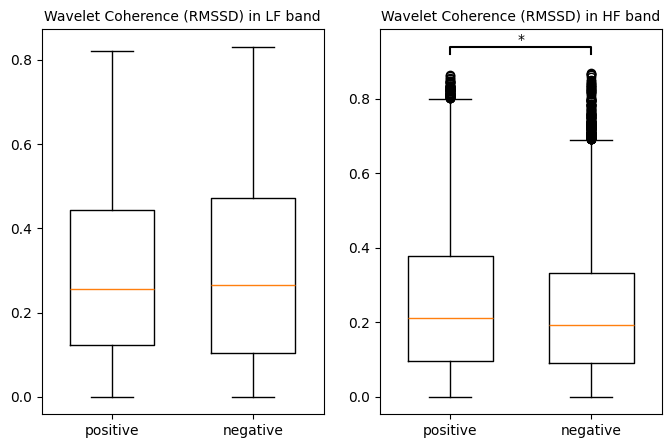

In [2133]:
session = 'NY'
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 5))
lf_wct_list = []
hf_wct_list = []
for condition in conditions_NY_ecg:
    period = 1 / wct_results_hrv[session][condition]['freq']
    lf_period = np.where((period >= 1/0.15) & (period <=1/0.045))
    hf_period = np.where((period >= 1/0.4) & (period < 1/0.15))
    lf_wct = wct_results_hrv[session][condition]['wct'][lf_period[0], :]
    hf_wct = wct_results_hrv[session][condition]['wct'][hf_period[0], :]
    coi = wct_results_hrv[session][condition]['coi']
    for t in range(lf_wct.shape[1]):
        lf_mask = lf_period > coi[t]
        lf_wct[lf_mask[0], t] = np.nan
        hf_mask = hf_period > coi[t]
        hf_wct[hf_mask[0], t] = np.nan
    lf_wct_list.append(lf_wct)
    hf_wct_list.append(hf_wct)
    lf_wct_flatten = lf_wct.flatten()
    hf_wct_flatten = hf_wct.flatten()
    axes[0].boxplot(lf_wct_flatten[~np.isnan(lf_wct_flatten)], positions=[conditions_full.index(condition)], widths=0.6)
    axes[1].boxplot(hf_wct_flatten[~np.isnan(hf_wct_flatten)], positions=[conditions_full.index(condition)], widths=0.6)

# Annotate LF plot
# y_max = max([np.nanmax(lf) for lf in lf_wct_list])
# annotate_boxplot(axes[0], 0, 1, y_max+0.05, 0.02, 'k')
# annotate_boxplot(axes[0], 1, 2, y_max+0.05, 0.02, 'k')
# annotate_boxplot(axes[0], 0, 2, y_max+0.1, 0.02, 'k')

# Annotate HF plot
y_max = max([np.nanmax(hf) for hf in hf_wct_list])
annotate_boxplot(axes[1], 0, 1, y_max+0.05, 0.02, 'k')
#annotate_boxplot(axes[1], 1, 2, y_max+0.05, 0.02, 'k')
#annotate_boxplot(axes[1], 0, 2, y_max+0.1, 0.02, 'k')

for ax in axes:
    ax.set_xticklabels(conditions_NY_ecg)
axes[0].set_title('Wavelet Coherence (RMSSD) in LF band', fontsize=10)
axes[1].set_title('Wavelet Coherence (RMSSD) in HF band', fontsize=10)

In [2134]:
array_1 = lf_wct_list[0].flatten()
array_2 = lf_wct_list[1].flatten()
print(f'% of significant coherence in LF band for {conditions_full[0]}: {np.sum(array_1 > percentile_95_hrv) / len(array_1[~np.isnan(array_1)]) * 100:.2f}%')
print(f'% of significant coherence in LF band for {conditions_full[1]}: {np.sum(array_2 > percentile_95_hrv) / len(array_2[~np.isnan(array_2)]) * 100:.2f}%')

% of significant coherence in LF band for positive: 4.30%
% of significant coherence in LF band for negative: 6.71%


In [1553]:
array_1 = lf_wct_list[0].flatten()
array_2 = lf_wct_list[1].flatten()
mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided')

MannwhitneyuResult(statistic=51852287.0, pvalue=0.29480814577197556)

In [2135]:
array_1 = hf_wct_list[0].flatten()
array_2 = hf_wct_list[1].flatten()
print(f'% of significant coherence in HF band for {conditions_full[0]}: {np.sum(array_1 > percentile_95_hrv) / len(array_1[~np.isnan(array_1)]) * 100:.2f}%')
print(f'% of significant coherence in HF band for {conditions_full[1]}: {np.sum(array_2 > percentile_95_hrv) / len(array_2[~np.isnan(array_2)]) * 100:.2f}%')

% of significant coherence in HF band for positive: 5.79%
% of significant coherence in HF band for negative: 2.77%


In [2001]:
array_1 = hf_wct_list[0].flatten()
array_2 = hf_wct_list[1].flatten()
print(mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided'))
aw = calculate_aw(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)])
print(f'aw: {aw}')
print(f'da: {convert_aw_to_da(aw, np.var(array_1[~np.isnan(array_1)]), np.var(array_2[~np.isnan(array_2)]))}')

MannwhitneyuResult(statistic=44414850.0, pvalue=1.214940465689443e-11)
aw: 0.5289123030311547
da: 0.05129066470721487


Text(0.5, 1.0, 'Wavelet Coherence (RMSSD) in HF band')

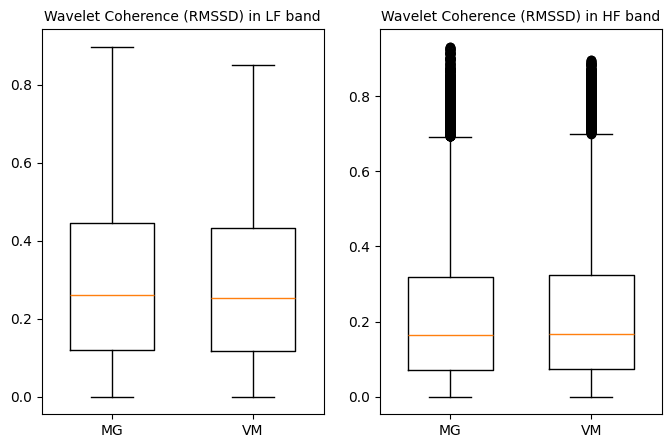

In [2136]:
condition = 'research'
sessions_research = ['MG', 'VM']
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 5))
lf_wct_list = []
hf_wct_list = []
for session in sessions_research:
    period = 1 / wct_results_hrv[session][condition]['freq']
    lf_period = np.where((period >= 1/0.15) & (period <=1/0.045))
    hf_period = np.where((period >=1/0.4) & (period < 1/0.15))
    lf_wct = wct_results_hrv[session][condition]['wct'][lf_period[0], :]
    hf_wct = wct_results_hrv[session][condition]['wct'][hf_period[0], :]
    coi = wct_results_hrv[session][condition]['coi']
    for t in range(lf_wct.shape[1]):
        lf_mask = lf_period > coi[t]
        lf_wct[lf_mask[0], t] = np.nan
        hf_mask = hf_period > coi[t]
        hf_wct[hf_mask[0], t] = np.nan
    lf_wct_list.append(lf_wct)
    hf_wct_list.append(hf_wct)
    lf_wct_flatten = lf_wct.flatten()
    hf_wct_flatten = hf_wct.flatten()
    axes[0].boxplot(lf_wct_flatten[~np.isnan(lf_wct_flatten)], positions=[sessions_research.index(session)], widths=0.6)
    axes[1].boxplot(hf_wct_flatten[~np.isnan(hf_wct_flatten)], positions=[sessions_research.index(session)], widths=0.6)
for ax in axes:
    ax.set_xticklabels(sessions_research)
axes[0].set_title('Wavelet Coherence (RMSSD) in LF band', fontsize=10)
axes[1].set_title('Wavelet Coherence (RMSSD) in HF band', fontsize=10)

In [2137]:
array_1 = lf_wct_list[0].flatten()
array_2 = lf_wct_list[1].flatten()
print(f'% of significant coherence in LF band for {conditions_VM_MG[0]}: {np.sum(array_1 > percentile_95_hrv) / len(array_1[~np.isnan(array_1)]) * 100:.2f}%')
print(f'% of significant coherence in LF band for {conditions_VM_MG[0]}: {np.sum(array_2 > percentile_95_hrv) / len(array_2[~np.isnan(array_2)]) * 100:.2f}%')

% of significant coherence in LF band for research: 5.72%
% of significant coherence in LF band for research: 4.19%


In [1596]:
array_1 = lf_wct_list[0].flatten()
array_2 = lf_wct_list[1].flatten()
mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided')

MannwhitneyuResult(statistic=694377252.0, pvalue=1.1599978789707567e-07)

In [1597]:
print_mean_rank(list(array_1[~np.isnan(array_1)]), list(array_2[~np.isnan(array_2)]))

Group 1 Mean Rank: 37746.43128514607
Group 2 Mean Rank: 36897.31951290229


In [2138]:
array_1 = hf_wct_list[0].flatten()
array_2 = hf_wct_list[1].flatten()
print(f'% of significant coherence in HF band for {conditions_VM_MG[0]}: {np.sum(array_1 > percentile_95_hrv) / len(array_1[~np.isnan(array_1)]) * 100:.2f}%')
print(f'% of significant coherence in HF band for {conditions_VM_MG[0]}: {np.sum(array_2 > percentile_95_hrv) / len(array_2[~np.isnan(array_2)]) * 100:.2f}%')

% of significant coherence in HF band for research: 3.94%
% of significant coherence in HF band for research: 3.71%


In [1598]:
array_1 = hf_wct_list[0].flatten()
array_2 = hf_wct_list[1].flatten()
mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided')

MannwhitneyuResult(statistic=468593724.0, pvalue=0.11229227221118494)

Text(0, 0.5, 'Wavelet Coherence')

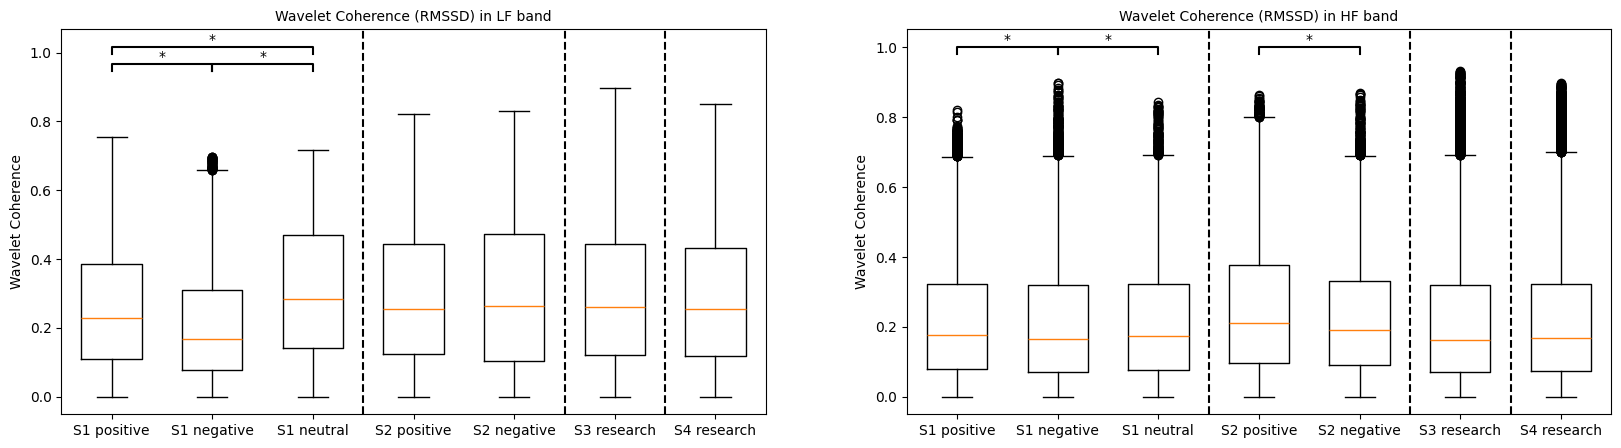

In [2408]:
lf_wct_list = []
hf_wct_list = []
pos = 0
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))
ticklabels = []
for session in sessions:
    if session == 'NN':
        conditions = conditions_full
        study = 'S1'
    elif session == 'NY':
        conditions = conditions_NY_ecg
        study = 'S2'
    else:
        conditions = conditions_VM_MG
        if session == 'MG':
            study = 'S3'
        else:
            study = 'S4'
    for condition in conditions:
        period = 1 / wct_results_hrv[session][condition]['freq']
        lf_period = np.where((period >= 1/0.15) & (period <=1/0.045))
        hf_period = np.where((period >=1/0.4) & (period < 1/0.15))
        lf_wct = wct_results_hrv[session][condition]['wct'][lf_period[0], :]
        hf_wct = wct_results_hrv[session][condition]['wct'][hf_period[0], :]
        coi = wct_results_hrv[session][condition]['coi']
        for t in range(lf_wct.shape[1]):
            lf_mask = lf_period > coi[t]
            lf_wct[lf_mask[0], t] = np.nan
            hf_mask = hf_period > coi[t]
            hf_wct[hf_mask[0], t] = np.nan
        lf_wct_list.append(lf_wct)
        hf_wct_list.append(hf_wct)
        lf_wct_flatten = lf_wct.flatten()
        hf_wct_flatten = hf_wct.flatten()
        axes[0].boxplot(lf_wct_flatten[~np.isnan(lf_wct_flatten)], positions=[pos], widths=0.6)
        axes[1].boxplot(hf_wct_flatten[~np.isnan(hf_wct_flatten)], positions=[pos], widths=0.6)
        ticklabels.append(f'{study} {condition}')
        pos += 1

# Annotate LF plot
y_max = max([np.nanmax(lf) for lf in lf_wct_list])
annotate_boxplot(axes[0], 0, 1, y_max+0.05, 0.02, 'k')
annotate_boxplot(axes[0], 1, 2, y_max+0.05, 0.02, 'k')
annotate_boxplot(axes[0], 0, 2, y_max+0.1, 0.02, 'k')

# Annotate HF plot
y_max = max([np.nanmax(hf) for hf in hf_wct_list])
annotate_boxplot(axes[1], 0, 1, y_max+0.05, 0.02, 'k')
annotate_boxplot(axes[1], 1, 2, y_max+0.05, 0.02, 'k')
annotate_boxplot(axes[1], 3, 4, y_max+0.05, 0.02, 'k')

for ax in axes:
    ax.set_xticklabels(ticklabels)
axes[0].set_title('Wavelet Coherence (RMSSD) in LF band', fontsize=10)
axes[1].set_title('Wavelet Coherence (RMSSD) in HF band', fontsize=10)

axes[0].axvline(x=2.5, color='black', linestyle='--')
axes[0].axvline(x=4.5, color='black', linestyle='--')
axes[0].axvline(x=5.5, color='black', linestyle='--')
axes[1].axvline(x=2.5, color='black', linestyle='--')
axes[1].axvline(x=4.5, color='black', linestyle='--')
axes[1].axvline(x=5.5, color='black', linestyle='--')

axes[0].set_ylabel('Wavelet Coherence')
axes[1].set_ylabel('Wavelet Coherence')

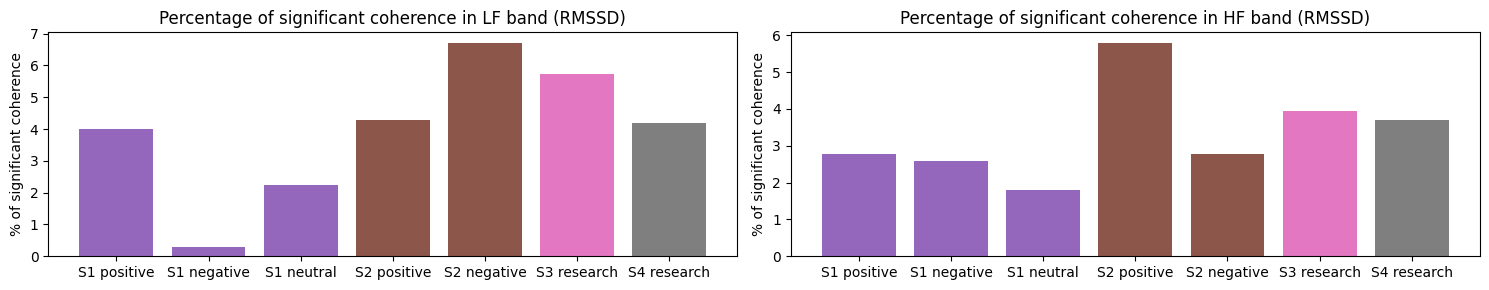

In [2409]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 3))
n = 0
for session in sessions:
    if session == 'NN':
        conditions = conditions_full
        study = 'S1'
        color = 'C4'
    elif session == 'NY':
        conditions = conditions_NY_ecg
        study = 'S2'
        color = 'C5'
    else:
        conditions = conditions_VM_MG
        if session == 'MG':
            study = 'S3'
            color = 'C6'
        else:
            study = 'S4'
            color = 'C7'
    for condition in conditions:
        array_lf = lf_wct_list[n].flatten()
        array_hf = hf_wct_list[n].flatten()
        sig_per_lf = np.sum(array_lf > percentile_95_hrv) / len(array_lf[~np.isnan(array_lf)]) * 100
        sig_per_hf = np.sum(array_hf > percentile_95_hrv) / len(array_hf[~np.isnan(array_hf)]) * 100
        axes[0].bar(f'{study} {condition}', sig_per_lf, color=color)
        axes[1].bar(f'{study} {condition}', sig_per_hf, color=color)
        n += 1
axes[0].set_ylabel('% of significant coherence')
axes[1].set_ylabel('% of significant coherence')
axes[0].set_title('Percentage of significant coherence in LF band (RMSSD)')
axes[1].set_title('Percentage of significant coherence in HF band (RMSSD)')
plt.tight_layout()

Text(0, 0.5, 'Weighted in-phase coherence')

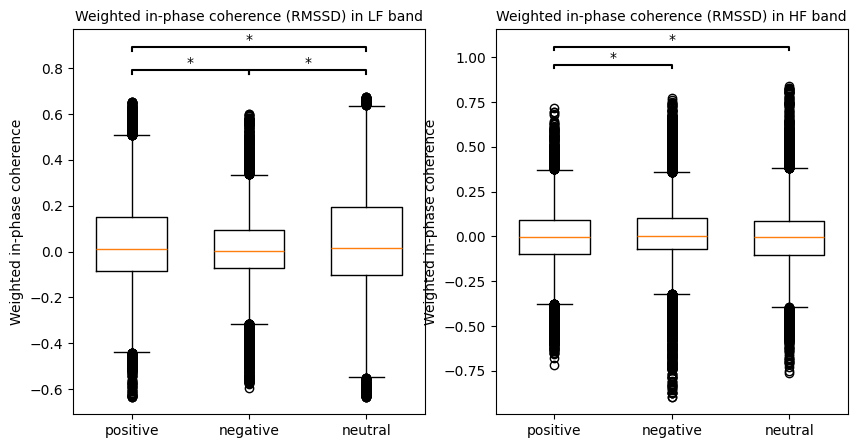

In [1914]:
session = 'NN'
lf_awct_list = []
hf_awct_list = []
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
for condition in conditions_full:
    period = 1 / wct_results_hrv[session][condition]['freq']
    lf_period = np.where((period >= 1/0.15) & (period <=1/0.045))
    hf_period = np.where((period >= 1/0.4) & (period < 1/0.15))
    weighted_awct = np.cos(wct_results_hrv[session][condition]['awct']) * wct_results_hrv[session][condition]['wct']
    lf_awct = weighted_awct[lf_period[0], :]
    hf_awct = weighted_awct[hf_period[0], :]
    coi = wct_results_hrv[session][condition]['coi']
    for t in range(lf_awct.shape[1]):
        lf_mask = lf_period > coi[t]
        lf_awct[lf_mask[0], t] = np.nan
        hf_mask = hf_period > coi[t]
        hf_awct[hf_mask[0], t] = np.nan
    lf_awct_list.append(lf_awct)
    hf_awct_list.append(hf_awct)
    lf_awct_flatten = lf_awct.flatten()
    hf_awct_flatten = hf_awct.flatten()
    axes[0].boxplot(lf_awct_flatten[~np.isnan(lf_awct_flatten)], positions=[conditions_full.index(condition)], widths=0.6)
    axes[1].boxplot(hf_awct_flatten[~np.isnan(hf_awct_flatten)], positions=[conditions_full.index(condition)], widths=0.6)

# Annotate LF plot
y_max = max([np.nanmax(lf) for lf in lf_awct_list])
annotate_boxplot(axes[0], 0, 1, y_max+0.1, 0.02, 'k')
annotate_boxplot(axes[0], 1, 2, y_max+0.1, 0.02, 'k')
annotate_boxplot(axes[0], 0, 2, y_max+0.2, 0.02, 'k')

# Annotate HF plot
y_max = max([np.nanmax(hf) for hf in hf_awct_list])
annotate_boxplot(axes[1], 0, 1, y_max+0.1, 0.02, 'k')
# annotate_boxplot(axes[1], 1, 2, y_max+0.1, 0.02, 'k')
annotate_boxplot(axes[1], 0, 2, y_max+0.2, 0.02, 'k')

for ax in axes:
    ax.set_xticklabels(conditions_full)
axes[0].set_title('Weighted in-phase coherence (RMSSD) in LF band', fontsize=10)
axes[1].set_title('Weighted in-phase coherence (RMSSD) in HF band', fontsize=10)
axes[0].set_ylabel('Weighted in-phase coherence')
axes[1].set_ylabel('Weighted in-phase coherence')

In [1915]:
array_1 = lf_awct_list[0].flatten()
array_2 = lf_awct_list[1].flatten()
array_3 = lf_awct_list[2].flatten()
kruskal(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], array_3[~np.isnan(array_3)])

KruskalResult(statistic=156.7507712305669, pvalue=9.162257859356062e-35)

In [1916]:
print(np.median(array_1[~np.isnan(array_1)]))
print(np.median(array_2[~np.isnan(array_2)]))
print(np.median(array_3[~np.isnan(array_3)]))

0.013289662453326377
0.003606531505125005
0.014670219835686902


In [1905]:
array_1 = lf_wct_list[0].flatten()
array_2 = lf_wct_list[1].flatten()
mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided')

MannwhitneyuResult(statistic=140075054.0, pvalue=1.0703714933836165e-94)

In [1906]:
array_1 = lf_wct_list[1].flatten()
array_2 = lf_wct_list[2].flatten()
mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided')

MannwhitneyuResult(statistic=134411211.0, pvalue=1.111536349877479e-143)

In [1907]:
array_1 = lf_wct_list[0].flatten()
array_2 = lf_wct_list[2].flatten()
mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided')

MannwhitneyuResult(statistic=98061867.0, pvalue=0.0)

In [1917]:
array_1 = hf_awct_list[0].flatten()
array_2 = hf_awct_list[1].flatten()
array_3 = hf_awct_list[2].flatten()
kruskal(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], array_3[~np.isnan(array_3)])

KruskalResult(statistic=103.398830846505, pvalue=3.525568555542653e-23)

In [1918]:
print(np.median(array_1[~np.isnan(array_1)]))
print(np.median(array_2[~np.isnan(array_2)]))
print(np.median(array_3[~np.isnan(array_3)]))

-0.002010183059604896
0.0022801585182627656
-0.0037152868847379456


In [1911]:
array_1 = hf_wct_list[0].flatten()
array_2 = hf_wct_list[1].flatten()
mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided')

MannwhitneyuResult(statistic=97146088.0, pvalue=1.1924981768264406e-11)

In [1912]:
array_1 = hf_wct_list[1].flatten()
array_2 = hf_wct_list[2].flatten()
mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided')

MannwhitneyuResult(statistic=86260456.0, pvalue=0.44262394773959945)

In [1913]:
array_1 = hf_wct_list[0].flatten()
array_2 = hf_wct_list[2].flatten()
mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided')

MannwhitneyuResult(statistic=60148198.0, pvalue=6.033141017557366e-08)

In [2402]:
lf_awct_list = []
hf_awct_list = []
lf_wct_list = []
hf_wct_list = []
for session in sessions:
    if session == 'NN':
        conditions = conditions_full
        study = 'S1'
    elif session == 'NY':
        conditions = conditions_NY_ecg
        study = 'S2'
    else:
        conditions = conditions_VM_MG
        if session == 'MG':
            study = 'S3'
        else:
            study = 'S4'
    for condition in conditions:
        period = 1 / wct_results_hrv[session][condition]['freq']
        lf_period = np.where((period >= 1/0.15) & (period <=1/0.045))
        hf_period = np.where((period >= 1/0.4) & (period < 1/0.15))
        awct_weighted = np.cos(wct_results_hrv[session][condition]['awct']) * wct_results_hrv[session][condition]['wct']
        lf_awct = awct_weighted[lf_period[0], :]
        hf_awct = awct_weighted[hf_period[0], :]
        lf_wct = wct_results_hrv[session][condition]['wct'][lf_period[0], :]
        hf_wct = wct_results_hrv[session][condition]['wct'][hf_period[0], :]
        coi = wct_results_hrv[session][condition]['coi']
        for t in range(lf_awct.shape[1]):
            lf_mask = lf_period > coi[t]
            lf_wct[lf_mask[0], t] = np.nan
            lf_awct[lf_mask[0], t] = np.nan
            hf_mask = hf_period > coi[t]
            hf_wct[hf_mask[0], t] = np.nan
            hf_awct[hf_mask[0], t] = np.nan
        lf_wct_list.append(lf_wct)
        hf_wct_list.append(hf_wct)
        lf_awct_list.append(lf_awct)
        hf_awct_list.append(hf_awct)

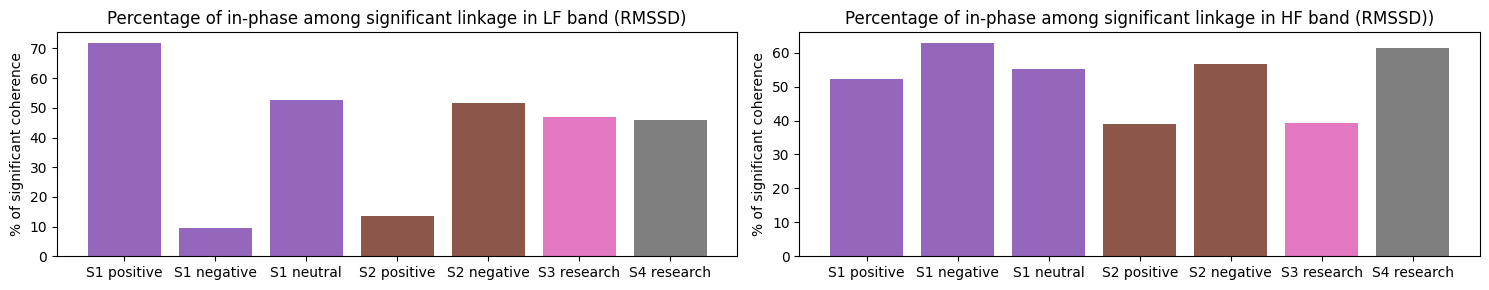

In [2403]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 3))
n = 0
for session in sessions:
    if session == 'NN':
        conditions = conditions_full
        study = 'S1'
        color = 'C4'
    elif session == 'NY':
        conditions = conditions_NY_ecg
        study = 'S2'
        color = 'C5'
    else:
        conditions = conditions_VM_MG
        if session == 'MG':
            study = 'S3'
            color = 'C6'
        else:
            study = 'S4'
            color = 'C7'
    for condition in conditions:
        mask_lf = lf_wct_list[n] > percentile_95_hrv
        mask_hf = hf_wct_list[n] > percentile_95_hrv
        masked_array_lf = lf_awct_list[n][mask_lf].flatten()
        masked_array_hf = hf_awct_list[n][mask_hf].flatten()
        per_in_phase_lf = np.sum(masked_array_lf > 0) / len(masked_array_lf[~np.isnan(masked_array_lf)]) * 100
        per_anti_phase_lf = np.sum(masked_array_lf < 0) / len(masked_array_lf[~np.isnan(masked_array_lf)]) * 100
        per_in_phase_hf = np.sum(masked_array_hf > 0) / len(masked_array_hf[~np.isnan(masked_array_hf)]) * 100
        per_anti_phase_hf = np.sum(masked_array_hf < 0) / len(masked_array_hf[~np.isnan(masked_array_hf)]) * 100
        axes[0].bar(f'{study} {condition}', per_in_phase_lf, color=color)
        #axes[0].bar(f'{study} {condition} anti-phase', per_anti_phase_lf, color=color)
        axes[1].bar(f'{study} {condition}', per_in_phase_hf, color=color)
        #axes[1].bar(f'{study} {condition} anti-phase', per_anti_phase_hf, color=color)
        n += 1
axes[0].set_ylabel('% of significant coherence')
axes[1].set_ylabel('% of significant coherence')
axes[0].set_title('Percentage of in-phase among significant linkage in LF band (RMSSD)')
axes[1].set_title('Percentage of in-phase among significant linkage in HF band (RMSSD))')
plt.tight_layout()

## **EDA analysis**

### Load EDA data

In [2456]:
sessions = ['NN', 'NY', 'MG', 'VM']
conditions_full = ['positive', 'negative', 'neutral']
conditions_NN_eda = ['neutral', 'negative']
conditions_VM_MG = ['research']

person_2 = 'YW'

eda_p1 = {}
eda_p2 = {}

for session in sessions:
    person_1 = session
    eda_p1[session] = {}
    eda_p2[session] = {}
    if session == 'NN' or session == 'NY':
        if session == 'NN':
            conditions = conditions_NN_eda
        else:
            conditions = conditions_full
        for condition in conditions:
            df_eda_p1 = pd.read_csv(f'{data_dir}{session}_preprocessed_{person_1}_{condition}_EDA.csv')
            df_eda_p2 = pd.read_csv(f'{data_dir}{session}_preprocessed_{person_2}_{condition}_EDA.csv')
            df_eda_p1['timestamp'] = pd.to_datetime(df_eda_p1['timestamp'])
            df_eda_p2['timestamp'] = pd.to_datetime(df_eda_p2['timestamp'])
            eda_p1[session][condition] = df_eda_p1
            eda_p2[session][condition] = df_eda_p2
    else:
        condition = conditions_VM_MG[0]
        df_eda_p1 = pd.read_csv(f'{data_dir}{session}_preprocessed_{person_1}_EDA.csv')
        df_eda_p2 = pd.read_csv(f'{data_dir}{session}_preprocessed_{person_2}_EDA.csv')
        df_eda_p1['timestamp'] = pd.to_datetime(df_eda_p1['timestamp'])
        df_eda_p2['timestamp'] = pd.to_datetime(df_eda_p2['timestamp'])
        eda_p1[session][condition] = df_eda_p1
        eda_p2[session][condition] = df_eda_p2

In [2457]:
eda_array_p1 = {}
eda_array_p2 = {}
time_array_p1 = {}
time_array_p2 = {}

for session in sessions:
    eda_array_p1[session] = {}
    eda_array_p2[session] = {}
    time_array_p1[session] = {}
    time_array_p2[session] = {}
    if session == 'NN':
        conditions = conditions_NN_eda
    elif session == 'NY':
        conditions = conditions_full
    else:
        conditions = conditions_VM_MG
    for condition in conditions:
        eda_array_p1[session][condition] = eda_p1[session][condition]['gsr_skin_conductance'].values
        eda_array_p2[session][condition] = eda_p2[session][condition]['gsr_skin_conductance'].values
        time_array_p1[session][condition] = eda_p1[session][condition]['time'].values
        time_array_p2[session][condition] = eda_p2[session][condition]['time'].values

### Re-sampling

In [2458]:
new_t_eda = {}
resampled_eda_p1 = {}
resampled_eda_p2 = {}

for session in sessions:
    new_t_eda[session] = {}
    resampled_eda_p1[session] = {}
    resampled_eda_p2[session] = {}
    if session == 'NN':
        conditions = conditions_NN_eda
    elif session == 'NY':
        conditions = conditions_full
    else:
        conditions = conditions_VM_MG
    for condition in conditions:
        # Re-samplg at 1 Hz
        new_t_eda[session][condition] = np.arange(max(time_array_p1[session][condition][0], time_array_p2[session][condition][0]), min(time_array_p1[session][condition][-1], time_array_p2[session][condition][-1]), 1000)
        interp_func_p1 = interp1d(time_array_p1[session][condition], eda_array_p1[session][condition], kind='quadratic')
        resampled_eda_p1[session][condition] = interp_func_p1(new_t_eda[session][condition])
        interp_func_p2 = interp1d(time_array_p2[session][condition], eda_array_p2[session][condition], kind='quadratic')
        resampled_eda_p2[session][condition] = interp_func_p2(new_t_eda[session][condition])

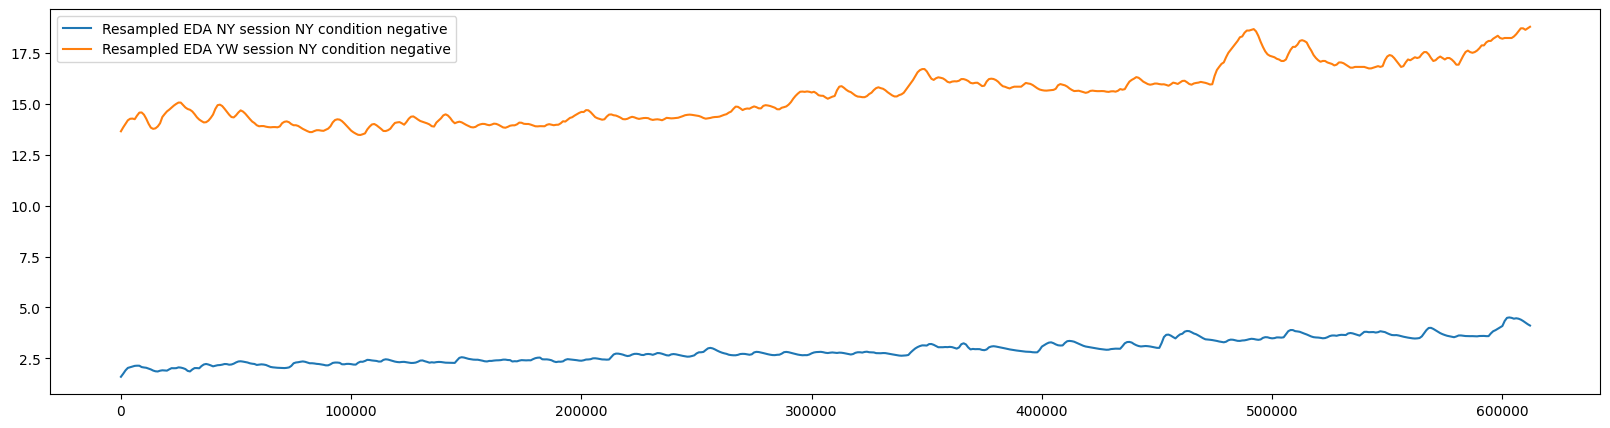

In [2459]:
session = 'NY'
condition = 'negative'
person_1 = session
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(new_t_eda[session][condition], resampled_eda_p1[session][condition], label=f'Resampled EDA {person_1} session {session} condition {condition}')
ax.plot(new_t_eda[session][condition], resampled_eda_p2[session][condition], label=f'Resampled EDA {person_2} session {session} condition {condition}')
ax.legend()
plt.show()

### Standardization

Before applying the wavelet analysis, subtract a mean value and normalize by standard deviation.

In [2460]:
eda_standardized_p1 = {}
eda_standardized_p2 = {}

for session in sessions:
    eda_standardized_p1[session] = {}
    eda_standardized_p2[session] = {}
    if session == 'NN':
        conditions = conditions_NN_eda
    elif session == 'NY':
        conditions = conditions_full
    else:
        conditions = conditions_VM_MG
    for condition in conditions:
        eda_standardized_p1[session][condition] = (resampled_eda_p1[session][condition] - np.mean(resampled_eda_p1[session][condition])) / np.std(resampled_eda_p1[session][condition])
        eda_standardized_p2[session][condition] = (resampled_eda_p2[session][condition] - np.mean(resampled_eda_p2[session][condition])) / np.std(resampled_eda_p2[session][condition])

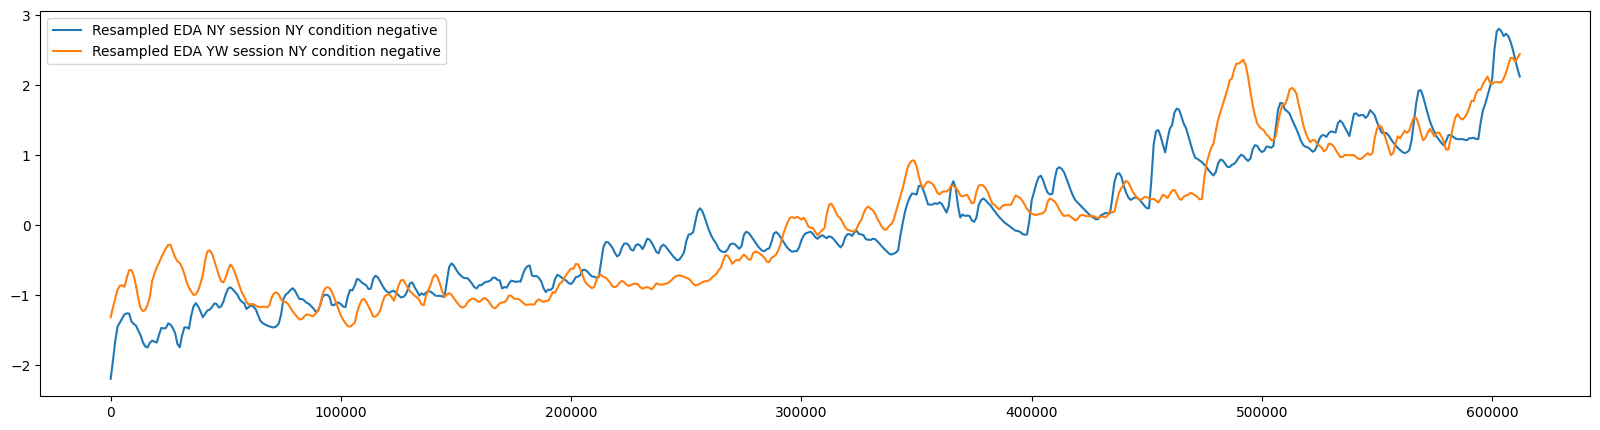

In [2461]:
session = 'NY'
condition = 'negative'
person_1 = session
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(new_t_eda[session][condition], eda_standardized_p1[session][condition], label=f'Resampled EDA {person_1} session {session} condition {condition}')
ax.plot(new_t_eda[session][condition], eda_standardized_p2[session][condition], label=f'Resampled EDA {person_2} session {session} condition {condition}')
ax.legend()
plt.show()

### Decide parameters for wavelet analysis

#### Choose a type of Wavelet
**Morlet wavelet**: Has high frequency resolution

**Paul wavelet**:

**Derivative of a Gaussian wavelet family**:

**Mexican hat wavelet**:


> Refefence:Torrence, C., & Compo, G. P. (1998). A practical guide to wavelet analysis. Bulletin of the American Meteorological Society, 79(1), 61–78.

In [2462]:
fs = 1
dt = 1/fs
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 1 second = 2 seconds
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 7 / dj  # Seven powers of two with dj sub-octaves

### Use surrogate data to determine threshold

In [2463]:
import itertools
data_list = [
    {"session": "NN", "condition": "negative", "person": "NN"},
    {"session": "NN", "condition": "negative", "person": "YW"},
    {"session": "NN", "condition": "neutral", "person": "NN"},
    {"session": "NN", "condition": "neutral", "person": "YW"},
    {"session": "NY", "condition": "positive", "person": "NY"},
    {"session": "NY", "condition": "positive", "person": "YW"},
    {"session": "NY", "condition": "neutral", "person": "NY"},
    {"session": "NY", "condition": "neutral", "person": "YW"},
    {"session": "NY", "condition": "negative", "person": "NY"},
    {"session": "NY", "condition": "negative", "person": "YW"},
    {"session": "MG", "condition": "research", "person": "MG"},
    {"session": "MG", "condition": "research", "person": "YW"},
    {"session": "VM", "condition": "research", "person": "VM"},
    {"session": "VM", "condition": "research", "person": "YW"},
]

data_df = pd.DataFrame(data_list)

# 2. Create all possible pairs
pairs = list(itertools.product(data_df.index, data_df.index))

# 3. Filter out pairs that are not valid
filtered_pairs = set()
for i, j in pairs:
    row_i = data_df.iloc[i]
    row_j = data_df.iloc[j]
    
    # Remove pairs with the same person
    if row_i['person'] == row_j['person']:
        continue
    
    # Remove pairs with the same session and condition
    if row_i['session'] == row_j['session'] and row_i['condition'] == row_j['condition']:
        continue
    
    pair = tuple(sorted([i, j]))
    filtered_pairs.add(pair)

surrogate_pairs = pd.DataFrame([
    {
        "index1": pair[0], 
        "index2": pair[1], 
        "session1": data_df.iloc[pair[0]]['session'], 
        "condition1": data_df.iloc[pair[0]]['condition'], 
        "person1": data_df.iloc[pair[0]]['person'], 
        "session2": data_df.iloc[pair[1]]['session'], 
        "condition2": data_df.iloc[pair[1]]['condition'], 
        "person2": data_df.iloc[pair[1]]['person']
    }
    for pair in filtered_pairs
])

surrogate_pairs

,index1,index2,session1,condition1,person1,session2,condition2,person2
0,6,12,NY,neutral,NY,VM,research,VM
1,3,4,NN,neutral,YW,NY,positive,NY
2,4,9,NY,positive,NY,NY,negative,YW
3,4,12,NY,positive,NY,VM,research,VM
4,3,10,NN,neutral,YW,MG,research,MG
5,5,10,NY,positive,YW,MG,research,MG
6,0,5,NN,negative,NN,NY,positive,YW
7,8,12,NY,negative,NY,VM,research,VM
8,1,6,NN,negative,YW,NY,neutral,NY
9,0,8,NN,negative,NN,NY,negative,NY


In [2464]:
eda_standardized_all = {}

for session in eda_standardized_p1.keys():
    person = session
    eda_standardized_all[session] = {}
    for condition in eda_standardized_p1[session].keys():
        eda_standardized_all[session][condition] = {}
        eda_standardized_all[session][condition][person] = eda_standardized_p1[session][condition]
for session in eda_standardized_p2.keys():
    person = 'YW'
    for condition in eda_standardized_p2[session].keys():
        eda_standardized_all[session][condition][person] = eda_standardized_p2[session][condition]

In [2465]:
wct_surrogate_eda = []

for pair_i in range(len(surrogate_pairs)):
    print(f'Processing pair {pair_i+1}/{len(surrogate_pairs)}')
    session1 = surrogate_pairs.loc[pair_i, 'session1']
    condition1 = surrogate_pairs.loc[pair_i, 'condition1']
    person1 = surrogate_pairs.loc[pair_i, 'person1']
    session2 = surrogate_pairs.loc[pair_i, 'session2']
    condition2 = surrogate_pairs.loc[pair_i, 'condition2']
    person2 = surrogate_pairs.loc[pair_i, 'person2']
    print(f'    {session1} {condition1} {person1} vs {session2} {condition2} {person2}')

    max_idx = min(len(eda_standardized_all[session1][condition1][person1]), len(eda_standardized_all[session2][condition2][person2]))
    wct, awct, coi, freq, sig = wavelet.wct(eda_standardized_all[session1][condition1][person1][:max_idx], eda_standardized_all[session2][condition2][person2][:max_idx], dt, dj=dj, s0=s0, J=-1, sig=False, wavelet=mother, normalize=True)
    period = 1 / freq
    for t in range(wct.shape[1]):
        mask = period > coi[t]
        wct[mask, t] = np.nan
    wct_surrogate_eda.append(wct)

Processing pair 1/59
    NY neutral NY vs VM research VM
Processing pair 2/59
    NN neutral YW vs NY positive NY
Processing pair 3/59
    NY positive NY vs NY negative YW
Processing pair 4/59
    NY positive NY vs VM research VM
Processing pair 5/59
    NN neutral YW vs MG research MG
Processing pair 6/59
    NY positive YW vs MG research MG
Processing pair 7/59
    NN negative NN vs NY positive YW
Processing pair 8/59
    NY negative NY vs VM research VM
Processing pair 9/59
    NN negative YW vs NY neutral NY
Processing pair 10/59
    NN negative NN vs NY negative NY
Processing pair 11/59
    NN neutral NN vs NY positive YW
Processing pair 12/59
    NN neutral NN vs MG research YW
Processing pair 13/59
    MG research MG vs VM research VM
Processing pair 14/59
    NN negative NN vs MG research YW
Processing pair 15/59
    NN neutral NN vs NY negative NY
Processing pair 16/59
    NN negative YW vs VM research VM
Processing pair 17/59
    NY neutral NY vs MG research YW
Processing pai

95th percentile: 0.6101648000706115


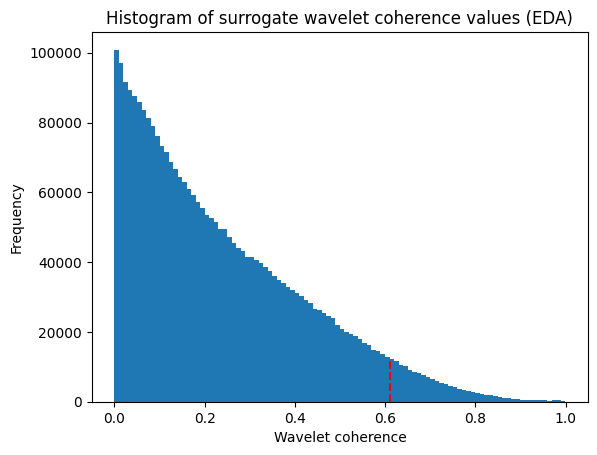

In [2466]:
wct_surrogate_flattened = [wct.flatten() for wct in wct_surrogate_eda]
wct_surrogate_concatenated = np.concatenate(wct_surrogate_flattened)
wct_surrogate_concatenated = wct_surrogate_concatenated[~np.isnan(wct_surrogate_concatenated)]
percentile_95_eda = np.percentile(wct_surrogate_concatenated, 95)
print("95th percentile:", percentile_95_eda)
plt.hist(wct_surrogate_concatenated, bins=100)
plt.vlines(percentile_95_eda, 0, 12000, colors='r', linestyles='dashed')
plt.title('Histogram of surrogate wavelet coherence values (EDA)')
plt.xlabel('Wavelet coherence')
plt.ylabel('Frequency')
#plt.ylim(0, 12000)
plt.show()

In [2467]:
with open('../data/surrogate_wavelet_coherence_eda.npy', 'wb') as f:
    np.save(f, wct_surrogate_concatenated)
with open('../data/eda_95_percentile.txt', 'w') as f:
    f.write(str(percentile_95_eda))

### Calculating wavelet coherence between two signals

In [2468]:
session = 'NN'
condition = 'negative'
wct_eda, awct_eda, coi_eda, freq_eda, sig_eda = wavelet.wct(eda_standardized_p1[session][condition], eda_standardized_p2[session][condition], dt, dj=dj, s0=s0, J=-1, sig=False, wavelet=mother, normalize=True)

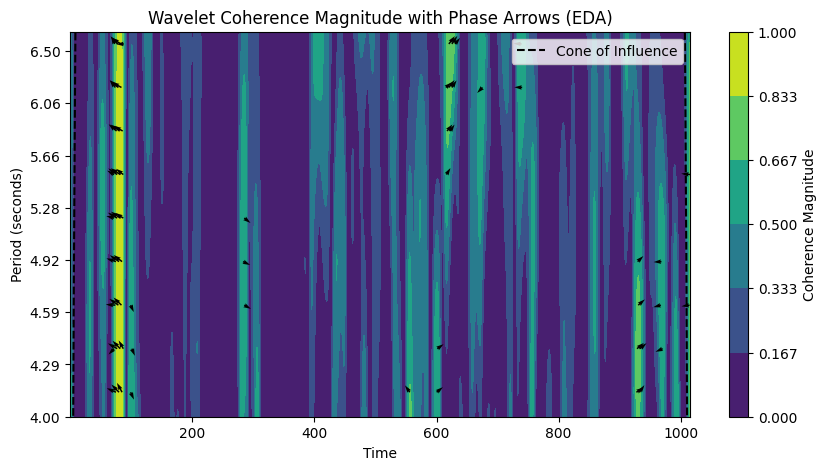

In [2469]:
plot_wavelet_result(threshold=percentile_95_eda, t=new_t_eda[session][condition]/1000, wct=wct_eda, awct=awct_eda, coi=coi_eda, freq=freq_eda, modality='EDA', ylim_low=1/0.25, ylim_high=1/0.15)
plt.savefig(f'../result/{session}_{condition}_eda_HF.png')

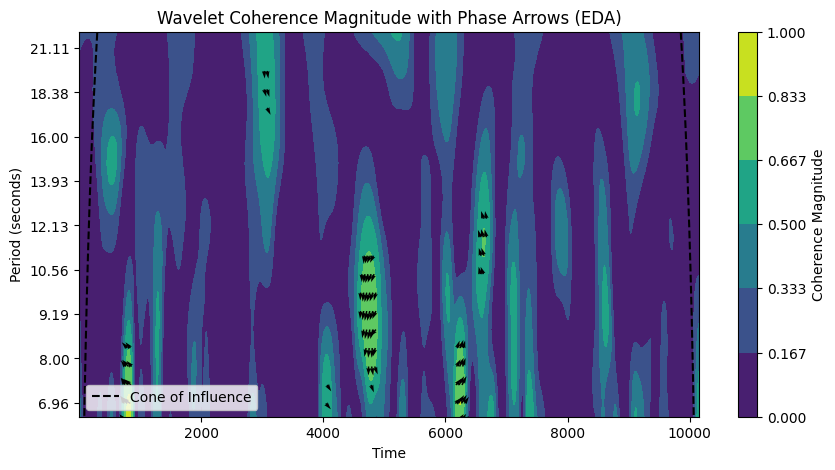

In [2470]:
plot_wavelet_result(threshold=percentile_95_eda, t=new_t_eda[session][condition]/100, wct=wct_eda, awct=awct_eda, coi=coi_eda, freq=freq_eda, modality='EDA', ylim_low=1/0.15, ylim_high=1/0.045)
plt.savefig(f'../result/{session}_{condition}_eda_LF.png')

### Summarizing results

In [2717]:
wct_results_eda = {}
for session in sessions:
    wct_results_eda[session] = {}
    if session == 'NN':
        conditions = conditions_NN_eda
    elif session == 'NY':
        conditions = conditions_full
    else:
        conditions = conditions_VM_MG
    for condition in conditions:
        wct_eda, awct_eda, coi_eda, freq_eda, sig_eda = wavelet.wct(eda_standardized_p1[session][condition], eda_standardized_p2[session][condition], dt, dj=dj, s0=s0, J=-1, sig=False, wavelet=mother, normalize=True)
        wct_results_eda[session][condition] = {}
        wct_results_eda[session][condition]['wct'] = wct_eda
        wct_results_eda[session][condition]['awct'] = awct_eda
        wct_results_eda[session][condition]['coi'] = coi_eda
        wct_results_eda[session][condition]['freq'] = freq_eda
        wct_results_eda[session][condition]['sig'] = sig_eda

Text(0.5, 1.0, 'Wavelet Coherence (EDA) in HF band')

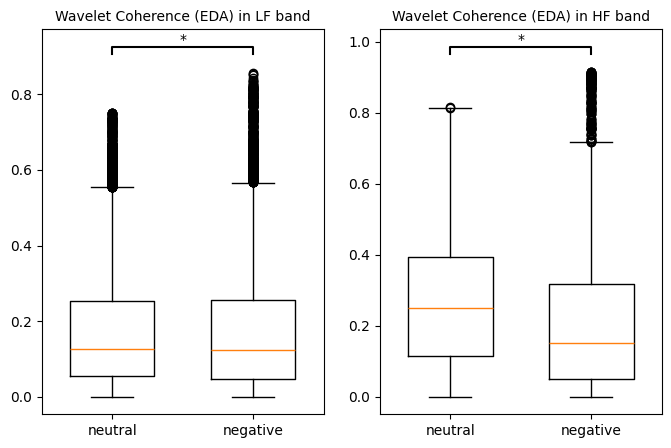

In [2718]:
session = 'NN'
lf_wct_list = []
hf_wct_list = []
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 5))
for condition in conditions_NN_eda:
    period = 1 / wct_results_eda[session][condition]['freq']
    lf_period = np.where((period > 1/0.15) & (period <=1/0.045))
    hf_period = np.where((period >= 1/0.25) & (period <= 1/0.15))
    lf_wct = wct_results_eda[session][condition]['wct'][lf_period[0], :]
    hf_wct = wct_results_eda[session][condition]['wct'][hf_period[0], :]
    coi = wct_results_eda[session][condition]['coi']
    for t in range(lf_wct.shape[1]):
        lf_mask = lf_period > coi[t]
        lf_wct[lf_mask[0], t] = np.nan
        hf_mask = hf_period > coi[t]
        hf_wct[hf_mask[0], t] = np.nan
    lf_wct_list.append(lf_wct)
    hf_wct_list.append(hf_wct)
    lf_wct_flatten = lf_wct.flatten()
    hf_wct_flatten = hf_wct.flatten()
    axes[0].boxplot(lf_wct_flatten[~np.isnan(lf_wct_flatten)], positions=[conditions_NN_eda.index(condition)], widths=0.6)
    axes[1].boxplot(hf_wct_flatten[~np.isnan(hf_wct_flatten)], positions=[conditions_NN_eda.index(condition)], widths=0.6)

# Annotate LF plot
y_max = max([np.nanmax(lf) for lf in lf_wct_list])
annotate_boxplot(axes[0], 0, 1, y_max+0.05, 0.02, 'k')
# annotate_boxplot(axes[0], 1, 2, y_max+0.05, 0.02, 'k')
# annotate_boxplot(axes[0], 0, 2, y_max+0.1, 0.02, 'k')

# Annotate HF plot
y_max = max([np.nanmax(hf) for hf in hf_wct_list])
annotate_boxplot(axes[1], 0, 1, y_max+0.05, 0.02, 'k')
#annotate_boxplot(axes[1], 1, 2, y_max+0.05, 0.02, 'k')
# annotate_boxplot(axes[1], 0, 2, y_max+0.1, 0.02, 'k')

for ax in axes:
    ax.set_xticklabels(conditions_NN_eda)
axes[0].set_title('Wavelet Coherence (EDA) in LF band', fontsize=10)
axes[1].set_title('Wavelet Coherence (EDA) in HF band', fontsize=10)

In [2719]:
array_1 = lf_wct_list[0].flatten()
array_2 = lf_wct_list[1].flatten()
print(f'% of significant coherence in LF band for {conditions_full[0]}: {np.sum(array_1 > percentile_95_eda) / len(array_1[~np.isnan(array_1)]) * 100:.2f}%')
print(f'% of significant coherence in LF band for {conditions_full[1]}: {np.sum(array_2 > percentile_95_eda) / len(array_2[~np.isnan(array_2)]) * 100:.2f}%')

% of significant coherence in LF band for positive: 1.75%
% of significant coherence in LF band for negative: 1.88%


In [2474]:
array_1 = lf_wct_list[0].flatten()
array_2 = lf_wct_list[1].flatten()
print(mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided'))
aw = calculate_aw(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)])
print(f'aw: {aw}')
print(f'da: {convert_aw_to_da(aw, np.var(array_1[~np.isnan(array_1)]), np.var(array_2[~np.isnan(array_2)]))}')

MannwhitneyuResult(statistic=117465544.0, pvalue=0.0005761570652801868)
aw: 0.5116026759712113
da: 0.020568107763733568


In [2475]:
print(np.mean(array_1[~np.isnan(array_1)]))
print(np.mean(array_2[~np.isnan(array_2)]))

0.1765682390583517
0.17419540359353158


In [2476]:
array_1 = hf_wct_list[0].flatten()
array_2 = hf_wct_list[1].flatten()
print(mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided'))
aw = calculate_aw(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)])
print(f'aw: {aw}')
print(f'da: {convert_aw_to_da(aw, np.var(array_1[~np.isnan(array_1)]), np.var(array_2[~np.isnan(array_2)]))}')

MannwhitneyuResult(statistic=28896917.0, pvalue=4.504379370613247e-110)
aw: 0.6113485375786746
da: 0.19999491387271595


Text(0.5, 1.0, 'Wavelet Coherence (EDA) in HF band')

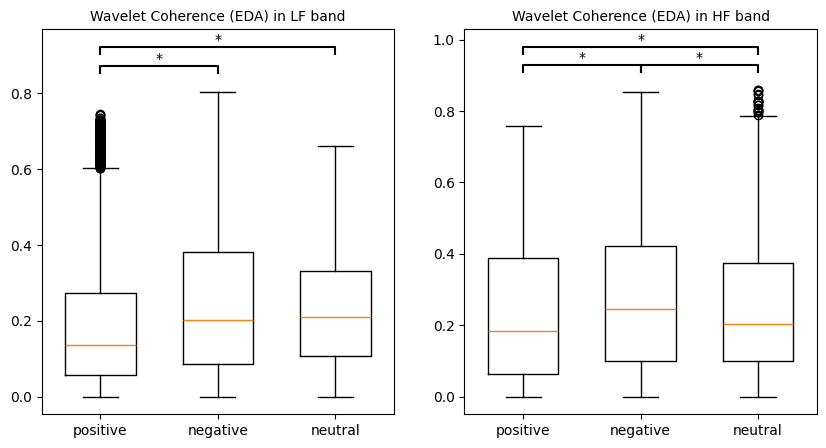

In [2477]:
session = 'NY'
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
lf_wct_list = []
hf_wct_list = []
for condition in conditions_full:
    period = 1 / wct_results_eda[session][condition]['freq']
    lf_freq = np.where((period > 1/0.15) & (period <=1/0.045))
    hf_freq = np.where((period >= 1/0.25) & (period <= 1/0.15))
    lf_wct = wct_results_eda[session][condition]['wct'][lf_freq[0], :]
    hf_wct = wct_results_eda[session][condition]['wct'][hf_freq[0], :]
    coi = wct_results_eda[session][condition]['coi']
    for t in range(lf_wct.shape[1]):
        lf_mask = lf_period > coi[t]
        lf_wct[lf_mask[0], t] = np.nan
        hf_mask = hf_period > coi[t]
        hf_wct[hf_mask[0], t] = np.nan
    lf_wct_list.append(lf_wct)
    hf_wct_list.append(hf_wct)
    lf_wct_flatten = lf_wct.flatten()
    hf_wct_flatten = hf_wct.flatten()
    axes[0].boxplot(lf_wct_flatten[~np.isnan(lf_wct_flatten)], positions=[conditions_full.index(condition)], widths=0.6)
    axes[1].boxplot(hf_wct_flatten[~np.isnan(hf_wct_flatten)], positions=[conditions_full.index(condition)], widths=0.6)

# Annotate LF plot
y_max = max([np.nanmax(lf) for lf in lf_wct_list])
annotate_boxplot(axes[0], 0, 1, y_max+0.05, 0.02, 'k')
# annotate_boxplot(axes[0], 1, 2, y_max+0.05, 0.02, 'k')
annotate_boxplot(axes[0], 0, 2, y_max+0.1, 0.02, 'k')

# Annotate HF plot
y_max = max([np.nanmax(hf) for hf in hf_wct_list])
annotate_boxplot(axes[1], 0, 1, y_max+0.05, 0.02, 'k')
annotate_boxplot(axes[1], 1, 2, y_max+0.05, 0.02, 'k')
annotate_boxplot(axes[1], 0, 2, y_max+0.1, 0.02, 'k')
    
for ax in axes:
    ax.set_xticklabels(conditions_full)
axes[0].set_title('Wavelet Coherence (EDA) in LF band', fontsize=10)
axes[1].set_title('Wavelet Coherence (EDA) in HF band', fontsize=10)

In [2478]:
array_1 = lf_wct_list[0].flatten()
array_2 = lf_wct_list[1].flatten()
array_3 = lf_wct_list[2].flatten()
print(f'% of significant coherence in LF band for {conditions_full[0]}: {np.sum(array_1 > percentile_95_eda) / len(array_1[~np.isnan(array_1)]) * 100:.2f}%')
print(f'% of significant coherence in LF band for {conditions_full[1]}: {np.sum(array_2 > percentile_95_eda) / len(array_2[~np.isnan(array_2)]) * 100:.2f}%')
print(f'% of significant coherence in LF band for {conditions_full[2]}: {np.sum(array_3 > percentile_95_eda) / len(array_3[~np.isnan(array_3)]) * 100:.2f}%')

% of significant coherence in LF band for positive: 1.99%
% of significant coherence in LF band for negative: 5.78%
% of significant coherence in LF band for neutral: 0.86%


In [2479]:
array_1 = lf_wct_list[0].flatten()
array_2 = lf_wct_list[1].flatten()
array_3 = lf_wct_list[2].flatten()
kruskal(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], array_3[~np.isnan(array_3)])

KruskalResult(statistic=864.420536929174, pvalue=1.965465313975417e-188)

In [2480]:
array_1 = lf_wct_list[0].flatten()
array_2 = lf_wct_list[1].flatten()
print(mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided'))
aw = calculate_aw(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)])
print(f'aw: {aw}')
print(f'da: {convert_aw_to_da(aw, np.var(array_1[~np.isnan(array_1)]), np.var(array_2[~np.isnan(array_2)]))}')

MannwhitneyuResult(statistic=47433884.0, pvalue=2.235012072129416e-132)
aw: 0.4039662369790426
da: -0.171893511872525


In [2481]:
array_1 = lf_wct_list[1].flatten()
array_2 = lf_wct_list[2].flatten()
print(mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided'))

MannwhitneyuResult(statistic=59969870.0, pvalue=0.3394899309064866)


In [2482]:
array_1 = lf_wct_list[0].flatten()
array_2 = lf_wct_list[2].flatten()
print(mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided'))
aw = calculate_aw(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)])
print(f'aw: {aw}')
print(f'da: {convert_aw_to_da(aw, np.var(array_1[~np.isnan(array_1)]), np.var(array_2[~np.isnan(array_2)]))}')

MannwhitneyuResult(statistic=44869839.0, pvalue=7.771014186260215e-156)
aw: 0.3948389671609132
da: -0.18860578314779863


In [2483]:
array_1 = hf_wct_list[0].flatten()
array_2 = hf_wct_list[1].flatten()
array_3 = hf_wct_list[2].flatten()
print(f'% of significant coherence in HF band for {conditions_full[0]}: {np.sum(array_1 > percentile_95_eda) / len(array_1[~np.isnan(array_1)]) * 100:.2f}%')
print(f'% of significant coherence in HF band for {conditions_full[1]}: {np.sum(array_2 > percentile_95_eda) / len(array_2[~np.isnan(array_2)]) * 100:.2f}%')
print(f'% of significant coherence in HF band for {conditions_full[2]}: {np.sum(array_3 > percentile_95_eda) / len(array_3[~np.isnan(array_3)]) * 100:.2f}%')

% of significant coherence in HF band for positive: 5.32%
% of significant coherence in HF band for negative: 6.23%
% of significant coherence in HF band for neutral: 7.59%


In [2484]:
array_1 = hf_wct_list[0].flatten()
array_2 = hf_wct_list[1].flatten()
array_3 = hf_wct_list[2].flatten()
kruskal(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], array_3[~np.isnan(array_3)])

KruskalResult(statistic=119.08889990494936, pvalue=1.3809372915165516e-26)

In [2485]:
array_1 = hf_wct_list[0].flatten()
array_2 = hf_wct_list[1].flatten()
print(mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided'))
aw = calculate_aw(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)])
print(f'aw: {aw}')
print(f'da: {convert_aw_to_da(aw, np.var(array_1[~np.isnan(array_1)]), np.var(array_2[~np.isnan(array_2)]))}')

MannwhitneyuResult(statistic=11049958.0, pvalue=1.0574484471332228e-25)
aw: 0.43956207358090227
da: -0.10753652246770329


In [2486]:
array_1 = hf_wct_list[1].flatten()
array_2 = hf_wct_list[2].flatten()
print(mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided'))
aw = calculate_aw(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)])
print(f'aw: {aw}')
print(f'da: {convert_aw_to_da(aw, np.var(array_1[~np.isnan(array_1)]), np.var(array_2[~np.isnan(array_2)]))}')

MannwhitneyuResult(statistic=13374867.0, pvalue=1.0727241570441553e-05)
aw: 0.5253016046699875
da: 0.044876033098032744


In [2487]:
array_1 = hf_wct_list[0].flatten()
array_2 = hf_wct_list[2].flatten()
print(mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided'))
aw = calculate_aw(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)])
print(f'aw: {aw}')
print(f'da: {convert_aw_to_da(aw, np.var(array_1[~np.isnan(array_1)]), np.var(array_2[~np.isnan(array_2)]))}')

MannwhitneyuResult(statistic=11193518.0, pvalue=1.6594507228147316e-12)
aw: 0.4589804160196557
da: -0.07283390410836976


Text(0.5, 1.0, 'Wavelet Coherence (EDA) in HF band')

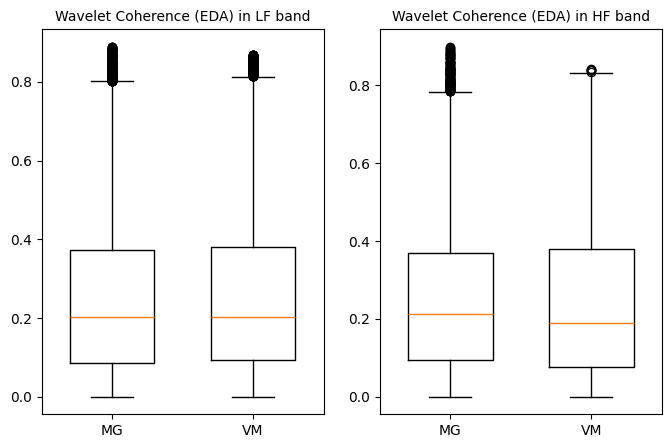

In [2720]:
condition = 'research'
sessions_research = ['MG', 'VM']
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 5))
lf_wct_list = []
hf_wct_list = []
for session in sessions_research:
    period = 1 / wct_results_eda[session][condition]['freq']
    lf_period = np.where((period >= 1/0.15) & (period <=1/0.045))
    hf_period = np.where((period >= 1/0.25) & (period < 1/0.15))
    lf_wct = wct_results_eda[session][condition]['wct'][lf_period[0], :]
    hf_wct = wct_results_eda[session][condition]['wct'][hf_period[0], :]
    coi = wct_results_eda[session][condition]['coi']
    for t in range(lf_wct.shape[1]):
        lf_mask = lf_period > coi[t]
        lf_wct[lf_mask[0], t] = np.nan
        hf_mask = hf_period > coi[t]
        hf_wct[hf_mask[0], t] = np.nan
    lf_wct_list.append(lf_wct)
    hf_wct_list.append(hf_wct)
    lf_wct_flatten = lf_wct.flatten()
    hf_wct_flatten = hf_wct.flatten()
    axes[0].boxplot(lf_wct_flatten[~np.isnan(lf_wct_flatten)], positions=[sessions_research.index(session)], widths=0.6)
    axes[1].boxplot(hf_wct_flatten[~np.isnan(hf_wct_flatten)], positions=[sessions_research.index(session)], widths=0.6)
    
for ax in axes:
    ax.set_xticklabels(sessions_research)
axes[0].set_title('Wavelet Coherence (EDA) in LF band', fontsize=10)
axes[1].set_title('Wavelet Coherence (EDA) in HF band', fontsize=10)

In [2489]:
array_1 = lf_wct_list[0].flatten()
array_2 = lf_wct_list[1].flatten()
print(f'% of significant coherence in LF band for {conditions_VM_MG[0]}: {np.sum(array_1 > percentile_95_eda) / len(array_1[~np.isnan(array_1)]) * 100:.2f}%')
print(f'% of significant coherence in LF band for {conditions_VM_MG[0]}: {np.sum(array_2 > percentile_95_eda) / len(array_2[~np.isnan(array_2)]) * 100:.2f}%')

% of significant coherence in LF band for research: 6.28%
% of significant coherence in LF band for research: 6.30%


In [2490]:
array_1 = lf_wct_list[0].flatten()
array_2 = lf_wct_list[1].flatten()
mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided')

MannwhitneyuResult(statistic=1088871542.0, pvalue=0.0007016672396134047)

In [2491]:
print_mean_rank(list(array_1[~np.isnan(array_1)]), list(array_2[~np.isnan(array_2)]))

Group 1 Mean Rank: 46725.8972868217
Group 2 Mean Rank: 47327.023194528265


In [2492]:
array_1 = hf_wct_list[0].flatten()
array_2 = hf_wct_list[1].flatten()
print(f'% of significant coherence in HF band for {conditions_VM_MG[0]}: {np.sum(array_1 > percentile_95_eda) / len(array_1[~np.isnan(array_1)]) * 100:.2f}%')
print(f'% of significant coherence in HF band for {conditions_VM_MG[0]}: {np.sum(array_2 > percentile_95_eda) / len(array_2[~np.isnan(array_2)]) * 100:.2f}%')

% of significant coherence in HF band for research: 5.33%
% of significant coherence in HF band for research: 6.01%


In [2493]:
array_1 = hf_wct_list[0].flatten()
array_2 = hf_wct_list[1].flatten()
mannwhitneyu(array_1[~np.isnan(array_1)], array_2[~np.isnan(array_2)], alternative='two-sided')

MannwhitneyuResult(statistic=218452562.0, pvalue=3.427500056044802e-12)

In [2494]:
print_mean_rank(list(array_1[~np.isnan(array_1)]), list(array_2[~np.isnan(array_2)]))

Group 1 Mean Rank: 20961.910872704764
Group 2 Mean Rank: 20146.485420319277


(array([5859., 4131., 3054., 2187., 1921., 1690., 1282.,  831.,  523.,
         196.]),
 array([1.60779598e-05, 8.42728085e-02, 1.68529539e-01, 2.52786270e-01,
        3.37043000e-01, 4.21299731e-01, 5.05556461e-01, 5.89813192e-01,
        6.74069923e-01, 7.58326653e-01, 8.42583384e-01]),
 <BarContainer object of 10 artists>)

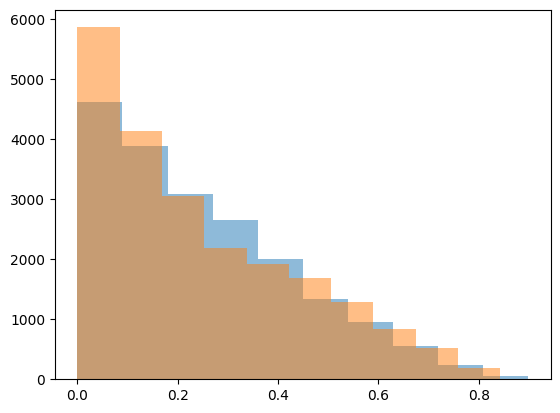

In [2495]:
plt.hist(array_1, alpha=0.5)
plt.hist(array_2, alpha=0.5)

Text(0, 0.5, 'Wavelet Coherence')

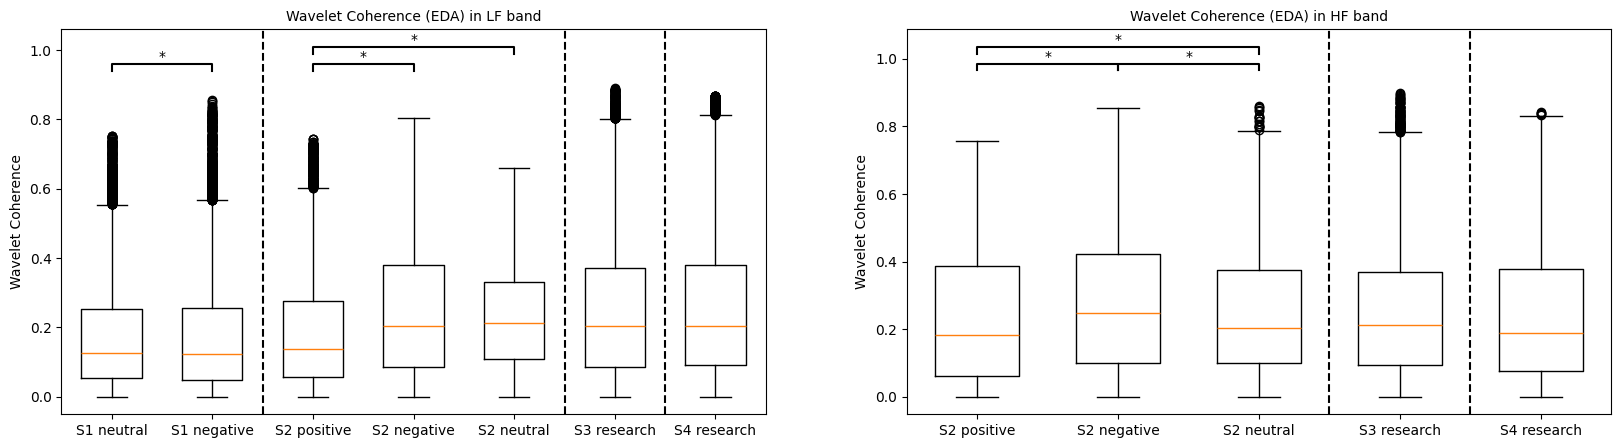

In [2721]:
lf_wct_list = []
hf_wct_list = []
pos = 0
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))
ticklabels = []
for session in sessions:
    if session == 'NN':
        conditions = conditions_NN_eda
        study = 'S1'
    elif session == 'NY':
        conditions = conditions_full
        study = 'S2'
    else:
        conditions = conditions_VM_MG
        if session == 'MG':
            study = 'S3'
        else:
            study = 'S4'
    for condition in conditions:
        period = 1 / wct_results_eda[session][condition]['freq']
        lf_freq = np.where((period >= 1/0.15) & (period <=1/0.045))
        hf_freq = np.where((period >= 1/0.25) & (period < 1/0.15))
        lf_wct = wct_results_eda[session][condition]['wct'][lf_freq[0], :]
        hf_wct = wct_results_eda[session][condition]['wct'][hf_freq[0], :]
        coi = wct_results_eda[session][condition]['coi']
        for t in range(lf_wct.shape[1]):
            lf_mask = lf_period > coi[t]
            lf_wct[lf_mask[0], t] = np.nan
            hf_mask = hf_period > coi[t]
            hf_wct[hf_mask[0], t] = np.nan
        lf_wct_list.append(lf_wct)
        hf_wct_list.append(hf_wct)
        lf_wct_flatten = lf_wct.flatten()
        hf_wct_flatten = hf_wct.flatten()
        axes[0].boxplot(lf_wct_flatten[~np.isnan(lf_wct_flatten)], positions=[pos], widths=0.6)
        if session != 'NN':
            axes[1].boxplot(hf_wct_flatten[~np.isnan(hf_wct_flatten)], positions=[pos], widths=0.6)
        
        ticklabels.append(f'{study} {condition}')
        pos += 1

# Annotate LF plot
y_max = max([np.nanmax(lf) for lf in lf_wct_list])
annotate_boxplot(axes[0], 0, 1, y_max+0.05, 0.02, 'k')
annotate_boxplot(axes[0], 2, 3, y_max+0.05, 0.02, 'k')
annotate_boxplot(axes[0], 2, 4, y_max+0.1, 0.02, 'k')

# Annotate HF plot
y_max = max([np.nanmax(hf) for hf in hf_wct_list])
# annotate_boxplot(axes[1], 0, 1, y_max+0.05, 0.02, 'k')
annotate_boxplot(axes[1], 2, 3, y_max+0.05, 0.02, 'k')
annotate_boxplot(axes[1], 3, 4, y_max+0.05, 0.02, 'k')
annotate_boxplot(axes[1], 2, 4, y_max+0.1, 0.02, 'k')

axes[0].set_xticklabels(ticklabels)
axes[1].set_xticklabels(ticklabels[2:])
axes[0].set_title('Wavelet Coherence (EDA) in LF band', fontsize=10)
axes[1].set_title('Wavelet Coherence (EDA) in HF band', fontsize=10)

axes[0].axvline(x=1.5, color='black', linestyle='--')
axes[0].axvline(x=4.5, color='black', linestyle='--')
axes[0].axvline(x=5.5, color='black', linestyle='--')
# axes[1].axvline(x=1.5, color='black', linestyle='--')
axes[1].axvline(x=4.5, color='black', linestyle='--')
axes[1].axvline(x=5.5, color='black', linestyle='--')

axes[0].set_ylabel('Wavelet Coherence')
axes[1].set_ylabel('Wavelet Coherence')

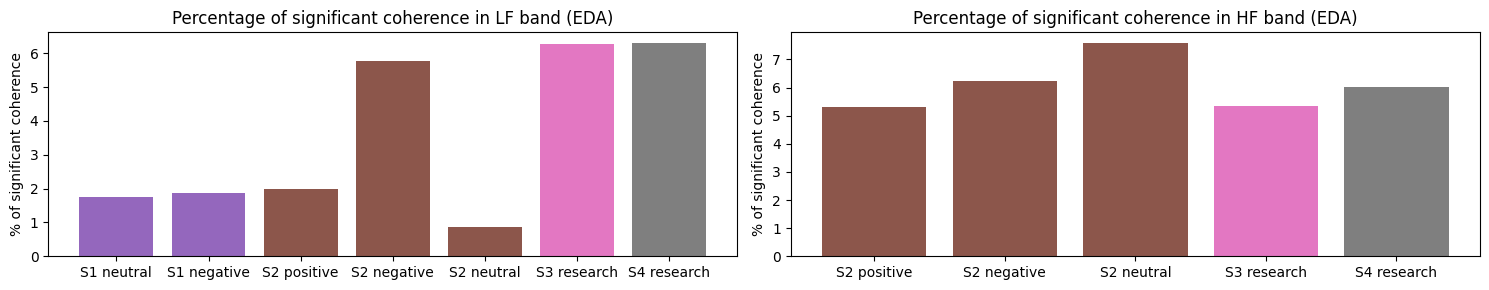

In [2722]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 3))
n = 0
for session in sessions:
    if session == 'NN':
        conditions = conditions_NN_eda
        study = 'S1'
        color = 'C4'
    elif session == 'NY':
        conditions = conditions_full
        study = 'S2'
        color = 'C5'
    else:
        conditions = conditions_VM_MG
        if session == 'MG':
            study = 'S3'
            color = 'C6'
        else:
            study = 'S4'
            color = 'C7'
    for condition in conditions:
        array_lf = lf_wct_list[n].flatten()
        array_hf = hf_wct_list[n].flatten()
        sig_per_lf = np.sum(array_lf > percentile_95_eda) / len(array_lf[~np.isnan(array_lf)]) * 100
        sig_per_hf = np.sum(array_hf > percentile_95_eda) / len(array_hf[~np.isnan(array_hf)]) * 100
        axes[0].bar(f'{study} {condition}', sig_per_lf, color=color)
        if session != 'NN':
            axes[1].bar(f'{study} {condition}', sig_per_hf, color=color)
        n += 1
axes[0].set_ylabel('% of significant coherence')
axes[1].set_ylabel('% of significant coherence')
axes[0].set_title('Percentage of significant coherence in LF band (EDA)')
axes[1].set_title('Percentage of significant coherence in HF band (EDA)')
plt.tight_layout()

In [2723]:
lf_awct_list = []
hf_awct_list = []
lf_wct_list = []
hf_wct_list = []
for session in sessions:
    if session == 'NN':
        conditions = conditions_NN_eda
        study = 'S1'
    elif session == 'NY':
        conditions = conditions_full
        study = 'S2'
    else:
        conditions = conditions_VM_MG
        if session == 'MG':
            study = 'S3'
        else:
            study = 'S4'
    for condition in conditions:
        period = 1 / wct_results_eda[session][condition]['freq']
        lf_period = np.where((period >= 1/0.15) & (period <=1/0.045))
        hf_period = np.where((period >= 1/0.4) & (period < 1/0.15))
        awct_weighted = np.cos(wct_results_eda[session][condition]['awct']) * wct_results_eda[session][condition]['wct']
        lf_awct = awct_weighted[lf_period[0], :]
        hf_awct = awct_weighted[hf_period[0], :]
        lf_wct = wct_results_eda[session][condition]['wct'][lf_period[0], :]
        hf_wct = wct_results_eda[session][condition]['wct'][hf_period[0], :]
        coi = wct_results_eda[session][condition]['coi']
        for t in range(lf_awct.shape[1]):
            lf_mask = lf_period > coi[t]
            lf_wct[lf_mask[0], t] = np.nan
            lf_awct[lf_mask[0], t] = np.nan
            hf_mask = hf_period > coi[t]
            hf_wct[hf_mask[0], t] = np.nan
            hf_awct[hf_mask[0], t] = np.nan
        lf_wct_list.append(lf_wct)
        hf_wct_list.append(hf_wct)
        lf_awct_list.append(lf_awct)
        hf_awct_list.append(hf_awct)

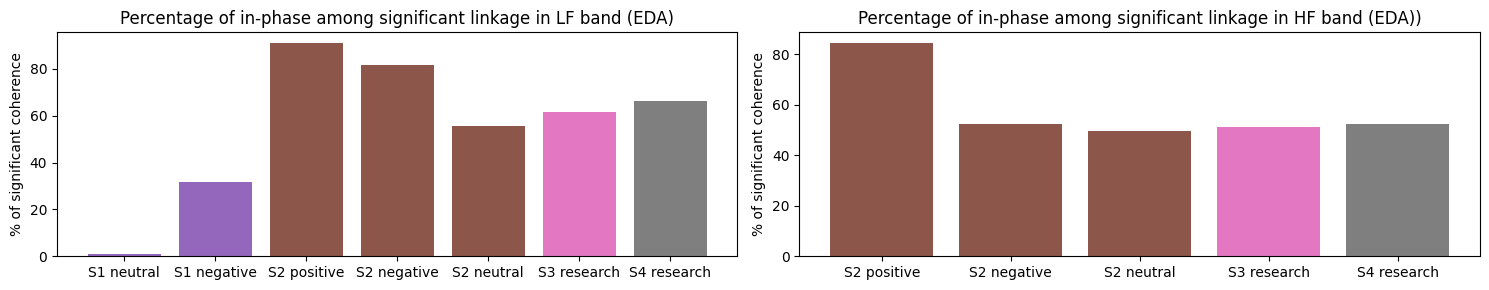

In [2724]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 3))
n = 0
for session in sessions:
    if session == 'NN':
        conditions = conditions_NN_eda
        study = 'S1'
        color = 'C4'
    elif session == 'NY':
        conditions = conditions_full
        study = 'S2'
        color = 'C5'
    else:
        conditions = conditions_VM_MG
        if session == 'MG':
            study = 'S3'
            color = 'C6'
        else:
            study = 'S4'
            color = 'C7'
    for condition in conditions:
        mask_lf = lf_wct_list[n] > percentile_95_eda
        mask_hf = hf_wct_list[n] > percentile_95_eda
        masked_array_lf = lf_awct_list[n][mask_lf].flatten()
        masked_array_hf = hf_awct_list[n][mask_hf].flatten()
        per_in_phase_lf = np.sum(masked_array_lf > 0) / len(masked_array_lf[~np.isnan(masked_array_lf)]) * 100
        per_anti_phase_lf = np.sum(masked_array_lf < 0) / len(masked_array_lf[~np.isnan(masked_array_lf)]) * 100
        per_in_phase_hf = np.sum(masked_array_hf > 0) / len(masked_array_hf[~np.isnan(masked_array_hf)]) * 100
        per_anti_phase_hf = np.sum(masked_array_hf < 0) / len(masked_array_hf[~np.isnan(masked_array_hf)]) * 100
        axes[0].bar(f'{study} {condition}', per_in_phase_lf, color=color)
        #axes[0].bar(f'{study} {condition} anti-phase', per_anti_phase_lf, color=color)
        if session != 'NN':
            axes[1].bar(f'{study} {condition}', per_in_phase_hf, color=color)
        #axes[1].bar(f'{study} {condition} anti-phase', per_anti_phase_hf, color=color)
        n += 1
axes[0].set_ylabel('% of significant coherence')
axes[1].set_ylabel('% of significant coherence')
axes[0].set_title('Percentage of in-phase among significant linkage in LF band (EDA)')
axes[1].set_title('Percentage of in-phase among significant linkage in HF band (EDA))')
plt.tight_layout()

## **Audio analysis**

In [1301]:
if torch.cuda.is_available():
    print(f"CUDA is available. Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available. Using CPU.")

CUDA is not available. Using CPU.


In [1302]:
classifier = pipeline("audio-classification", model="superb/wav2vec2-base-superb-er")

/Users/yuna.w/Research/CBSL/linkage_analysis/.venv/lib/python3.12/site-packages/transformers/configuration_utils.py:306: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [1303]:
# Load the audio file
session = 'VM'
condition = 'research_eda'
audio_file_path = f'../data/audio_clipped/{session}_{condition}.wav'
y, sr = librosa.load(audio_file_path, sr=None, mono=False)
print(f"Original sampling rate: {sr} Hz")

# Check the number of channels
if len(y.shape) > 1:
    print(f"Original audio has {y.shape[0]} channels.")
    # Convert to mono (average the channels)
    y_mono = librosa.to_mono(y)
else:
    print("Original audio is already mono.")
    y_mono = y

# Downsample the audio
new_sr = 16000
y_downsampled = librosa.resample(y_mono, orig_sr=sr, target_sr=new_sr)

# Save the downsampled audio to a new file
downsampled_audio_file_path = f'../data/audio_clipped/{session}_{condition}_downsampled.wav'
sf.write(downsampled_audio_file_path, y_downsampled, new_sr)
print(f"Downsampled audio saved at {downsampled_audio_file_path} with sampling rate {new_sr} Hz and mono channel.")

Original sampling rate: 44100 Hz
Original audio has 2 channels.
Downsampled audio saved at ../data/audio_clipped/VM_research_eda_downsampled.wav with sampling rate 16000 Hz and mono channel.


In [1304]:
def split_audio(waveform, sample_rate, window_size=5):
    """Split the audio waveform into chunks of a specified window size."""
    num_samples = int(window_size * sample_rate)
    return torch.split(waveform, num_samples)

waveform, sample_rate = torchaudio.load(downsampled_audio_file_path)
waveform = waveform.squeeze(0)
input_values = waveform.numpy()

chunks = split_audio(waveform, sample_rate=16000, window_size=5)
results_all = []
for chunk in chunks:
    input_values = chunk.numpy()
    results = classifier({"array": input_values, "sampling_rate": 16000}, top_k=5)
    results_all.append(results)

labels = [result[0]['label'] for result in results_all]

with open(f'../cache/{session}_{condition}_audio_labels.pkl', 'wb') as f:
    pickle.dump(labels, f)

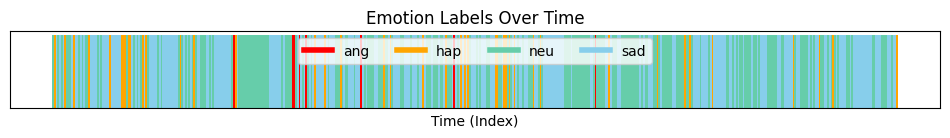

In [1305]:
label_colors = {'ang': 'red', 'hap': 'orange', 'neu': 'mediumaquamarine', 'sad': 'skyblue'}

x = np.arange(len(labels))

colors = [label_colors[label] for label in labels]

plt.figure(figsize=(12, 1))
plt.bar(x, [1] * len(labels), color=colors, width=1.0, align='edge')  # 幅1.0で色分け
plt.xticks(ticks=[], labels=[])  # 軸ラベルを非表示
plt.yticks([])  # Y軸の目盛りを非表示
plt.xlabel('Time (Index)')
plt.title('Emotion Labels Over Time')

legend_labels = list(label_colors.keys())
legend_colors = [plt.Line2D([0], [0], color=label_colors[label], lw=4) for label in legend_labels]
plt.legend(legend_colors, legend_labels, loc='upper center', ncol=len(label_colors))

plt.show()

## **Combining physiology and audio data**

In [2530]:
from matplotlib.gridspec import GridSpec
def plot_wavelet_audio_result(labels, threshold, t, wct, awct, coi, freq, modality, signal1, signal2, step=5, ylim_low_lf=None, ylim_high_lf=None, ylim_low_hf=None, ylim_high_hf=None, timestamps = None):
    fig = plt.figure(figsize=(10, 5))

    axes=[]
    gs = GridSpec(nrows=4, ncols=1, height_ratios=[2, 2, 2, 1], figure=fig)
    axes.append(fig.add_subplot(gs[0]))
    axes.append(fig.add_subplot(gs[1], sharex=axes[0]))
    axes.append(fig.add_subplot(gs[2], sharex=axes[0]))
    axes.append(fig.add_subplot(gs[3], sharex=axes[0]))

    axes[0].plot(t, signal1, label=f'Person 1 {modality}')
    axes[0].plot(t, signal2, label=f'Person 2 {modality}')

    # 周波数を周期に変換
    period = np.log2(1 / freq)  # 周波数を逆数にすることで周期を取得

    # カラーマップのプロット
    contour = axes[1].contourf(
        t,
        period,  # 周期を y 軸に使用
        wct,
        levels=np.linspace(0, 1, 7)
    )
    contour = axes[2].contourf(
        t,
        period,  # 周期を y 軸に使用
        wct,
        levels=np.linspace(0, 1, 7)
    )

    # ベクトル成分計算
    u = np.cos(awct) * wct  # x成分
    v = np.sin(awct) * wct  # y成分

    # 時間-周期グリッドの作成
    X, Y = np.meshgrid(t, period)

    # 有意性マスクの作成
    significant_mask = wct > threshold

    # 矢印の間引き
    axes[1].quiver(
        X[significant_mask][::step],
        Y[significant_mask][::step],
        u[significant_mask][::step],
        v[significant_mask][::step],
        scale=50,
        color='black'
    )

    axes[2].quiver(
        X[significant_mask][::step],
        Y[significant_mask][::step],
        u[significant_mask][::step],
        v[significant_mask][::step],
        scale=50,
        color='black'
    )

    # COI をプロット（周期に変換したものを使用）
    coi_period = np.log2(coi)
    axes[1].plot(t, coi_period, 'k--', label='Cone of Influence')
    axes[2].plot(t, coi_period, 'k--', label='Cone of Influence')

    # 軸ラベル、タイトル、範囲設定
    #axes[1].set_title(f'Wavelet Coherence Magnitude with Phase Arrows ({modality})')
    axes[1].set_ylabel('Period (seconds)')
    axes[1].set_xticks(ticks=[], labels=[])
    #axes[2].set_title(f'Wavelet Coherence Magnitude with Phase Arrows ({modality})')
    axes[2].set_ylabel('Period (seconds)')
    axes[2].set_xticks(ticks=[], labels=[])
    if ylim_low_lf is not None and ylim_high_lf is not None:
        ylim_low_lf = np.log2(ylim_low_lf)
        ylim_high_lf = np.log2(ylim_high_lf)
        axes[1].set_ylim(ylim_low_lf, ylim_high_lf)  # 周期の範囲に合わせる
    if ylim_low_hf is not None and ylim_high_hf is not None:
        ylim_low_hf = np.log2(ylim_low_hf)
        ylim_high_hf = np.log2(ylim_high_hf)
        axes[2].set_ylim(ylim_low_hf, ylim_high_hf)

    def log2_to_nonlog2(x, pos):
        return f'{2**x:.2f}'

    axes[1].yaxis.set_major_formatter(FuncFormatter(log2_to_nonlog2))
    axes[2].yaxis.set_major_formatter(FuncFormatter(log2_to_nonlog2))
    
    # 凡例を追加
    axes[0].legend(loc='upper right')
    axes[1].legend(loc='upper right')
    axes[2].legend(loc='upper right')
    
    time_audio = np.arange(0, len(labels) * 5, 5)

    label_colors = {'ang': 'red', 'hap': 'orange', 'neu': 'mediumaquamarine', 'sad': 'skyblue'}

    colors = [label_colors[label] for label in labels]

    axes[3].bar(time_audio, [5] * len(labels), color=colors, width=5.0, align='edge')  # 幅1.0で色分け
    axes[3].set_yticks([])  # Y軸の目盛りを非表示
    axes[3].set_xlabel('Time')

    legend_labels = list(label_colors.keys())
    legend_colors = [plt.Line2D([0], [0], color=label_colors[label], lw=4) for label in legend_labels]
    axes[3].legend(legend_colors, legend_labels, loc='upper center', ncol=len(label_colors))

    axes[0].set_xlim(0, len(t)-1)
    axes[1].set_xlim(0, len(t)-1)
    axes[2].set_xlim(0, len(t)-1)
    axes[3].set_xlim(0, len(t)-1)

    
    for ax in axes[:-1]:
        ax.tick_params(labelbottom=False)

    if (timestamps is not None):
        axes[3].set_xticks(t[::100])
        timestamps_str = [timestamp.strftime('%H:%M:%S') for timestamp in timestamps]
        axes[3].set_xticklabels(timestamps_str[::100], rotation=90)
        
    plt.tight_layout()
    plt.show()

In [2522]:
first_timestamps = {}
first_timestamps['NN'] = {}
first_timestamps['NN']['positive'] = '2024-10-27 17:56:18.502'
first_timestamps['NN']['neutral'] = '2024-10-27 18:22:26.342'
first_timestamps['NN']['negative'] = '2024-10-27 18:39:43.462'
first_timestamps['NY'] = {}
first_timestamps['NY']['negative'] = '2024-11-19 15:15:42.436'
first_timestamps['NY']['neutral'] = '2024-11-19 15:30:51.569'
first_timestamps['NY']['positive'] = '2024-11-19 15:45:36.987'
first_timestamps['MG'] = {}
first_timestamps['MG']['research'] = '2024-11-21 10:53:58.519'
first_timestamps['VM'] = {}
first_timestamps['VM']['research'] = '2024-11-25 13:37:23.923'

In [2689]:
session = 'VM'
condition = 'research'
pickle_file_path = f'../cache/{session}_{condition}_audio_labels.pkl'

with open(pickle_file_path, 'rb') as f:
    labels = pickle.load(f)

In [2690]:
first_timestamp = pd.to_datetime(first_timestamps[session][condition]).tz_localize('America/New_York')
timestamps = [pd.Timedelta(time, unit='ms') + first_timestamp for time in new_t_ibi[session][condition]] 

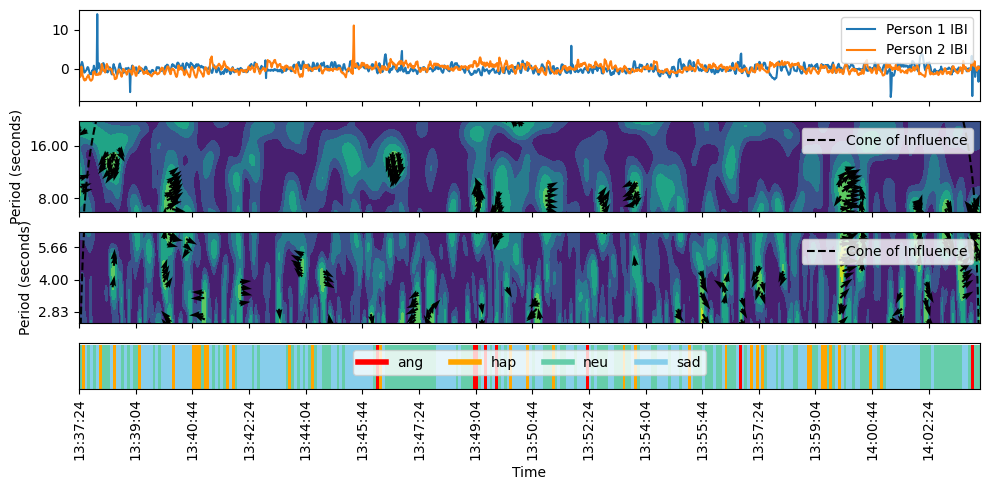

In [2691]:
wct_ibi, awct_ibi, coi_ibi, freq_ibi, sig_ibi = wavelet.wct(ibi_standardized_p1[session][condition], ibi_standardized_p2[session][condition], dt, dj=dj, s0=s0, J=-1, sig=False, wavelet=mother, normalize=True)
plot_wavelet_audio_result(labels=labels, threshold=percentile_95_ibi, t=new_t_ibi[session][condition] / 1000, wct=wct_ibi, awct=awct_ibi, coi=coi_ibi, freq=freq_ibi, modality='IBI', signal1=ibi_standardized_p1[session][condition], signal2=ibi_standardized_p2[session][condition],ylim_low_lf=1/0.15, ylim_high_lf=1/0.045, ylim_low_hf=1/0.4, ylim_high_hf=1/0.15, timestamps=timestamps, step=10)

In [2692]:
timestamps = [pd.Timedelta(time, unit='ms') + first_timestamp for time in standardized_rmssd[session][condition]['time']] 

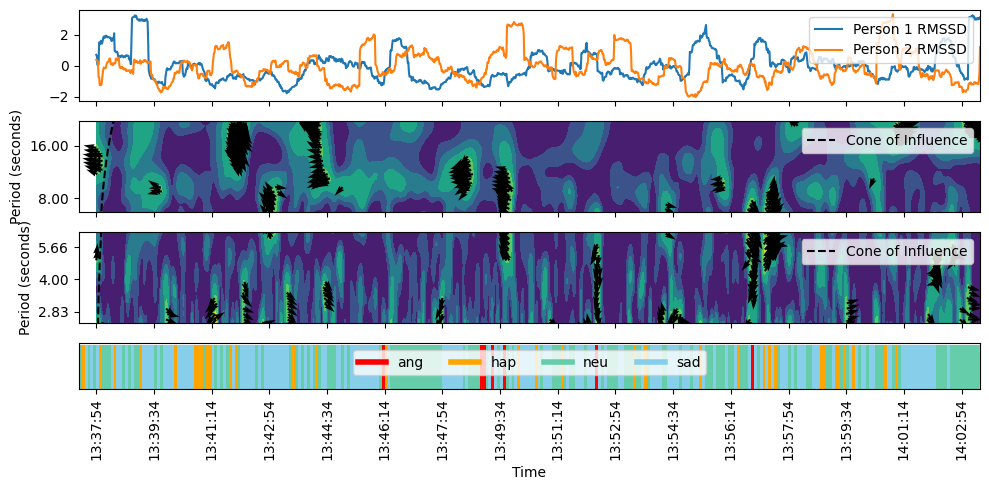

In [2693]:
wct_hrv, awct_hrv, coi_hrv, freq_hrv, sig_hrv = wavelet.wct(standardized_rmssd[session][condition]['hrv_rmssd_p1'], standardized_rmssd[session][condition]['hrv_rmssd_p2'], dt, dj=dj, s0=s0, J=-1, sig=False, wavelet=mother, normalize=True)
plot_wavelet_audio_result(labels=labels, threshold=percentile_95_hrv, t=standardized_rmssd[session][condition]['time'] / 1000, wct=wct_hrv, awct=awct_hrv, coi=coi_hrv, freq=freq_hrv, modality='RMSSD', signal1=standardized_rmssd[session][condition]['hrv_rmssd_p1'], signal2=standardized_rmssd[session][condition]['hrv_rmssd_p2'],ylim_low_lf=1/0.15, ylim_high_lf=1/0.045, ylim_low_hf=1/0.4, ylim_high_hf=1/0.15, timestamps=timestamps)

In [2694]:
if session == 'VM':
    condition_eda = 'research_eda'
    pickle_file_path = f'../cache/{session}_{condition_eda}_audio_labels.pkl'

    with open(pickle_file_path, 'rb') as f:
        labels = pickle.load(f)
timestamps = [pd.Timedelta(time, unit='ms') + first_timestamp for time in new_t_eda[session][condition]] 

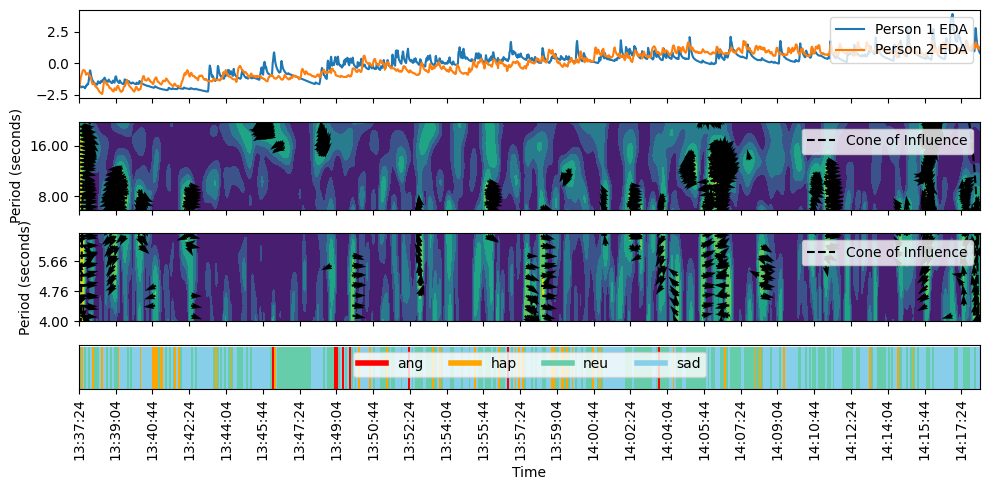

In [2695]:
wct_eda, awct_eda, coi_eda, freq_eda, sig_eda = wavelet.wct(eda_standardized_p1[session][condition], eda_standardized_p2[session][condition], dt, dj=dj, s0=s0, J=-1, sig=False, wavelet=mother, normalize=True)
plot_wavelet_audio_result(labels=labels, threshold=percentile_95_eda, t=new_t_eda[session][condition] / 1000, wct=wct_eda, awct=awct_eda, coi=coi_eda, freq=freq_eda, modality='EDA', signal1=eda_standardized_p1[session][condition], signal2=eda_standardized_p2[session][condition],ylim_low_lf=1/0.15, ylim_high_lf=1/0.045, ylim_low_hf=1/0.25, ylim_high_hf=1/0.15, timestamps=timestamps)

## **Wavelet coherence analysis by audio labels**

In [2696]:
def find_continuous_periods(timestamps, freq='1S'):
    """
    Find continuous periods in a series of timestamps.

    Parameters:
    timestamps (pd.Series): Series of timestamps.
    freq (str): Frequency string to define continuity (default is '1S' for 1 second).

    Returns:
    list: List of tuples with start and end of continuous periods.
    """
    periods = []
    start = timestamps.iloc[0]
    end = start

    for current in timestamps[1:]:
        if (current - end) <= pd.Timedelta(freq):
            end = current
        else:
            periods.append((start, end))
            start = current
            end = start

    periods.append((start, end))
    return periods

In [2726]:
session = 'NN'
condition = 'positive'
pickle_file_path = f'../cache/{session}_{condition}_audio_labels.pkl'

with open(pickle_file_path, 'rb') as f:
    labels = pickle.load(f)

### IBI

In [2758]:
def get_wct_by_label(modality, session, condition, labels):
    if modality == 'IBI':
        array1 = ibi_standardized_p1[session][condition]
        array2 = ibi_standardized_p2[session][condition]
    elif modality == 'RMSSD':
        array1 = standardized_rmssd[session][condition]['hrv_rmssd_p1']
        array2 = standardized_rmssd[session][condition]['hrv_rmssd_p2']
    elif modality == 'EDA':
        array1 = eda_standardized_p1[session][condition]
        array2 = eda_standardized_p2[session][condition]
    else:
        raise KeyError('Invalid modality. Choose from IBI, RMSSD, or EDA.')
    wct, awct, coi, freq, sig = wavelet.wct(array1, array2, dt, dj=dj, s0=s0, J=-1, sig=False, wavelet=mother, normalize=True)
    if modality == 'IBI':
        period_low = 1/0.4
        period_high = 1/0.045
    elif modality == 'RMSSD':
        period_low = 1/0.4
        period_high = 1/0.15
    elif modality == 'EDA':
        period_low = 1/0.25
        period_high = 1/0.045
    first_timestamp = pd.to_datetime(first_timestamps[session][condition]).tz_localize('America/New_York')
    if modality == 'IBI':
        timestamps = [pd.Timedelta(time, unit='ms') + first_timestamp for time in new_t_ibi[session][condition]] 
    elif modality == 'RMSSD':
        timestamps = [pd.Timedelta(time, unit='ms') + first_timestamp for time in standardized_rmssd[session][condition]['time']]
    elif modality == 'EDA':
        timestamps = [pd.Timedelta(time, unit='ms') + first_timestamp for time in new_t_eda[session][condition]]

    labels_sec = [item for item in labels for _ in range(5)]
    df_dict = {f'{(1/freq)[i]}': wct[i, :] for i in range(wct.shape[0])}
    df_dict_awct = {f'{(1/freq)[i]}': np.cos(awct[i, :]) * wct[i, :] for i in range(awct.shape[0])}
    df_dict['label'] = labels_sec[0:wct.shape[1]]
    df_dict_awct['label'] = labels_sec[0:awct.shape[1]]
    df_concat = pd.DataFrame(df_dict)
    df_concat_awct = pd.DataFrame(df_dict_awct)

    # Iterate over each row and set values to NaN based on the cone of influence
    df_without_label = df_concat.drop(columns=['label'])
    df_without_label_awct = df_concat_awct.drop(columns=['label'])
    df_without_label.columns = pd.to_numeric(df_without_label.columns)
    df_without_label_awct.columns = pd.to_numeric(df_without_label_awct.columns)
    for i, period in enumerate(coi):
        df_without_label.iloc[i, df_without_label.columns > period] = np.nan
        df_without_label_awct.iloc[i, df_without_label_awct.columns > period] = np.nan
    df_without_label = df_without_label.loc[:, (df_without_label.columns > period_low) & (df_without_label.columns < period_high)]
    df_without_label_awct = df_without_label_awct.loc[:, (df_without_label_awct.columns > period_low) & (df_without_label_awct.columns < period_high)]

    df_with_label = df_without_label.copy()
    df_with_label_awct = df_without_label_awct.copy()
    df_with_label['label'] = df_concat['label']
    df_with_label_awct['label'] = df_concat_awct['label']
    df_with_label['timestamp'] = timestamps
    df_with_label_awct['timestamp'] = timestamps

    ang_list = []
    hap_list = []
    neu_list = []
    sad_list = []
    ang_list_awct = []
    hap_list_awct = []
    neu_list_awct = []
    sad_list_awct = []
    for i in range(len(df_with_label)):
        label = df_with_label.loc[i, 'label']
        row = df_without_label.iloc[i]
        if label == 'ang':
            ang_list += list(row.dropna().values)
        elif label == 'hap':
            hap_list += list(row.dropna().values)
        elif label == 'neu':
            neu_list += list(row.dropna().values)
        elif label == 'sad':
            sad_list += list(row.dropna().values)
    for i in range(len(df_with_label_awct)):
        label = df_with_label_awct.loc[i, 'label']
        row = df_without_label_awct.iloc[i]
        if label == 'ang':
            ang_list_awct += list(row.dropna().values)
        elif label == 'hap':
            hap_list_awct += list(row.dropna().values)
        elif label == 'neu':
            neu_list_awct += list(row.dropna().values)
        elif label == 'sad':
            sad_list_awct += list(row.dropna().values)
    
    return df_with_label, df_without_label, df_with_label_awct, df_without_label_awct, ang_list, hap_list, neu_list, sad_list, ang_list_awct, hap_list_awct, neu_list_awct, sad_list_awct

In [2738]:
df_with_label, df_without_label, df_with_label_awct, df_without_label_awct, ang_list, hap_list, neu_list, sad_list, ang_list_awct, hap_list_awct, neu_list_awct, sad_list_awct = get_wct_by_label('IBI', session, condition, labels)

In [ ]:
wct_ibi, awct_ibi, coi_ibi, freq_ibi, sig_ibi = wavelet.wct(ibi_standardized_p1[session][condition], ibi_standardized_p2[session][condition], dt, dj=dj, s0=s0, J=-1, sig=False, wavelet=mother, normalize=True)
period_low = 1/0.4
period_high = 1/0.045
first_timestamp = pd.to_datetime(first_timestamps[session][condition]).tz_localize('America/New_York')
timestamps = [pd.Timedelta(time, unit='ms') + first_timestamp for time in new_t_ibi[session][condition]] 

labels_sec = [item for item in labels for _ in range(5)]
df_dict = {f'{(1/freq_ibi)[i]}': wct_ibi[i, :] for i in range(wct_ibi.shape[0])}
df_dict_awct = {f'{(1/freq_ibi)[i]}': np.cos(awct_ibi[i, :]) for i in range(awct_ibi.shape[0])}
df_dict['label'] = labels_sec[0:wct_ibi.shape[1]]
df_dict_awct['label'] = labels_sec[0:awct_ibi.shape[1]]
df_concat = pd.DataFrame(df_dict)
df_concat_awct = pd.DataFrame(df_dict_awct)

# Iterate over each row and set values to NaN based on the cone of influence
df_without_label = df_concat.drop(columns=['label'])
df_without_label_awct = df_concat_awct.drop(columns=['label'])
df_without_label.columns = pd.to_numeric(df_without_label.columns)
df_without_label_awct.columns = pd.to_numeric(df_without_label_awct.columns)
for i, period in enumerate(coi_ibi):
    df_without_label.iloc[i, df_without_label.columns > period] = np.nan
    df_without_label_awct.iloc[i, df_without_label_awct.columns > period] = np.nan
df_without_label = df_without_label.loc[:, (df_without_label.columns > period_low) & (df_without_label.columns < period_high)]
df_without_label_awct = df_without_label_awct.loc[:, (df_without_label_awct.columns > period_low) & (df_without_label_awct.columns < period_high)]

df_with_label = df_without_label.copy()
df_with_label_awct = df_without_label_awct.copy()
df_with_label['label'] = df_concat['label']
df_with_label_awct['label'] = df_concat_awct['label']
df_with_label['timestamp'] = timestamps
df_with_label_awct['timestamp'] = timestamps

ang_list = []
hap_list = []
neu_list = []
sad_list = []
for i in range(len(df_with_label)):
    label = df_with_label.loc[i, 'label']
    row = df_without_label.iloc[i]
    if label == 'ang':
        ang_list += list(row.dropna().values)
    elif label == 'hap':
        hap_list += list(row.dropna().values)
    elif label == 'neu':
        neu_list += list(row.dropna().values)
    elif label == 'sad':
        sad_list += list(row.dropna().values)

ang: 5472
hap: 14344
neu: 4726
sad: 570


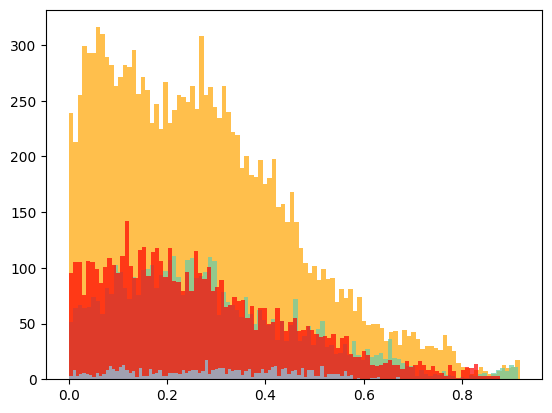

In [2739]:
plt.hist(hap_list, bins=100, alpha=0.7, label='hap', color='orange')
plt.hist(neu_list, bins=100, alpha=0.7, label='neu', color='mediumaquamarine')
plt.hist(ang_list, bins=100, alpha=0.7, label='ang', color='red')
plt.hist(sad_list, bins=100, alpha=0.7, label='sad', color='skyblue')

print(f"ang: {len(ang_list)}")
print(f"hap: {len(hap_list)}")
print(f"neu: {len(neu_list)}")
print(f"sad: {len(sad_list)}")

In [2753]:
list_all = [ang_list, hap_list, neu_list, sad_list]
emotion_labels = ['ang', 'hap', 'neu', 'sad']
non_empty_lists = [lst for lst in list_all if lst]
non_empty_labels = [label for i, label in enumerate(emotion_labels) if list_all[i] != []]
overall_result = kruskal(*non_empty_lists)
print(f'Overall: {overall_result}')

if overall_result.pvalue < 0.05:
    pvalues = []
    unique_pairs = set()
    for i in range(len(non_empty_lists)):
        for j in range(i+1, len(non_empty_lists)):
            pair = tuple(sorted([non_empty_labels[i], non_empty_labels[j]]))
            if pair not in unique_pairs:
                unique_pairs.add(pair)
                result = mannwhitneyu(non_empty_lists[i], non_empty_lists[j], alternative="two-sided")
                print(f'{pair[0]}-{pair[1]}: {result}')
                pvalues.append([i, j, result.pvalue])
                aw = calculate_aw(non_empty_lists[i], non_empty_lists[j])
                print(f'aw: {aw}')
                p1 = len(non_empty_lists[i]) / (len(non_empty_lists[i]) + len(non_empty_lists[j]))
                p2 = len(non_empty_lists[j]) / (len(non_empty_lists[i]) + len(non_empty_lists[j]))
                print(f'da: {convert_aw_to_da(aw, np.var(non_empty_lists[i]), np.var(non_empty_lists[j]), p1=p1, p2=p2)}')

significant_pair_indices = []
pvalues = np.array(pvalues)
sig_p = 0.05 / len(pvalues)
significant_pairs = np.where(pvalues[:, 2] < sig_p)[0]
for i in significant_pairs:
    pair_i = pvalues[i, 0]
    pair_j = pvalues[i, 1]
    significant_pair_indices.append(tuple((pair_i, pair_j)))

Overall: KruskalResult(statistic=55.35646738880314, pvalue=5.7631932749657016e-12)
ang-hap: MannwhitneyuResult(statistic=38568579.0, pvalue=0.060202210772618205)
aw: 0.4913797703178051
da: -0.015300118546834938
ang-neu: MannwhitneyuResult(statistic=12045034.0, pvalue=2.3508825337904306e-09)
aw: 0.4657664735084997
da: -0.06073134804900568
ang-sad: MannwhitneyuResult(statistic=1366099.0, pvalue=1.0586523482748595e-06)
aw: 0.43798700882322766
da: -0.11712159709654511
hap-neu: MannwhitneyuResult(statistic=32223547.0, pvalue=3.544315332181107e-07)
aw: 0.4753454593367398
da: -0.043688799590653464
hap-sad: MannwhitneyuResult(statistic=3644324.0, pvalue=1.0745323859700081e-05)
aw: 0.44572998307257267
da: -0.10342804205277706
neu-sad: MannwhitneyuResult(statistic=1265745.0, pvalue=0.018585882182309093)
aw: 0.46986992449384146
da: -0.05680410709851567


/var/folders/1x/tmzcjdgn7wqdrcsl41btp5vh0000gn/T/ipykernel_8689/1951390069.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(non_empty_lists, labels=non_empty_labels, positions=np.arange(len(non_empty_lists)))


Text(0.5, 1.0, 'Wavelet Coherence in IBI in LF & HF band')

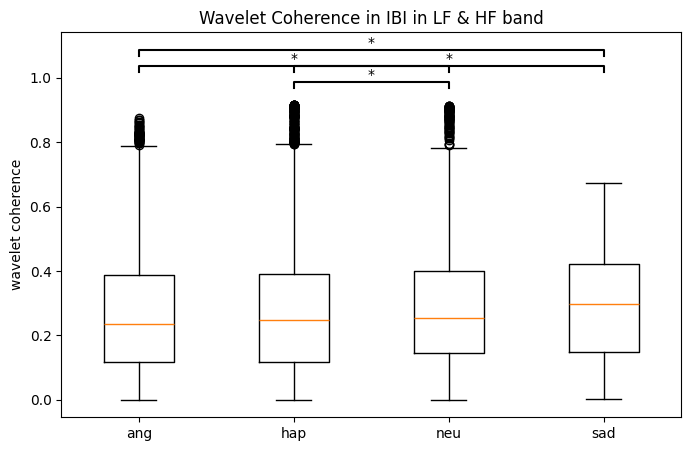

In [2741]:
# Convert lists to numerical values
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(2*len(non_empty_labels), 5))
ax.boxplot(non_empty_lists, labels=non_empty_labels, positions=np.arange(len(non_empty_lists)))
if significant_pair_indices != []:
    for pair in significant_pair_indices:
        y_max = max(np.nanmax(list) for list in non_empty_lists)
        if abs(pair[0] - pair[1]) == 1:
            h = y_max + 0.05
        elif abs(pair[0] - pair[1]) == 2:
            h = y_max + 0.1
        else:
            h = y_max + 0.15
        annotate_boxplot(ax, pair[0], pair[1], h, 0.02, 'k')
ax.set_ylabel('wavelet coherence')
ax.set_title('Wavelet Coherence in IBI in LF & HF band')

In [ ]:
df_without_label_hf = df_without_label.loc[:, (df_without_label.columns > 1/0.4) & (df_without_label.columns < 1/0.15)]
df_hf_high_wct = df_without_label[(df_without_label > percentile_95_ibi).any(axis=1)]
hf_high_wct_timestamp = df_with_label.loc[df_hf_high_wct.index, 'timestamp']
high_cwt_period = find_continuous_periods(hf_high_wct_timestamp)
for i in range(len(high_cwt_period)):
    if (high_cwt_period[i][1] - high_cwt_period[i][0]) >= pd.Timedelta('10s'):
        print(f"Period {i+1}: {high_cwt_period[i][0]} to {high_cwt_period[i][1]}")

Period 2: 2024-10-27 17:57:13.314002686-04:00 to 2024-10-27 17:57:53.314002686-04:00
Period 3: 2024-10-27 17:58:51.314002686-04:00 to 2024-10-27 17:59:27.314002686-04:00
Period 7: 2024-10-27 18:03:36.314002686-04:00 to 2024-10-27 18:03:53.314002686-04:00
Period 8: 2024-10-27 18:04:25.314002686-04:00 to 2024-10-27 18:05:32.314002686-04:00
Period 11: 2024-10-27 18:06:38.314002686-04:00 to 2024-10-27 18:06:48.314002686-04:00


/var/folders/1x/tmzcjdgn7wqdrcsl41btp5vh0000gn/T/ipykernel_8689/3367195430.py:17: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  if (current - end) <= pd.Timedelta(freq):


### RMSSD

In [2703]:
wct_hrv, awct_hrv, coi_hrv, freq_hrv, sig_hrv = wavelet.wct(standardized_rmssd[session][condition]['hrv_rmssd_p1'], standardized_rmssd[session][condition]['hrv_rmssd_p2'], dt, dj=dj, s0=s0, J=-1, sig=False, wavelet=mother, normalize=True)
period_low = 1/0.4
period_high = 1/0.15
first_timestamp = pd.to_datetime(first_timestamps[session][condition]).tz_localize('America/New_York')
timestamps = [pd.Timedelta(time, unit='ms') + first_timestamp for time in standardized_rmssd[session][condition]['time']] 

labels_sec = [item for item in labels for _ in range(5)]
df_dict = {f'{(1/freq_hrv)[i]}': wct_hrv[i, :] for i in range(wct_hrv.shape[0])}
df_dict['label'] = labels_sec[0:wct_hrv.shape[1]]
df_concat = pd.DataFrame(df_dict)

# Iterate over each row and set values to NaN based on the cone of influence
df_without_label = df_concat.drop(columns=['label'])
df_without_label.columns = pd.to_numeric(df_without_label.columns)
for i, period in enumerate(coi_hrv):
    df_without_label.iloc[i, df_without_label.columns > period] = np.nan
df_without_label = df_without_label.loc[:, (df_without_label.columns > period_low) & (df_without_label.columns < period_high)]

df_with_label = df_without_label.copy()
df_with_label['label'] = df_concat['label']
df_with_label['timestamp'] = timestamps

ang_list = []
hap_list = []
neu_list = []
sad_list = []
for i in range(len(df_with_label)):
    label = df_with_label.loc[i, 'label']
    row = df_without_label.iloc[i]
    if label == 'ang':
        ang_list += list(row.dropna().values)
    elif label == 'hap':
        hap_list += list(row.dropna().values)
    elif label == 'neu':
        neu_list += list(row.dropna().values)
    elif label == 'sad':
        sad_list += list(row.dropna().values)

ang: 0
hap: 5185
neu: 1530
sad: 29941


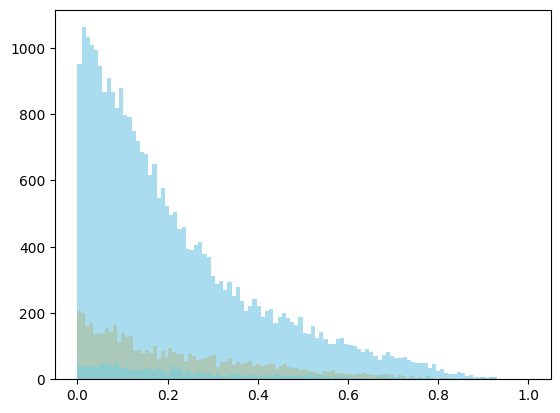

In [2704]:
plt.hist(hap_list, bins=100, alpha=0.7, label='hap', color='orange')
plt.hist(neu_list, bins=100, alpha=0.7, label='neu', color='mediumaquamarine')
plt.hist(ang_list, bins=100, alpha=0.7, label='ang', color='red')
plt.hist(sad_list, bins=100, alpha=0.7, label='sad', color='skyblue')

print(f"ang: {len(ang_list)}")
print(f"hap: {len(hap_list)}")
print(f"neu: {len(neu_list)}")
print(f"sad: {len(sad_list)}")

In [2705]:
list_all = [ang_list, hap_list, neu_list, sad_list]
emotion_labels = ['ang', 'hap', 'neu', 'sad']
non_empty_lists = [lst for lst in list_all if lst]
non_empty_labels = [label for i, label in enumerate(emotion_labels) if list_all[i] != []]
overall_result = kruskal(*non_empty_lists)
print(f'Overall: {overall_result}')

if overall_result.pvalue < 0.05:
    pvalues = []
    unique_pairs = set()
    for i in range(len(non_empty_lists)):
        for j in range(i+1, len(non_empty_lists)):
            pair = tuple(sorted([non_empty_labels[i], non_empty_labels[j]]))
            if pair not in unique_pairs:
                unique_pairs.add(pair)
                result = mannwhitneyu(non_empty_lists[i], non_empty_lists[j], alternative="two-sided")
                print(f'{pair[0]}-{pair[1]}: {result}')
                pvalues.append([i, j, result.pvalue])
                aw = calculate_aw(non_empty_lists[i], non_empty_lists[j])
                print(f'aw: {aw}')
                p1 = len(non_empty_lists[i]) / (len(non_empty_lists[i]) + len(non_empty_lists[j]))
                p2 = len(non_empty_lists[j]) / (len(non_empty_lists[i]) + len(non_empty_lists[j]))
                print(f'da: {convert_aw_to_da(aw, np.var(non_empty_lists[i]), np.var(non_empty_lists[j]), p1=p1, p2=p2)}')

significant_pair_indices = []
pvalues = np.array(pvalues)
sig_p = 0.05 / len(pvalues)
significant_pairs = np.where(pvalues[:, 2] < sig_p)[0]
for i in significant_pairs:
    pair_i = pvalues[i, 0]
    pair_j = pvalues[i, 1]
    significant_pair_indices.append(tuple((pair_i, pair_j)))

Overall: KruskalResult(statistic=62.71510368300369, pvalue=2.407621812288662e-14)
hap-neu: MannwhitneyuResult(statistic=3567691.0, pvalue=2.1560963651855836e-09)
aw: 0.44972501118737435
da: -0.08496428945071191
hap-sad: MannwhitneyuResult(statistic=78929879.0, pvalue=0.052372025066406744)
aw: 0.5084243886006994
da: 0.014940077331139707
neu-sad: MannwhitneyuResult(statistic=25616504.0, pvalue=5.151972366743531e-15)
aw: 0.5591935163119276
da: 0.09665506543112867


/var/folders/1x/tmzcjdgn7wqdrcsl41btp5vh0000gn/T/ipykernel_8689/583392395.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(non_empty_lists, labels=non_empty_labels, positions=np.arange(len(non_empty_lists)))


Text(0.5, 1.0, 'Wavelet Coherence in RMSSD in HF band')

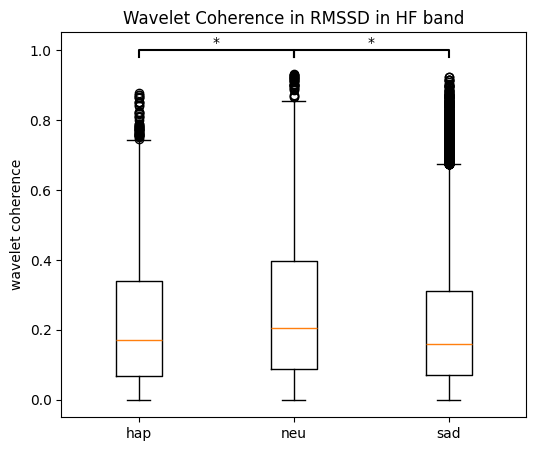

In [2706]:
# Convert lists to numerical values
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(2*len(non_empty_labels), 5))
ax.boxplot(non_empty_lists, labels=non_empty_labels, positions=np.arange(len(non_empty_lists)))
if significant_pair_indices != []:
    for pair in significant_pair_indices:
        y_max = max(np.nanmax(list) for list in non_empty_lists)
        if abs(pair[0] - pair[1]) == 1:
            h = y_max + 0.05
        elif abs(pair[0] - pair[1]) == 2:
            h = y_max + 0.1
        else:
            h = y_max + 0.15
        annotate_boxplot(ax, pair[0], pair[1], h, 0.02, 'k')
ax.set_ylabel('wavelet coherence')
ax.set_title('Wavelet Coherence in RMSSD in HF band')

In [2707]:
df_without_label_hf = df_without_label.loc[:, (df_without_label.columns > 1/0.4) & (df_without_label.columns < 1/0.15)]
df_hf_high_wct = df_without_label[(df_without_label > percentile_95_ibi).any(axis=1)]
hf_high_wct_timestamp = df_with_label.loc[df_hf_high_wct.index, 'timestamp']
high_cwt_period = find_continuous_periods(hf_high_wct_timestamp)
for i in range(len(high_cwt_period)):
    if (high_cwt_period[i][1] - high_cwt_period[i][0]) >= pd.Timedelta('10s'):
        print(f"Period {i+1}: {high_cwt_period[i][0]} to {high_cwt_period[i][1]}")

Period 2: 2024-11-21 10:55:50-05:00 to 2024-11-21 10:56:07-05:00
Period 4: 2024-11-21 10:57:57-05:00 to 2024-11-21 10:58:10-05:00
Period 5: 2024-11-21 10:58:28-05:00 to 2024-11-21 10:58:38-05:00
Period 7: 2024-11-21 11:00:32-05:00 to 2024-11-21 11:00:43-05:00
Period 9: 2024-11-21 11:03:11-05:00 to 2024-11-21 11:03:21-05:00
Period 13: 2024-11-21 11:06:02-05:00 to 2024-11-21 11:06:13-05:00
Period 23: 2024-11-21 11:16:18-05:00 to 2024-11-21 11:16:40-05:00
Period 25: 2024-11-21 11:17:22-05:00 to 2024-11-21 11:17:46-05:00
Period 27: 2024-11-21 11:20:19-05:00 to 2024-11-21 11:20:42-05:00
Period 31: 2024-11-21 11:22:09-05:00 to 2024-11-21 11:22:24-05:00
Period 35: 2024-11-21 11:26:35-05:00 to 2024-11-21 11:26:51-05:00
Period 36: 2024-11-21 11:28:55-05:00 to 2024-11-21 11:29:06-05:00


/var/folders/1x/tmzcjdgn7wqdrcsl41btp5vh0000gn/T/ipykernel_8689/3367195430.py:17: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  if (current - end) <= pd.Timedelta(freq):


### EDA

In [2708]:
if session == 'VM':
    condition_eda = 'research_eda'
    pickle_file_path = f'../cache/{session}_{condition_eda}_audio_labels.pkl'

    with open(pickle_file_path, 'rb') as f:
        labels = pickle.load(f)

wct_eda, awct_eda, coi_eda, freq_eda, sig_eda = wavelet.wct(eda_standardized_p1[session][condition], eda_standardized_p2[session][condition], dt, dj=dj, s0=s0, J=-1, sig=False, wavelet=mother, normalize=True)
period_low = 1/0.25
period_high = 1/0.045
first_timestamp = pd.to_datetime(first_timestamps[session][condition]).tz_localize('America/New_York')
timestamps = [pd.Timedelta(time, unit='ms') + first_timestamp for time in new_t_eda[session][condition]] 

labels_sec = [item for item in labels for _ in range(5)]
df_dict = {f'{(1/freq_eda)[i]}': wct_eda[i, :] for i in range(wct_eda.shape[0])}
df_dict['label'] = labels_sec[0:wct_eda.shape[1]]
df_concat = pd.DataFrame(df_dict)

# Iterate over each row and set values to NaN based on the cone of influence
df_without_label = df_concat.drop(columns=['label'])
df_without_label.columns = pd.to_numeric(df_without_label.columns)
for i, period in enumerate(coi_eda):
    df_without_label.iloc[i, df_without_label.columns > period] = np.nan
df_without_label = df_without_label.loc[:, (df_without_label.columns > period_low) & (df_without_label.columns < period_high)]

df_with_label = df_without_label.copy()
df_with_label['label'] = df_concat['label']
df_with_label['timestamp'] = timestamps

ang_list = []
hap_list = []
neu_list = []
sad_list = []
for i in range(len(df_with_label)):
    label = df_with_label.loc[i, 'label']
    row = df_without_label.iloc[i]
    if label == 'ang':
        ang_list += list(row.dropna().values)
    elif label == 'hap':
        hap_list += list(row.dropna().values)
    elif label == 'neu':
        neu_list += list(row.dropna().values)
    elif label == 'sad':
        sad_list += list(row.dropna().values)

ang: 0
hap: 9240
neu: 2700
sad: 53114


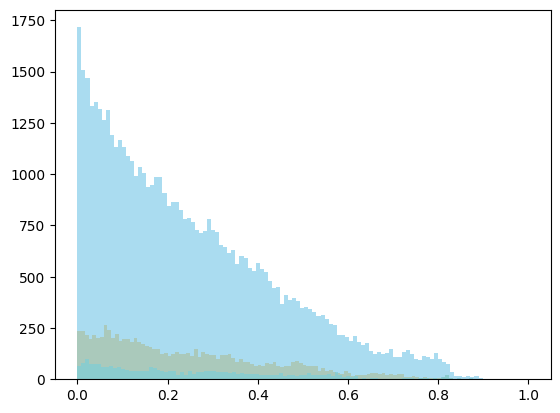

In [2709]:
plt.hist(hap_list, bins=100, alpha=0.7, label='hap', color='orange')
plt.hist(neu_list, bins=100, alpha=0.7, label='neu', color='mediumaquamarine')
plt.hist(ang_list, bins=100, alpha=0.7, label='ang', color='red')
plt.hist(sad_list, bins=100, alpha=0.7, label='sad', color='skyblue')

print(f"ang: {len(ang_list)}")
print(f"hap: {len(hap_list)}")
print(f"neu: {len(neu_list)}")
print(f"sad: {len(sad_list)}")

In [2710]:
list_all = [ang_list, hap_list, neu_list, sad_list]
emotion_labels = ['ang', 'hap', 'neu', 'sad']
non_empty_lists = [lst for lst in list_all if lst]
non_empty_labels = [label for i, label in enumerate(emotion_labels) if list_all[i] != []]
overall_result = kruskal(*non_empty_lists)
print(f'Overall: {overall_result}')

if overall_result.pvalue < 0.05:
    pvalues = []
    unique_pairs = set()
    for i in range(len(non_empty_lists)):
        for j in range(i+1, len(non_empty_lists)):
            pair = tuple(sorted([non_empty_labels[i], non_empty_labels[j]]))
            if pair not in unique_pairs:
                unique_pairs.add(pair)
                result = mannwhitneyu(non_empty_lists[i], non_empty_lists[j], alternative="two-sided")
                print(f'{pair[0]}-{pair[1]}: {result}')
                pvalues.append([i, j, result.pvalue])
                aw = calculate_aw(non_empty_lists[i], non_empty_lists[j])
                print(f'aw: {aw}')
                p1 = len(non_empty_lists[i]) / (len(non_empty_lists[i]) + len(non_empty_lists[j]))
                p2 = len(non_empty_lists[j]) / (len(non_empty_lists[i]) + len(non_empty_lists[j]))
                print(f'da: {convert_aw_to_da(aw, np.var(non_empty_lists[i]), np.var(non_empty_lists[j]), p1=p1, p2=p2)}')

significant_pair_indices = []
pvalues = np.array(pvalues)
sig_p = 0.05 / len(pvalues)
significant_pairs = np.where(pvalues[:, 2] < sig_p)[0]
for i in significant_pairs:
    pair_i = pvalues[i, 0]
    pair_j = pvalues[i, 1]
    significant_pair_indices.append(tuple((pair_i, pair_j)))

Overall: KruskalResult(statistic=7.136147989658639, pvalue=0.028210134255628204)
hap-neu: MannwhitneyuResult(statistic=12055433.0, pvalue=0.00789463495329463)
aw: 0.4832224226390893
da: -0.02899065183491931
hap-sad: MannwhitneyuResult(statistic=243574091.0, pvalue=0.2563557728727246)
aw: 0.49630666790878786
da: -0.006620660611395788
neu-sad: MannwhitneyuResult(statistic=73596227.0, pvalue=0.02050407783263466)
aw: 0.5131954259112824
da: 0.02275742166511533


/var/folders/1x/tmzcjdgn7wqdrcsl41btp5vh0000gn/T/ipykernel_8689/2901644345.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(non_empty_lists, labels=non_empty_labels, positions=np.arange(len(non_empty_lists)))


Text(0.5, 1.0, 'Wavelet Coherence in EDA in LF & HF band')

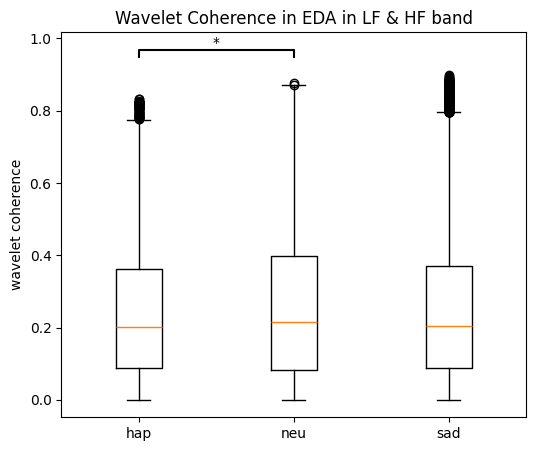

In [2711]:
# Convert lists to numerical values
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(2*len(non_empty_labels), 5))
ax.boxplot(non_empty_lists, labels=non_empty_labels, positions=np.arange(len(non_empty_lists)))
if significant_pair_indices != []:
    for pair in significant_pair_indices:
        y_max = max(np.nanmax(list) for list in non_empty_lists)
        if abs(pair[0] - pair[1]) == 1:
            h = y_max + 0.05
        elif abs(pair[0] - pair[1]) == 2:
            h = y_max + 0.1
        else:
            h = y_max + 0.15
        annotate_boxplot(ax, pair[0], pair[1], h, 0.02, 'k')
ax.set_ylabel('wavelet coherence')
ax.set_title('Wavelet Coherence in EDA in LF & HF band')

In [2712]:
print_mean_rank(ang_list, hap_list)

Group 1 Mean Rank: nan
Group 2 Mean Rank: 4620.5


/Users/yuna.w/Research/CBSL/linkage_analysis/.venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/yuna.w/Research/CBSL/linkage_analysis/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [2713]:
df_without_label_hf = df_without_label.loc[:, (df_without_label.columns > 1/0.4) & (df_without_label.columns < 1/0.15)]
df_hf_high_wct = df_without_label[(df_without_label > percentile_95_ibi).any(axis=1)]
hf_high_wct_timestamp = df_with_label.loc[df_hf_high_wct.index, 'timestamp']
high_cwt_period = find_continuous_periods(hf_high_wct_timestamp)
for i in range(len(high_cwt_period)):
    if (high_cwt_period[i][1] - high_cwt_period[i][0]) >= pd.Timedelta('10s'):
        print(f"Period {i+1}: {high_cwt_period[i][0]} to {high_cwt_period[i][1]}")

Period 2: 2024-11-21 10:54:56.682006836-05:00 to 2024-11-21 10:55:24.682006836-05:00
Period 3: 2024-11-21 10:55:55.682006836-05:00 to 2024-11-21 10:56:09.682006836-05:00
Period 5: 2024-11-21 10:57:14.682006836-05:00 to 2024-11-21 10:58:14.682006836-05:00
Period 7: 2024-11-21 10:59:00.682006836-05:00 to 2024-11-21 10:59:16.682006836-05:00
Period 8: 2024-11-21 10:59:24.682006836-05:00 to 2024-11-21 10:59:44.682006836-05:00
Period 9: 2024-11-21 11:02:20.682006836-05:00 to 2024-11-21 11:02:42.682006836-05:00
Period 10: 2024-11-21 11:03:17.682006836-05:00 to 2024-11-21 11:03:55.682006836-05:00
Period 11: 2024-11-21 11:04:18.682006836-05:00 to 2024-11-21 11:04:28.682006836-05:00
Period 14: 2024-11-21 11:05:53.682006836-05:00 to 2024-11-21 11:06:04.682006836-05:00
Period 15: 2024-11-21 11:06:37.682006836-05:00 to 2024-11-21 11:06:49.682006836-05:00
Period 16: 2024-11-21 11:08:22.682006836-05:00 to 2024-11-21 11:08:33.682006836-05:00
Period 17: 2024-11-21 11:08:52.682006836-05:00 to 2024-11-21

/var/folders/1x/tmzcjdgn7wqdrcsl41btp5vh0000gn/T/ipykernel_8689/3367195430.py:17: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  if (current - end) <= pd.Timedelta(freq):


In [2841]:
session = 'NN'
condition = 'positive'

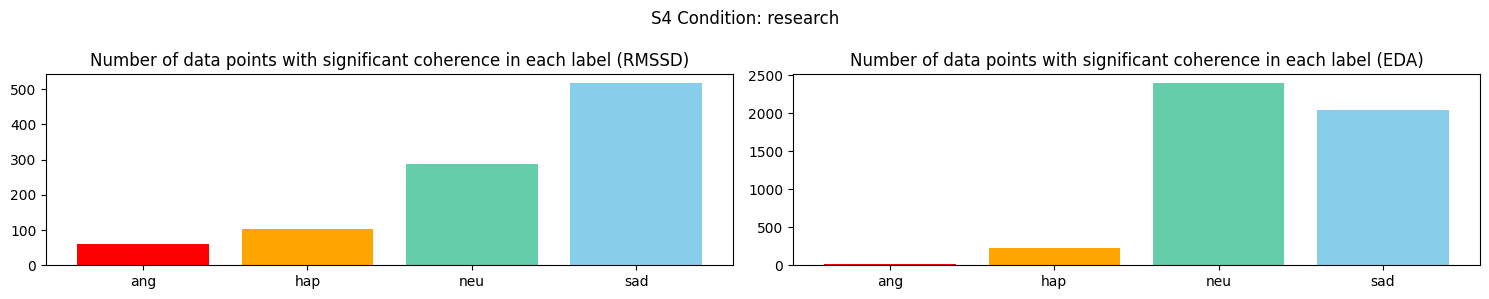

In [2838]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 3))

for modality in ['RMSSD', 'EDA']:
    if modality == 'RMSSD':
        percentile = percentile_95_hrv
    elif modality == 'EDA':
        percentile = percentile_95_eda
    else:
        raise KeyError('Invalid modality. Choose from RMSSD or EDA.')
    if session == 'VM' and modality == 'EDA':
        condition_eda = 'research_eda'
        pickle_file_path = f'../cache/{session}_{condition_eda}_audio_labels.pkl'

        with open(pickle_file_path, 'rb') as f:
            labels = pickle.load(f)
    else:
        pickle_file_path = f'../cache/{session}_{condition}_audio_labels.pkl'
        with open(pickle_file_path, 'rb') as f:
            labels = pickle.load(f)
    try:
        df_with_label, df_without_label, df_with_label_awct, df_without_label_awct, ang_list, hap_list, neu_list, sad_list, ang_list_awct, hap_list_awct, neu_list_awct, sad_list_awct = get_wct_by_label(modality, session, condition, labels)

        list_all = [ang_list, hap_list, neu_list, sad_list]
        emotion_labels = ['ang', 'hap', 'neu', 'sad']
        non_empty_lists = [lst for lst in list_all if lst]
        non_empty_labels = [label for i, label in enumerate(emotion_labels) if list_all[i] != []]

        for i in range(len(non_empty_lists)):
            mask = non_empty_lists[i] > percentile
            n_sig = len(np.array(non_empty_lists[i])[mask])
            if modality == 'RMSSD':
                axes[0].bar(f'{non_empty_labels[i]}', n_sig, color=label_colors[non_empty_labels[i]])
            else:
                axes[1].bar(f'{non_empty_labels[i]}', n_sig, color=label_colors[non_empty_labels[i]])
        axes[0].set_title('Number of data points with significant coherence in each label (RMSSD)')
        axes[1].set_title('Number of data points with significant coherence in each label (EDA)')
    except KeyError:
        continue

if session == 'NN':
    study = 'S1'
elif session == 'NY':
    study = 'S2'
elif session == 'MG':
    study = 'S3'
elif session == 'VM':
    study = 'S4'
fig.suptitle(f'{study} Condition: {condition}')
plt.tight_layout()

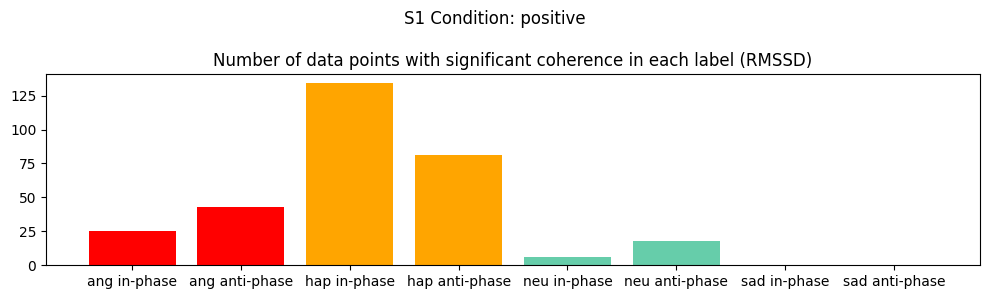

In [2842]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(10, 3))
axes = [axes]
for modality in ['RMSSD', 'EDA']:
    if modality == 'RMSSD':
        percentile = percentile_95_hrv
    elif modality == 'EDA':
        percentile = percentile_95_eda
    else:
        raise KeyError('Invalid modality. Choose from RMSSD or EDA.')
    if session == 'VM' and modality == 'EDA':
        condition_eda = 'research_eda'
        pickle_file_path = f'../cache/{session}_{condition_eda}_audio_labels.pkl'

        with open(pickle_file_path, 'rb') as f:
            labels = pickle.load(f)
    else:
        pickle_file_path = f'../cache/{session}_{condition}_audio_labels.pkl'
        with open(pickle_file_path, 'rb') as f:
            labels = pickle.load(f)
    try:
        df_with_label, df_without_label, df_with_label_awct, df_without_label_awct, ang_list, hap_list, neu_list, sad_list, ang_list_awct, hap_list_awct, neu_list_awct, sad_list_awct = get_wct_by_label(modality, session, condition, labels)

        list_all = [ang_list, hap_list, neu_list, sad_list]
        list_all_awct = [ang_list_awct, hap_list_awct, neu_list_awct, sad_list_awct]
        emotion_labels = ['ang', 'hap', 'neu', 'sad']
        non_empty_lists = [lst for lst in list_all if lst]
        non_empty_lists_awct = [lst for lst in list_all_awct if lst]
        non_empty_labels = [label for i, label in enumerate(emotion_labels) if list_all[i] != []]

        for i in range(len(non_empty_lists)):
            mask = non_empty_lists[i] > percentile
            masked = np.array(non_empty_lists_awct[i])[mask]
            n_in_phase = len(masked[masked > 0])
            n_anti_phase = len(masked[masked < 0])
            if modality == 'RMSSD':
                axes[0].bar(f'{non_empty_labels[i]} in-phase', n_in_phase, color=label_colors[non_empty_labels[i]])
                axes[0].bar(f'{non_empty_labels[i]} anti-phase', n_anti_phase, color=label_colors[non_empty_labels[i]])
            #else:
                #axes[1].bar(f'{non_empty_labels[i]} in-phase', n_in_phase, color=label_colors[non_empty_labels[i]])
                #axes[1].bar(f'{non_empty_labels[i]} anti-phase', n_anti_phase, color=label_colors[non_empty_labels[i]])
        axes[0].set_title('Number of data points with significant coherence in each label (RMSSD)')
        #axes[1].set_title('Number of data points with significant coherence in each label (EDA)')
    except KeyError:
        continue

if session == 'NN':
    study = 'S1'
elif session == 'NY':
    study = 'S2'
elif session == 'MG':
    study = 'S3'
elif session == 'VM':
    study = 'S4'
fig.suptitle(f'{study} Condition: {condition}')
plt.tight_layout()